In [ ]:
import shap
import pyodbc
import joblib
import missingno
import sqlalchemy
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl
from math import sin, cos
from scipy.special import boxcox1p
from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
sns.set_style('whitegrid', {'axes.grid': False})
sns.set_context('poster')
sns.set_palette('husl')
pd.set_option('float_format', '{:,.3f}'.format)
mpl.rcParams['figure.dpi']= 200

In [5]:
conn_string = str('DRIVER={ODBC Driver 17 for SQL Server};'
                  'SERVER=127.0.0.1,1433;'
                  'DATABASE=data;'
                  'UID=sa;'
                  'PWD='
                 )
conn = pyodbc.connect(conn_string)
engine = sqlalchemy.create_engine("mssql+pyodbc://sa:@127.0.0.1:1433/data?driver=ODBC+Driver+17+for+SQL+Server")

### Random forest hyperparameter tuning

In [6]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap
              }

### GB hyperparameter tuning

In [7]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=3000, num=30)]
learning_rate = np.linspace(0.001, 0.5, 100)
gamma = np.logspace(-3, 4, 100)
max_depth = [1, 2, 3, 4]
min_child_weight = [1, 2, 3, 4]
subsample = np.linspace(0.5, 1.0, 19)
colsample_bytree = np.linspace(0.5, 1.0, 19)
colsample_bylevel = np.linspace(0.5, 1.0, 19)
reg_lambda = np.logspace(-2, 4, 100)
reg_alpha = np.logspace(-2, 4, 100)
gb_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'colsample_bylevel': colsample_bylevel,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
}

gb_grid_multi = {
    'estimator__n_estimators': n_estimators,
    'estimator__learning_rate': learning_rate,
    'estimator__gamma': gamma,
    'estimator__max_depth': max_depth,
    'estimator__min_child_weight': min_child_weight,
    'estimator__subsample': subsample,
    'estimator__colsample_bytree': colsample_bytree,
    'estimator__colsample_bylevel': colsample_bylevel,
    'estimator__reg_alpha': reg_alpha,
    'estimator__reg_lambda': reg_lambda
}

### Ridge hyperparameter tuning

In [8]:
alpha = np.logspace(-6, 6, 100)

### Select well features

In [9]:
sql_well = str('SELECT wells.api10, '
               'wells.SubPlay, '
               'wells.WellID, '
               'wells.CompletionID, '
               'wells.Latitude, '
               'wells.Longitude, '
               'wells.Latitude_BH, '
               'wells.Longitude_BH, '
               'wells.TVD, '
               'wells.MD, '
               'wells.PerfInterval, '
               'wells.FracStages, '
               'wells.StageSpacingFT, '
               'wells.ProppantPerFT, '
               'wells.ProppantLBS, '
               'wells.FluidBBLS, '
               'wells.FluidPerFT, '
               'wells.OilGravity, '
               'wells.MonthsToPeakProduction, '
               'wells.TotalProducingMonths, '
               'wells.xmid, '
               'wells.xlen, '
               'wells.ymid, '
               'wells.ylen, '
               'wells.zmid, '
               'wells.zlen, '
               'wells.xy_ratio, '
               'wells.z_ratio, '
               'wells.xyz_ratio, '
               'wells.ns_orientation, '
               'wells.main_total_xy_dist, '
               'wells.xpos_dist, '
               'wells.xpos_timedelta, '
               'wells.xneg_dist, '
               'wells.xneg_timedelta, '
               'wells.ypos_dist, '
               'wells.ypos_timedelta, '
               'wells.yneg_dist, '
               'wells.yneg_timedelta, '
               'wells.zpos_dist, '
               'wells.zpos_timedelta, '
               'wells.zneg_dist, '
               'wells.zneg_timedelta, '
               'wells.xy_dist, '
               'wells.xy_timedelta, '
               'wells.xyz_dist, '
               'wells.xyz_timedelta '
               'FROM wells '
               'WHERE wells.Status = \'Producing\' '
              )
df_sql_well = pd.read_sql(sql_well, conn)

### Select forecast data to generate targets

In [10]:
sql_fcst = str('SELECT forecasts.api10, '
               'forecasts.TimeOnProd, '
               'forecasts.oilBBL, '
               'forecasts.gasMCF '
               'FROM forecasts'
              )
df_sql_fcst = pd.read_sql(sql_fcst, conn)

In [11]:
df = df_sql_well.copy()

### Create 6 month sums of production targets

In [12]:
months = np.arange(6, 78, 6)
oil_dict = {}
gas_dict = {}
gor_dict = {}
for m in months:
    oil_dict['oil'+str(m)] = df_sql_fcst.loc[df_sql_fcst.TimeOnProd <= int(m), :].groupby(
        by=['api10'], as_index=False)[['api10', 'oilBBL']].sum()
    
    gas_dict['gas'+str(m)] = df_sql_fcst.loc[df_sql_fcst.TimeOnProd <= int(m), :].groupby(
        by=['api10'], as_index=False)[['api10', 'gasMCF']].sum()
    
    gor_dict['gor'+str(m)] = oil_dict['oil'+str(m)].merge(gas_dict['gas'+str(m)], left_on='api10', right_on='api10')
    gor_dict['gor'+str(m)]['gor'+str(m)] = gor_dict['gor'+str(m)].gasMCF / gor_dict['gor'+str(m)].oilBBL
    gor_dict['gor'+str(m)] = gor_dict['gor'+str(m)].loc[:, ['api10', 'gor'+str(m)]]
    gor_dict['gor'+str(m)][np.isinf(gor_dict['gor'+str(m)]['gor'+str(m)])] = np.nan
    
    df = df.merge(oil_dict['oil'+str(m)], left_on='api10', right_on='api10')
    df.rename(columns={'oilBBL': 'oil'+str(m)}, inplace=True)
    
    df = df.merge(gas_dict['gas'+str(m)], left_on='api10', right_on='api10')
    df.rename(columns={'gasMCF': 'gas'+str(m)}, inplace=True)
    
    df = df.merge(gor_dict['gor'+str(m)], left_on='api10', right_on='api10')

### Convert lat long to X Y coordinates

In [13]:
x_coord = df.Latitude.apply(cos)*df.Longitude.apply(cos)
y_coord = df.Latitude.apply(cos)*df.Longitude.apply(sin)
x_coord_bh = df.Latitude_BH.apply(cos)*df.Longitude_BH.apply(cos)
y_coord_bh = df.Latitude_BH.apply(cos)*df.Longitude_BH.apply(sin)

df.rename(columns={'Latitude':     'x_coord',
                   'Longitude':    'y_coord',
                   'Latitude_BH':  'x_coord_bh',
                   'Longitude_BH': 'y_coord_bh'
                  }, inplace=True)

df['x_coord'] = pd.Series(x_coord)
df['y_coord'] = pd.Series(y_coord)
df['x_coord_bh'] = pd.Series(x_coord_bh)
df['y_coord_bh'] = pd.Series(y_coord_bh)
print(df.isna().sum())

api10                        0
SubPlay                      1
WellID                       0
CompletionID                 0
x_coord                      0
y_coord                      0
x_coord_bh                  26
y_coord_bh                  26
TVD                          2
MD                           6
PerfInterval                11
FracStages                1438
StageSpacingFT            1446
ProppantPerFT              501
ProppantLBS                487
FluidBBLS                  365
FluidPerFT                 374
OilGravity                1314
MonthsToPeakProduction       0
TotalProducingMonths         0
xmid                      1272
xlen                      1272
ymid                      1272
ylen                      1272
zmid                      1272
zlen                      1272
xy_ratio                  1821
z_ratio                   1821
xyz_ratio                 1821
ns_orientation             710
                          ... 
oil18                        0
gas18   

### Review missing data

api10                        0
SubPlay                      1
WellID                       0
CompletionID                 0
x_coord                      0
y_coord                      0
x_coord_bh                  26
y_coord_bh                  26
TVD                          2
MD                           6
PerfInterval                11
FracStages                1438
StageSpacingFT            1446
ProppantPerFT              501
ProppantLBS                487
FluidBBLS                  365
FluidPerFT                 374
OilGravity                1314
MonthsToPeakProduction       0
TotalProducingMonths         0
xmid                      1272
xlen                      1272
ymid                      1272
ylen                      1272
zmid                      1272
zlen                      1272
xy_ratio                  1821
z_ratio                   1821
xyz_ratio                 1821
ns_orientation             710
                          ... 
oil18                        0
gas18   

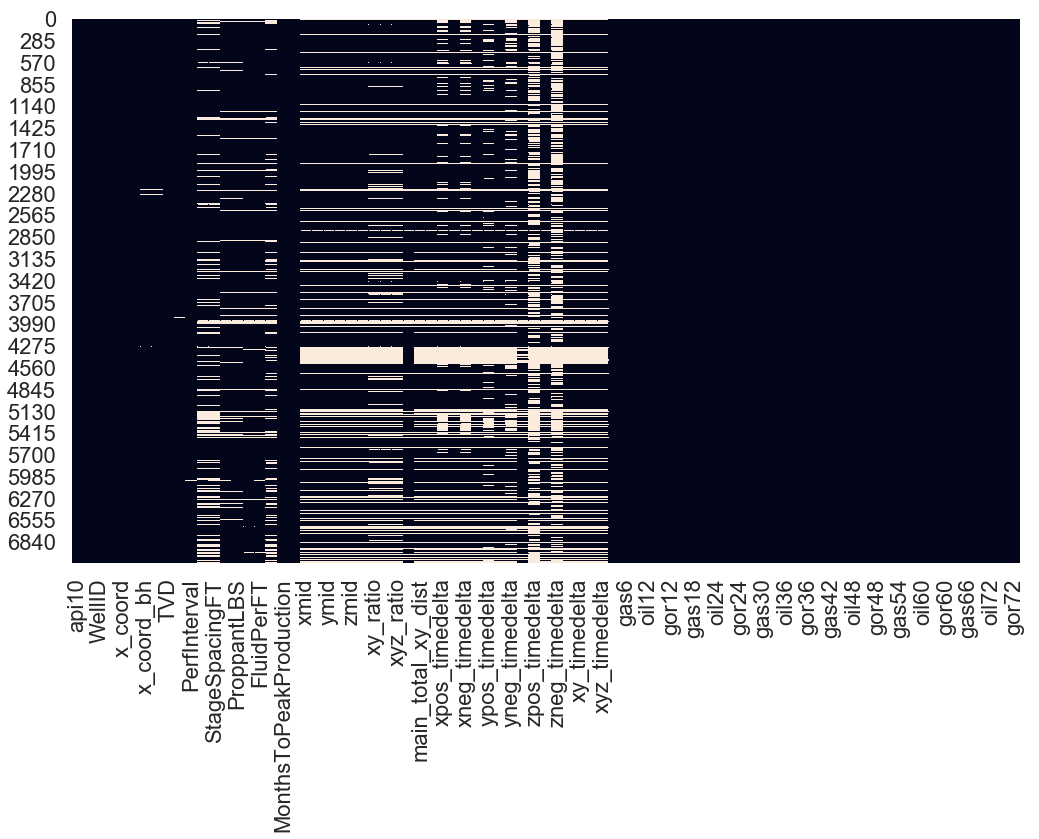

In [12]:
print(df.isna().sum())
plt.figure(figsize=(17, 10))
sns.heatmap(df.isnull(), cbar=False)

### Set missing bottom hole x, y to surface x, y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7109 entries, 0 to 7108
Data columns (total 83 columns):
api10                     7109 non-null object
SubPlay                   7108 non-null object
WellID                    7109 non-null int64
CompletionID              7109 non-null int64
x_coord                   7109 non-null float64
y_coord                   7109 non-null float64
x_coord_bh                7109 non-null float64
y_coord_bh                7109 non-null float64
TVD                       7107 non-null float64
MD                        7103 non-null float64
PerfInterval              7098 non-null float64
FracStages                5671 non-null float64
StageSpacingFT            5663 non-null float64
ProppantPerFT             6608 non-null float64
ProppantLBS               6622 non-null float64
FluidBBLS                 6744 non-null float64
FluidPerFT                6735 non-null float64
OilGravity                5795 non-null float64
MonthsToPeakProduction    7109 non-

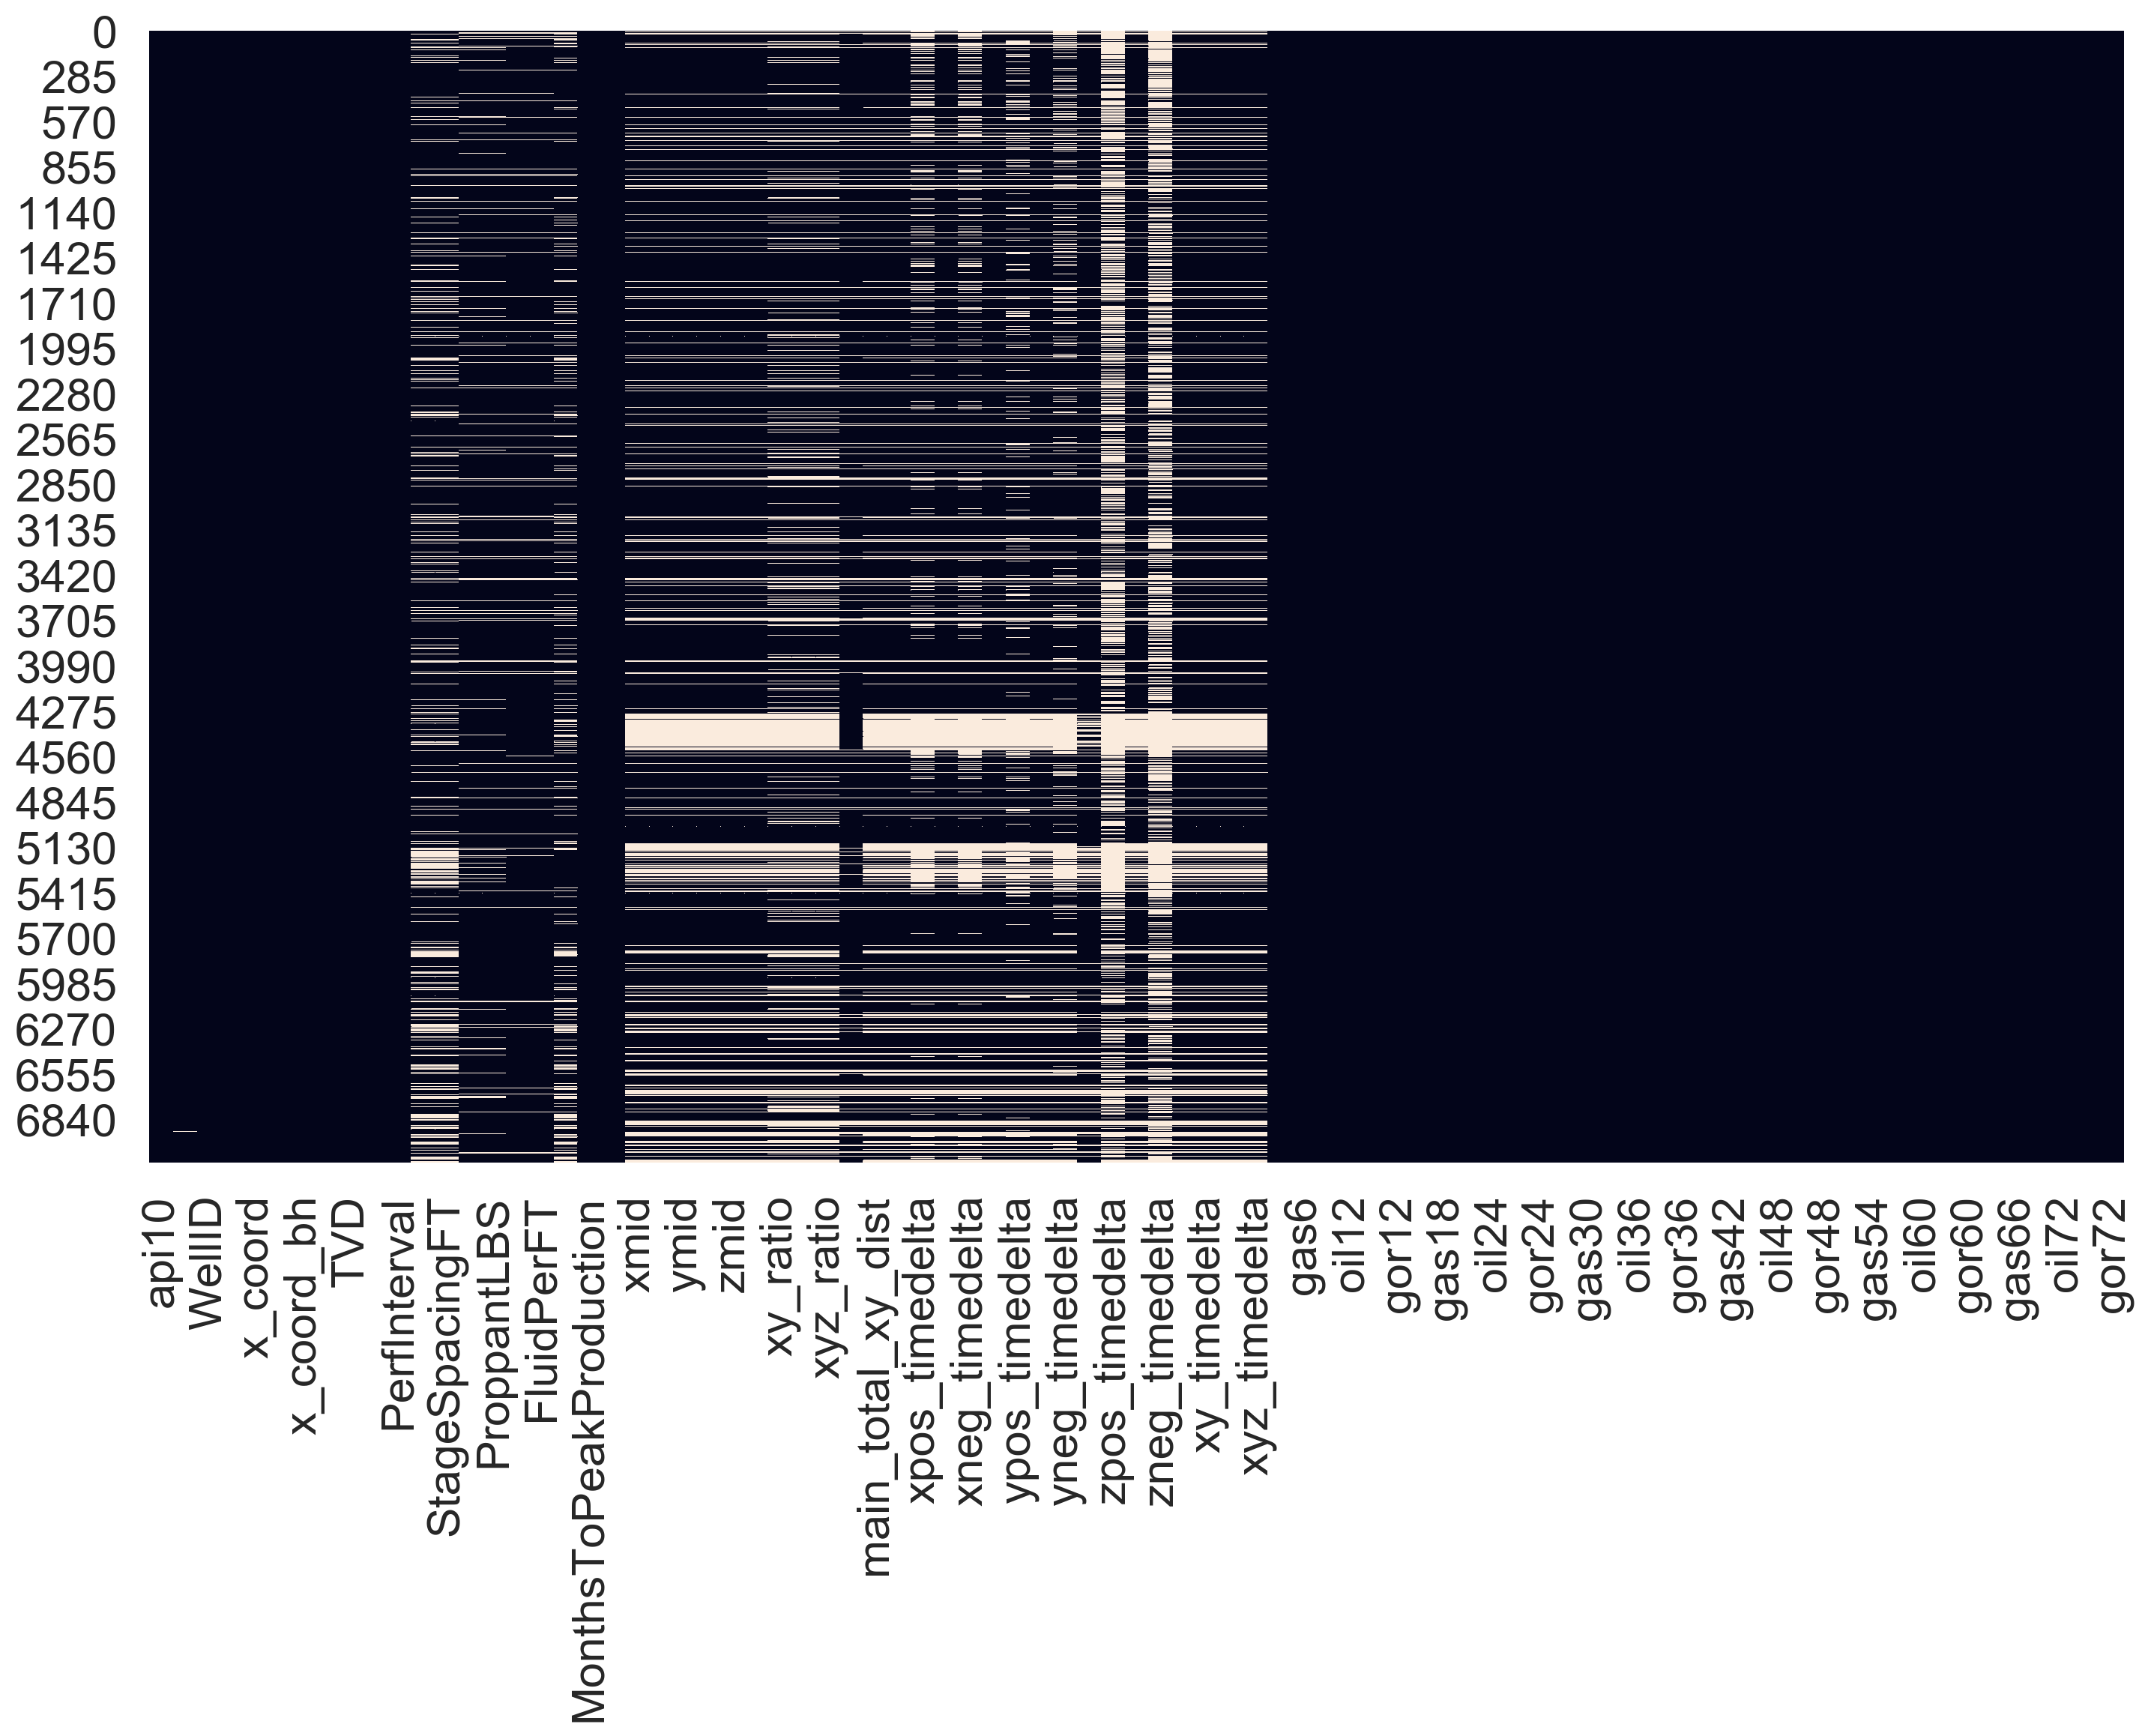

In [14]:
df.loc[df['x_coord_bh'].isnull(), 'x_coord_bh'] = df.loc[df['x_coord_bh'].isnull(), 'x_coord']
df.loc[df['y_coord_bh'].isnull(), 'y_coord_bh'] = df.loc[df['y_coord_bh'].isnull(), 'y_coord']
plt.figure(figsize=(17, 10))
sns.heatmap(df.isnull(), cbar=False)
print(df.info())

### Impute missing GOR

count   7,109.000
mean        4.861
std         3.642
min         0.065
25%         2.552
50%         4.055
75%         6.032
max        34.898
Name: gor36, dtype: float64

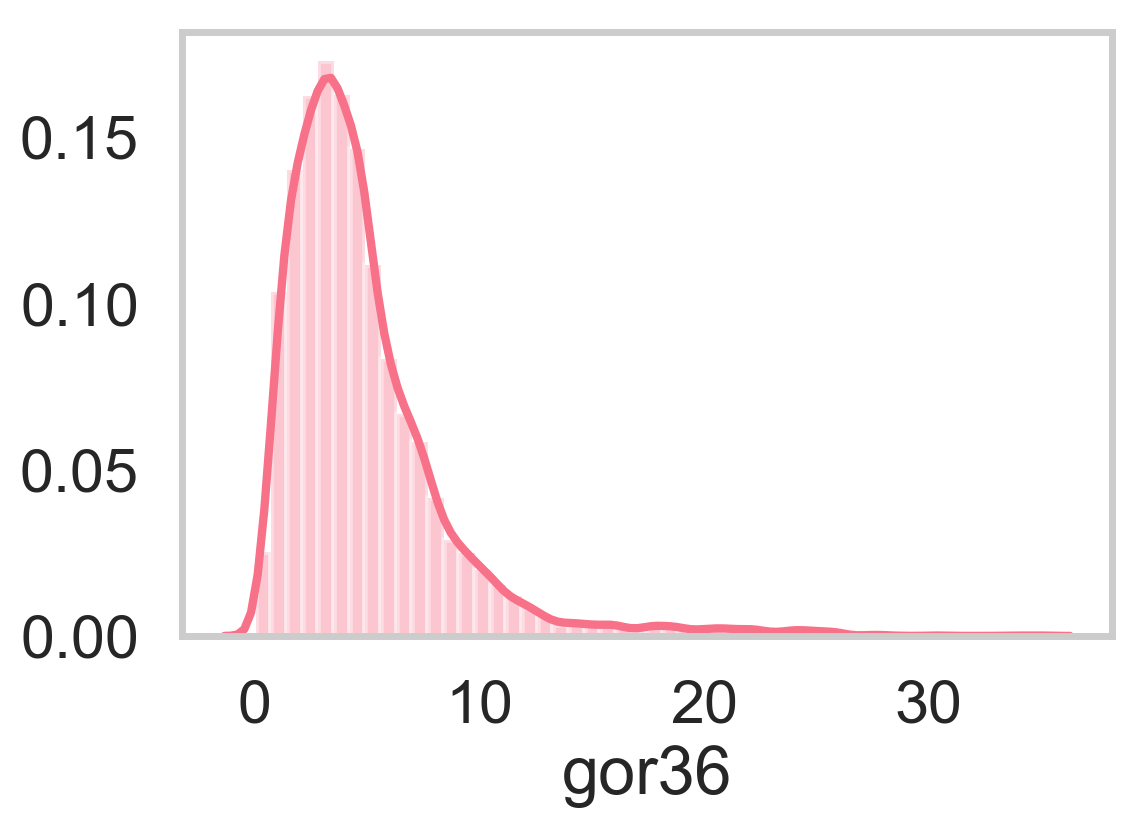

In [15]:
for c in df.columns:
    if 'gor' in c:
        df.loc[df[c].isnull(), c] = np.random.normal(df[c].median(), 1.0, df.loc[df[c].isnull(), c].shape[0])     
        df.loc[df[c] == 0, c] = np.random.normal(df[c].median(), 1.0, df.loc[df[c] == 0, c].shape[0])
sns.distplot(df['gor36'])
df['gor36'].describe()

### Impute missing MD using linear regression with TVD and perf interval

In [16]:
print('Missing MD count:', df.isna()['MD'].sum())
md = df.loc[:, ['MD', 'TVD', 'PerfInterval']]
X = md[(~pd.isna(md.MD)) & (~pd.isna(md.TVD)) & (~pd.isna(md.PerfInterval))][['TVD', 'PerfInterval']]
y = md[(~pd.isna(md.MD)) & (~pd.isna(md.TVD)) & (~pd.isna(md.PerfInterval))]['MD']
print('X shape:', X.shape)
print('y shape:', y.shape)
missing_x = md.loc[(pd.isna(md.MD)) & (~pd.isna(md.TVD)) & (~pd.isna(md.PerfInterval)), ['TVD', 'PerfInterval']]
print('Missing x shape:', missing_x.shape)
try:
    reg = joblib.load('md.pkl')
except:
    reg = LassoCV(alphas=alpha, cv=5).fit(X, y)
    joblib.dump(reg, 'md.pkl')
print('Training Score:', '{:,.2f}'.format(reg.score(X, y)))
imputed_y = reg.predict(missing_x)
df.loc[(pd.isna(df.MD)) & (~pd.isna(df.TVD)) & (~pd.isna(df.PerfInterval)), 'MD'] = imputed_y

Missing MD count: 6
X shape: (7093, 2)
y shape: (7093,)
Missing x shape: (5, 2)
Training Score: 0.94


count    7,109.000
mean    13,385.400
std      2,515.700
min      6,153.000
25%     11,498.000
50%     12,457.000
75%     15,236.000
max     22,608.000
Name: MD, dtype: float64

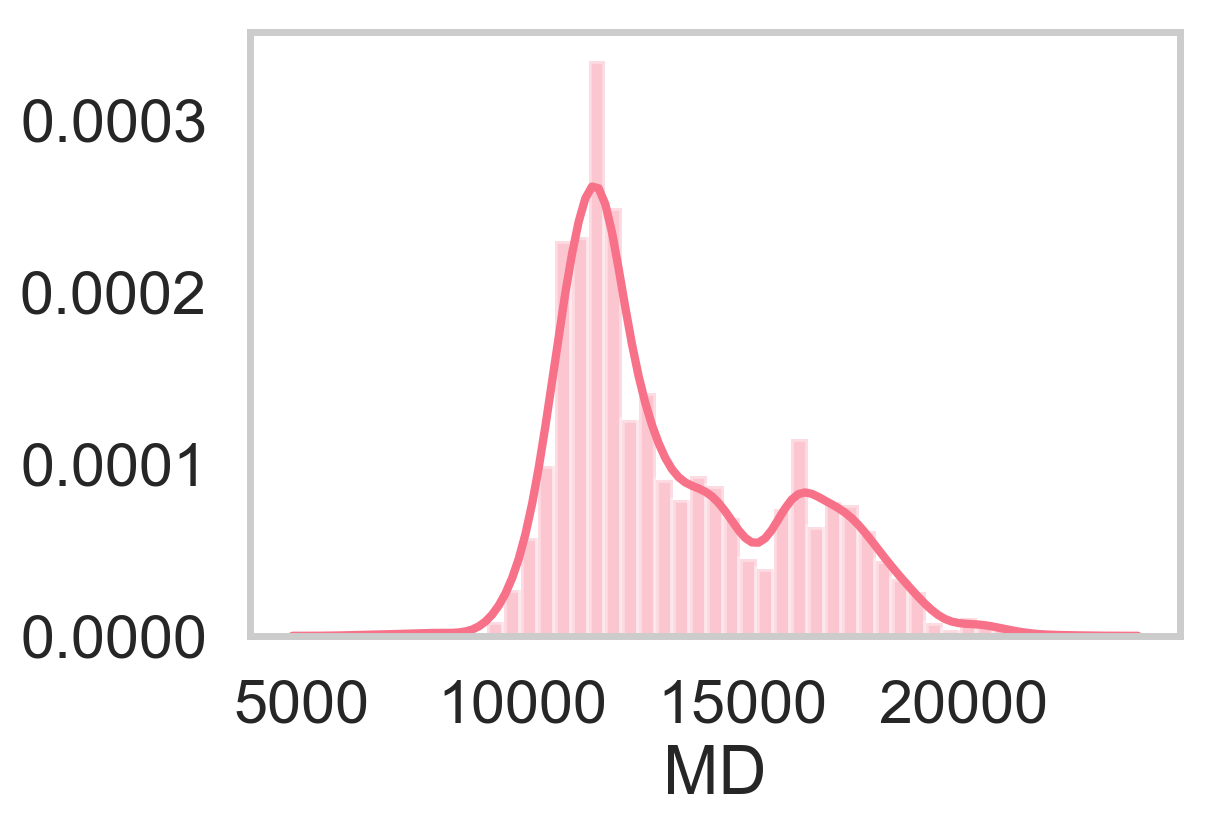

In [17]:
df.loc[df.MD.isnull(), 'MD'] = np.random.normal(6900., 2000, df.loc[df.MD.isnull(), 'MD'].shape[0])
sns.distplot(df.MD)
df.MD.describe()

count      25.000
mean    5,071.400
std       919.974
min       983.000
25%     4,992.000
50%     5,430.000
75%     5,484.000
max     5,499.000
Name: TVD, dtype: float64
count   7,109.000
mean    6,952.027
std       612.979
min     5,042.172
25%     6,594.000
50%     7,035.000
75%     7,287.000
max     9,193.000
Name: TVD, dtype: float64


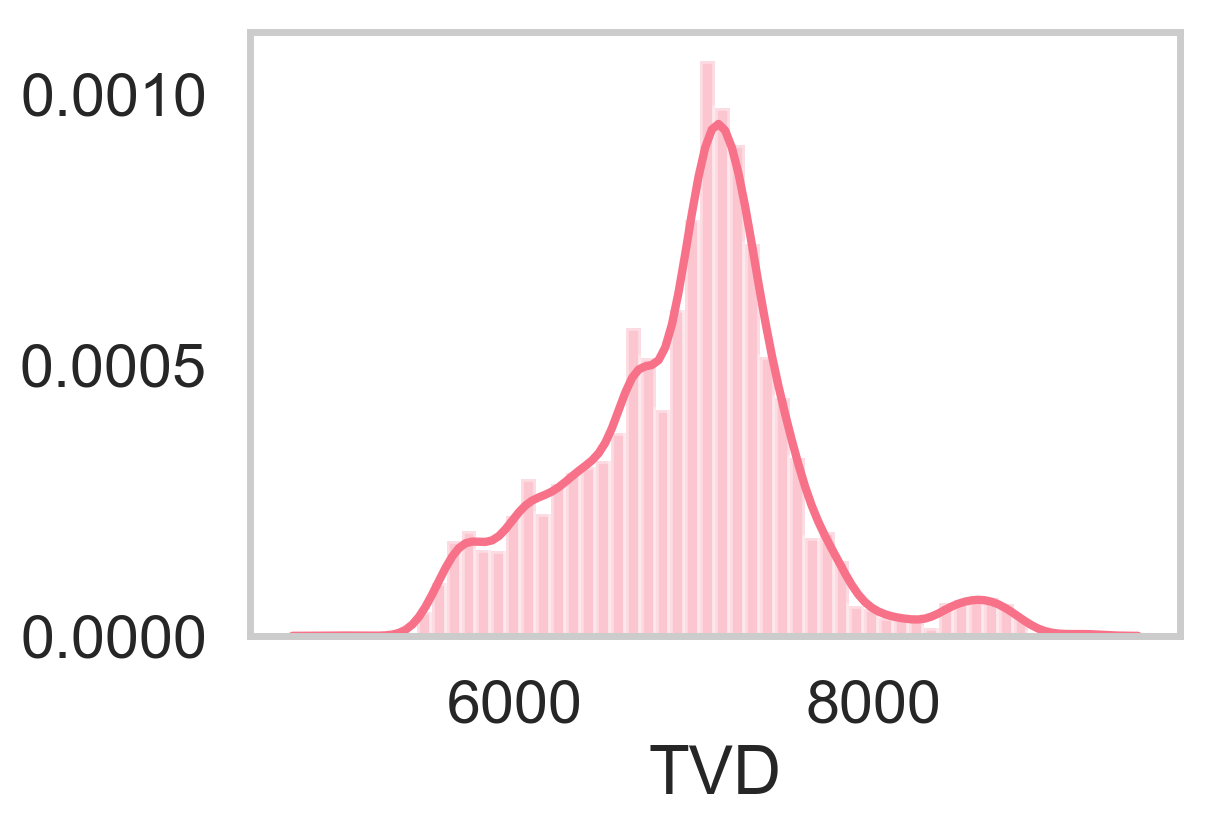

In [18]:
df.loc[df.TVD.isnull(), 'TVD'] = np.random.normal(df.TVD.median(), 1000, df.loc[df.TVD.isnull(), 'TVD'].shape[0])
#sns.distplot(df.loc[df.TVD < 5500, 'TVD'])
print(df.loc[df.TVD < 5500, 'TVD'].describe())
df.loc[(df.TVD < 5500) | (df.TVD > 11000), 'TVD'] = np.random.normal(df.TVD.median(), 1000, df.loc[(df.TVD < 5500) | (df.TVD > 11000), 'TVD'].shape[0])
sns.distplot(df.TVD)
print(df.TVD.describe())

### Impute missing perf interval using linear regression with TVD and MD

In [19]:
pf = df.loc[:, ['MD', 'TVD', 'PerfInterval']]
X = pf[(~pd.isna(pf.MD)) & (~pd.isna(pf.TVD)) & (~pd.isna(pf.PerfInterval))][['TVD', 'MD']]
y = pf[(~pd.isna(pf.MD)) & (~pd.isna(pf.TVD)) & (~pd.isna(pf.PerfInterval))]['PerfInterval']
print('X shape:', X.shape)
print('y shape:', y.shape)
missing_x = pf.loc[(pd.isna(pf.PerfInterval)) & (~pd.isna(pf.TVD)) & (~pd.isna(pf.MD)), ['TVD', 'MD']]
print('Missing x shape:', missing_x.shape)
try:
    reg = joblib.load('perf_int.pkl')
except:
    reg = LassoCV(alphas=alpha, cv=5).fit(X, y)
    joblib.dump(reg, 'perf_int.pkl')
print('score:', '{:,.2f}'.format(reg.score(X, y)))
imputed_y = reg.predict(missing_x)
df.loc[(pd.isna(df.PerfInterval)) & (~pd.isna(df.TVD)) & (~pd.isna(df.MD)), 'PerfInterval'] = imputed_y

X shape: (7098, 2)
y shape: (7098,)
Missing x shape: (11, 2)
score: 0.94


count    7,109.000
mean     5,847.225
std      2,306.224
min      1,145.000
25%      4,014.000
50%      4,702.000
75%      7,591.000
max     14,269.000
Name: PerfInterval, dtype: float64

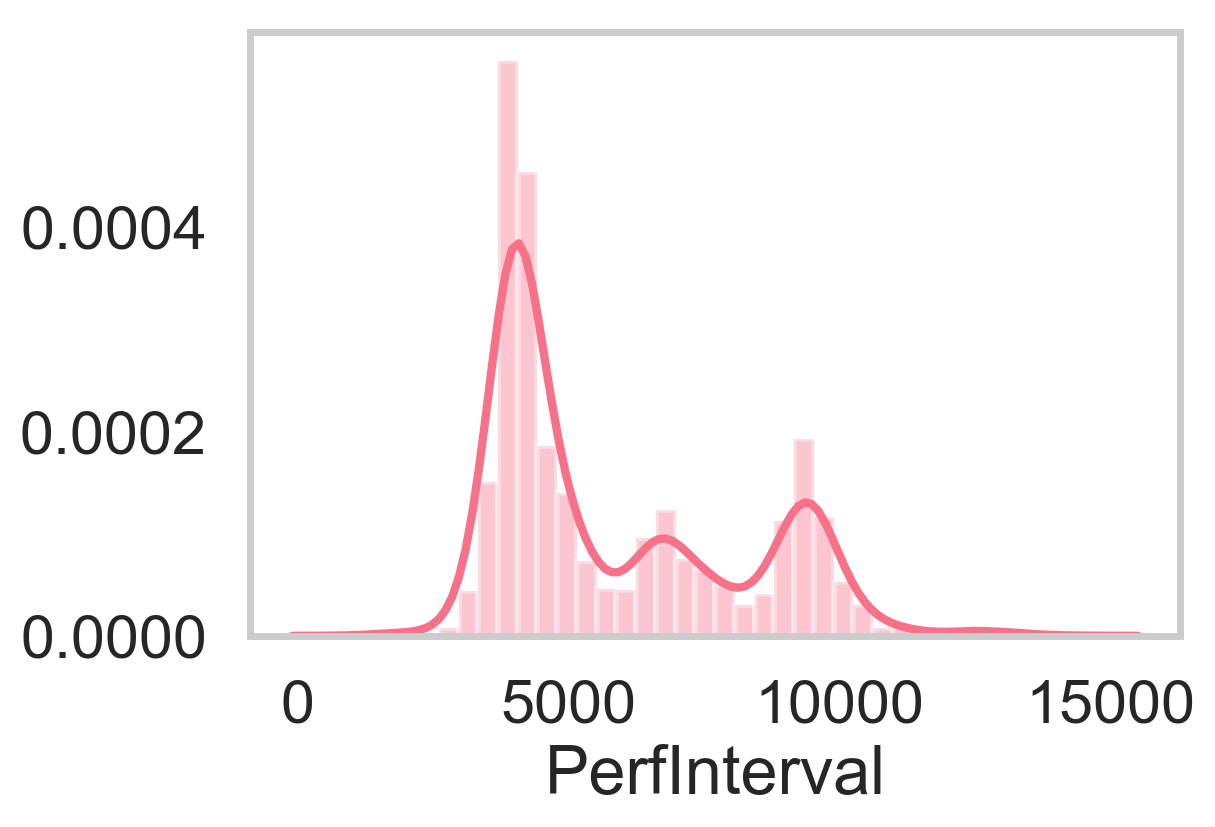

In [20]:
df.loc[(df['PerfInterval'] < 1000), 'PerfInterval'] = df['PerfInterval'].median()
sns.distplot(df['PerfInterval'])
df['PerfInterval'].describe()

### Impute missing orientation

In [21]:
df.loc[df['ns_orientation'] == False, 'ns_orientation'] = int(0)
df.loc[df['ns_orientation'] == True, 'ns_orientation'] = int(1)
df.loc[df['ns_orientation'].isnull(), 'ns_orientation'] = np.nan

In [22]:
X = df[~pd.isna(df.ns_orientation)][['x_coord', 'y_coord',
                                     'x_coord_bh', 'y_coord_bh',
                                     'TVD', 'MD', 'PerfInterval',
                                     'TotalProducingMonths'
                                    ]]
y = df[~pd.isna(df.ns_orientation)]['ns_orientation'].astype(int)
missing_x = df.loc[pd.isna(df.ns_orientation), ['x_coord', 'y_coord',
                                                'x_coord_bh', 'y_coord_bh',
                                                'TVD', 'MD', 'PerfInterval',
                                                'TotalProducingMonths',
                                                ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

missing_x = missing_x.dropna()
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Missing x shape:', missing_x.shape)
try:
    gb_random = joblib.load('orientation.pkl')
except:
    gb = xgb.XGBClassifier(verbose_eval=False)
    gb_random = RandomizedSearchCV(estimator=gb,
                                   param_distributions=gb_grid,
                                   n_iter=50,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1
                                  )
    gb_random.fit(X_train, y_train)
    joblib.dump(gb_random, 'orientation.pkl')
print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
print(gb_random.best_params_)
imputed_y = np.transpose(gb_random.predict(missing_x))
df.loc[missing_x.index, 'ns_orientation'] = imputed_y

X shape: (6399, 8)
y shape: (6399,)
Missing x shape: (710, 8)
Training score: 1.00
Test score: 0.91
{'subsample': 0.8333333333333333, 'reg_lambda': 0.07054802310718646, 'reg_alpha': 0.14174741629268056, 'n_estimators': 2800, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.16733333333333333, 'gamma': 0.013530477745798068, 'colsample_bytree': 0.6111111111111112, 'colsample_bylevel': 0.75}


In [23]:
print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
print(gb_random.best_params_)

Training score: 1.00
Test score: 0.91
{'subsample': 0.8333333333333333, 'reg_lambda': 0.07054802310718646, 'reg_alpha': 0.14174741629268056, 'n_estimators': 2800, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.16733333333333333, 'gamma': 0.013530477745798068, 'colsample_bytree': 0.6111111111111112, 'colsample_bylevel': 0.75}


In [24]:
print(y.sum()/y.count())
print(imputed_y.sum()/len(imputed_y))

0.48226285357087045
0.5112676056338028


### Impute missing x, y, z length data

In [25]:
def impute_xyz_data(df, c, features):
    dfc = df.copy()
    X = dfc[~pd.isna(dfc[c])][features]
    y = dfc[~pd.isna(dfc[c])][c]
    missing_x = dfc.loc[pd.isna(dfc[c]), features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
    missing_x = missing_x.dropna()
    print('Imputing', c)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    print('Missing x shape:', missing_x.shape)
    if missing_x.shape[0] == 0:
        print('no missing data to impute.')
        return dfc, None, None
    try:
        gb_random = joblib.load(str(c)+'.pkl')
    except:
        gb = xgb.XGBRegressor()
        gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
        gb_random.fit(X_train, y_train)
        joblib.dump(gb_random, str(c)+'.pkl')
    print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
    print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
    print(gb_random.best_params_)
    imputed_y = np.transpose(gb_random.predict(missing_x))
    dfc.loc[missing_x.index, c] = imputed_y
    return dfc, y, imputed_y

In [26]:
xyz = ['xmid', 'ymid', 'zmid', 'xlen', 'ylen', 'zlen']
features = ['x_coord', 'y_coord', 'x_coord_bh', 'y_coord_bh',
            'TVD', 'MD', 'PerfInterval', 'ns_orientation',
            'TotalProducingMonths']
y_vals = {}
imputed_y_vals = {}
for c in xyz:
    df, y, imputed_y = impute_xyz_data(df, c, features)
    if y is not None:
        y_vals[c] = y
    if imputed_y is not None:
        imputed_y_vals[c] = imputed_y

Imputing xmid
X shape: (5837, 9)
y shape: (5837,)
Missing x shape: (1272, 9)
Training score: 1.00
Test score: 1.00
{'subsample': 0.8611111111111112, 'reg_lambda': 0.01, 'reg_alpha': 2477.076355991714, 'n_estimators': 1100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.046363636363636364, 'gamma': 0.29836472402833375, 'colsample_bytree': 0.6666666666666666, 'colsample_bylevel': 1.0}
Imputing ymid
X shape: (5837, 9)
y shape: (5837,)
Missing x shape: (1272, 9)
Training score: 1.00
Test score: 0.99
{'subsample': 0.9166666666666666, 'reg_lambda': 32.74549162877728, 'reg_alpha': 10000.0, 'n_estimators': 2300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.34374747474747475, 'gamma': 3764.9358067924636, 'colsample_bytree': 0.9444444444444444, 'colsample_bylevel': 0.9444444444444444}
Imputing zmid
X shape: (5837, 9)
y shape: (5837,)
Missing x shape: (1272, 9)
Training score: 1.00
Test score: 0.97
{'subsample': 0.5277777777777778, 'reg_lambda': 9.326033468832199, 'reg_alp

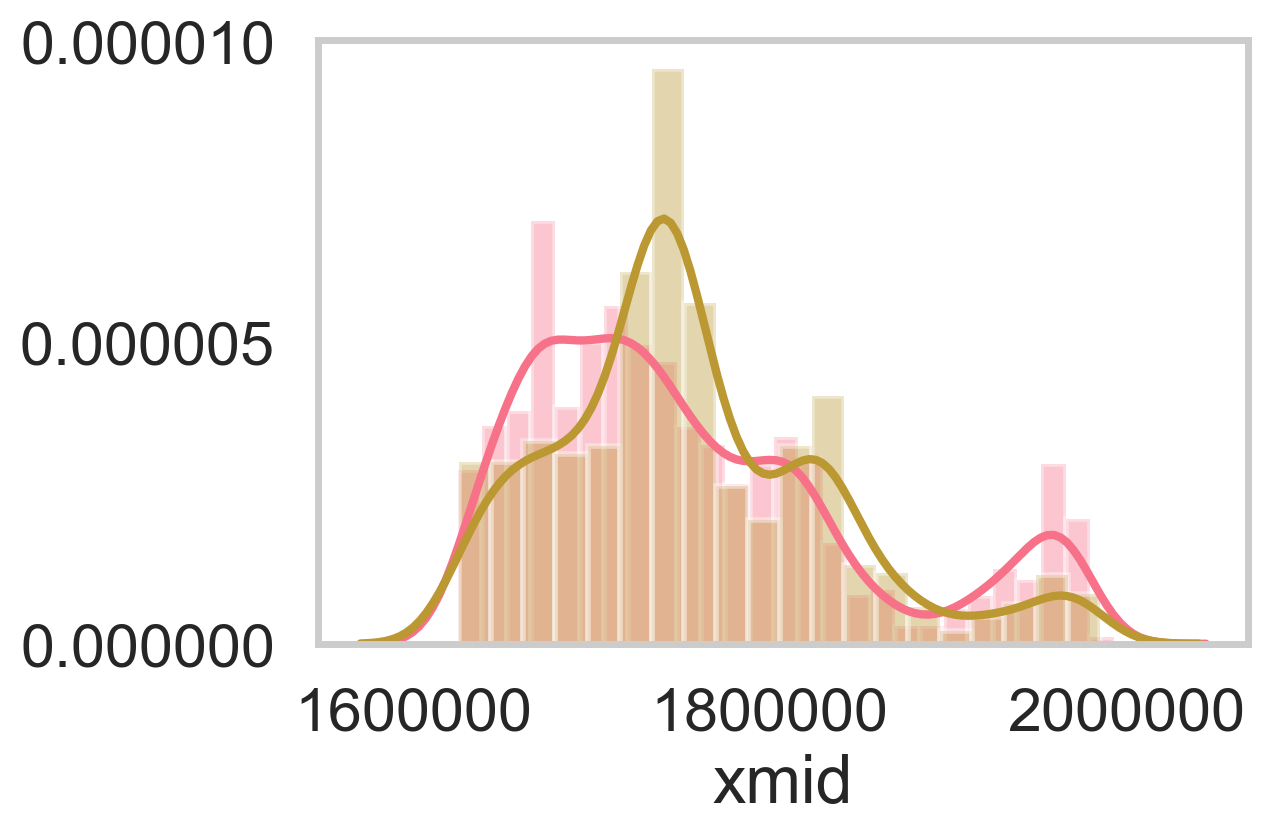

In [27]:
sns.distplot(y_vals['xmid'])
sns.distplot(imputed_y_vals['xmid'])

In [28]:
df.loc[(df.ns_orientation == False) & (df.xlen == 0), 'xlen'] = 6900.
df.loc[(df.ns_orientation == True) & (df.ylen == 0), 'xlen'] = 6900.
df.xy_ratio = df.xlen / df.ylen
df.loc[np.isinf(df.xy_ratio), :] = 2000.
df.z_ratio = df.zlen / df[['xlen', 'ylen']].max(axis=1)
df.xyz_ratio = df.z_ratio / df.xy_ratio

### Impute missing spacing distances

In [29]:
spacing_features = ['xpos_dist', 'xpos_timedelta',
                    'xneg_dist', 'xneg_timedelta',
                    'ypos_dist', 'ypos_timedelta',
                    'yneg_dist', 'yneg_timedelta',
                    'zpos_dist', 'zpos_timedelta',
                    'zneg_dist', 'zneg_timedelta',
                    'xy_dist', 'xy_timedelta',
                    'xyz_dist', 'xyz_timedelta'
                   ]
spacing_y_vals = {}
spacing_imputed_y_vals = {}

for i, f in enumerate(spacing_features):
    print(f)
    features = ['x_coord', 'y_coord', 'x_coord_bh', 'y_coord_bh', 'TVD', 'MD', 'PerfInterval',
                'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36',
                'oil42', 'oil48', 'oil54', 'oil60', 'oil66', 'oil72', 'gor6',
                'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                'MonthsToPeakProduction',
                'xmid', 'xlen', 'ymid', 'ylen',
                'zmid', 'zlen', 'xy_ratio', 'z_ratio', 'xyz_ratio',
                'ns_orientation',
                'TotalProducingMonths',
               ]
    if 'dist' in f:
        for o in [True, False]:
            print('NS orientation:', o)
            X = df[~pd.isna(df[f])][features].copy()
            X = X.dropna()
            if 'xy' not in f:
                X = X[X.ns_orientation == o]
            y = df.loc[X.index, f]
            if 'neg' in f:
                y = y[y > -2000]
            else:
                y = y[y < 2000]
            X = X.loc[y.index, :]
            missing_x = df.loc[pd.isna(df[f]), features]
            missing_x = missing_x.dropna()
            missing_x = missing_x[missing_x.ns_orientation == o]
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
            print('X shape:', X.shape)
            print('y shape:', y.shape)
            print('Missing x shape:', missing_x.shape)
            if missing_x.shape[0] == 0:
                print('no missing values to impute.')
                continue
            try:
                if 'xy' in f:
                    gb_random = joblib.load(f+'.pkl')
                else:
                    gb_random = joblib.load(f+'_'+str(o).lower()+'.pkl')
                print(f, o, 'model already exists. Using pickled model.')
            except:
                gb = xgb.XGBRegressor()
                gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
                gb_random.fit(X_train, y_train)
                if 'xy' in f:
                    joblib.dump(gb_random, f+'.pkl')
                else:
                    joblib.dump(gb_random, f+'_'+str(o).lower()+'.pkl')
            print(f, o, 'Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
            print(f, o, 'Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
            print(gb_random.best_params_)
            imputed_y = np.transpose(gb_random.predict(missing_x))
            df.loc[missing_x.index, f] = imputed_y
            spacing_y_vals[f+str(o)] = y
            spacing_imputed_y_vals[f+str(o)] = imputed_y
    else:
        X = df[~pd.isna(df[f])][features].copy()
        X = X.dropna()
        y = df.loc[X.index, f]
        y = y[y < 365]
        X = X.loc[y.index, :]
        missing_x = df.loc[pd.isna(df[f]), features]
        missing_x = missing_x.dropna()
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
        print('Missing x shape:', missing_x.shape)
        if missing_x.shape[0] == 0:
            print('no missing values to impute.')
            continue
        try:
            gb_random = joblib.load(f+'.pkl')
        except:
            gb = xgb.XGBRegressor()
            gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
            gb_random.fit(X_train, y_train)
            joblib.dump(gb_random, f+'.pkl')
        print(f, o, 'Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
        print(f, o, 'Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
        print(gb_random.best_params_)
        imputed_y = np.transpose(gb_random.predict(missing_x))
        df.loc[missing_x.index, f] = imputed_y
        spacing_y_vals[f] = y
        spacing_imputed_y_vals[f] = imputed_y

xpos_dist
NS orientation: True
X shape: (1998, 43)
y shape: (1998,)
Missing x shape: (363, 43)
xpos_dist True model already exists. Using pickled model.
xpos_dist True Training score: 0.19
xpos_dist True Test score: 0.11
{'subsample': 0.5555555555555556, 'reg_lambda': 2848.035868435805, 'reg_alpha': 4977.023564332114, 'n_estimators': 2100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05644444444444444, 'gamma': 0.002257019719633919, 'colsample_bytree': 0.8333333333333333, 'colsample_bylevel': 0.5555555555555556}
NS orientation: False
X shape: (1173, 43)
y shape: (1173,)
Missing x shape: (909, 43)
xpos_dist False model already exists. Using pickled model.
xpos_dist False Training score: 0.23
xpos_dist False Test score: 0.09
{'subsample': 1.0, 'reg_lambda': 1417.4741629268049, 'reg_alpha': 2848.035868435805, 'n_estimators': 1800, 'min_child_weight': 3, 'max_depth': 1, 'learning_rate': 0.247979797979798, 'gamma': 0.5722367659350214, 'colsample_bytree': 0.6388888888888888, 'co

zneg_timedelta False Training score: 0.19
zneg_timedelta False Test score: 0.02
{'subsample': 0.5555555555555556, 'reg_lambda': 4328.7612810830615, 'reg_alpha': 4.641588833612782, 'n_estimators': 1500, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.09172727272727273, 'gamma': 2.477076355991709, 'colsample_bytree': 0.8055555555555556, 'colsample_bylevel': 0.8611111111111112}
xy_dist
NS orientation: True
X shape: (4370, 43)
y shape: (4370,)
Missing x shape: (363, 43)
xy_dist True model already exists. Using pickled model.
xy_dist True Training score: 0.32
xy_dist True Test score: 0.16
{'subsample': 0.5555555555555556, 'reg_lambda': 4328.7612810830615, 'reg_alpha': 4.641588833612782, 'n_estimators': 1500, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.09172727272727273, 'gamma': 2.477076355991709, 'colsample_bytree': 0.8055555555555556, 'colsample_bylevel': 0.8611111111111112}
NS orientation: False
X shape: (4733, 43)
y shape: (4733,)
Missing x shape: (909, 43)
xy_di

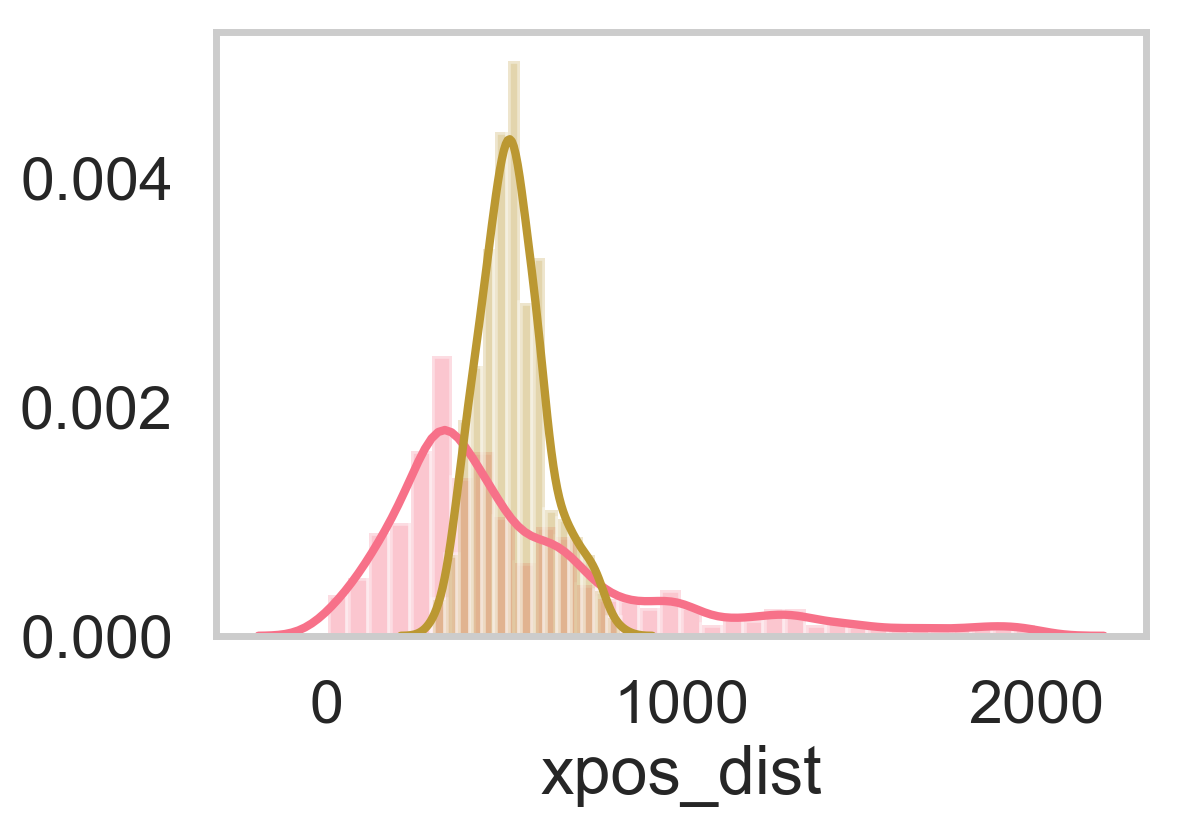

In [30]:
sns.distplot(spacing_y_vals['xpos_distTrue'])
sns.distplot(spacing_imputed_y_vals['xpos_distTrue'])

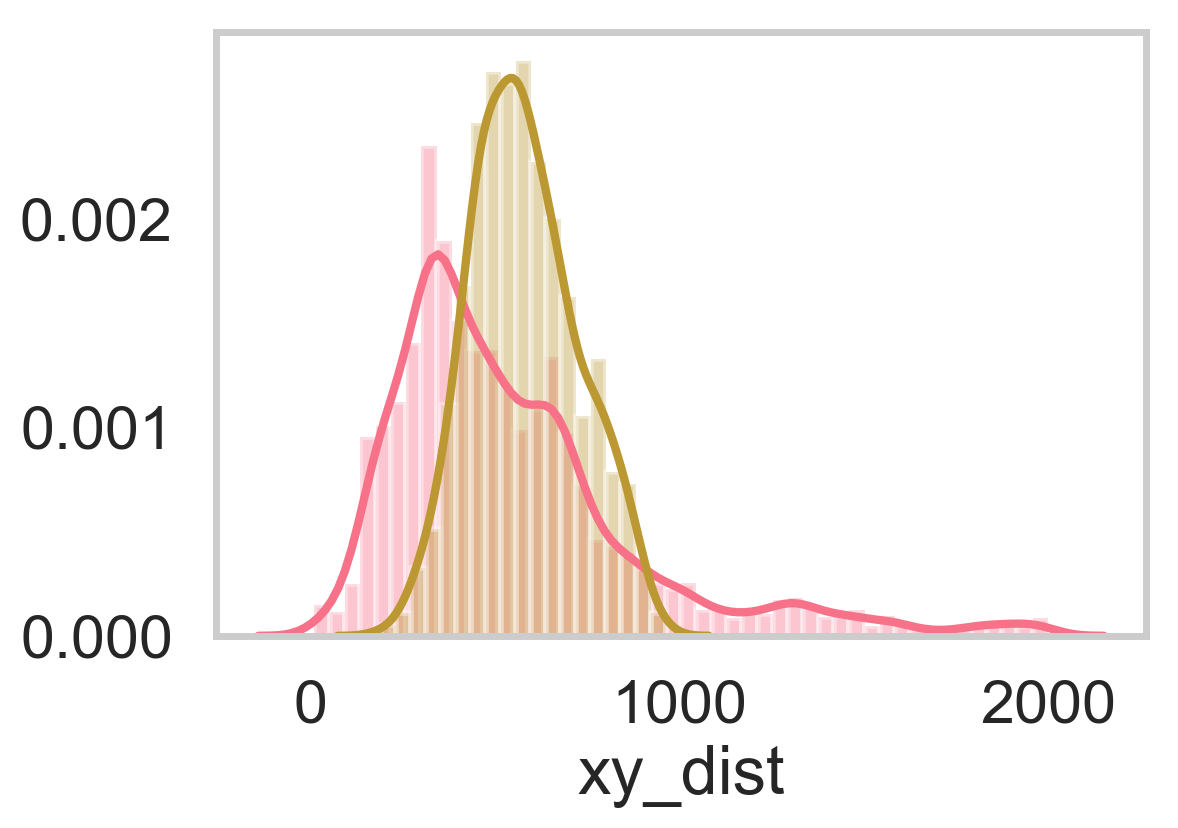

In [31]:
sns.distplot(spacing_y_vals['xy_distFalse'])
sns.distplot(spacing_imputed_y_vals['xy_distFalse'])

In [32]:
df.loc[df.ns_orientation == True, 'main_total_xy_dist'] = (df.loc[df.ns_orientation == True, 'xpos_dist'].copy() -
                                                           df.loc[df.ns_orientation == True, 'xneg_dist'].copy())
df.loc[df.ns_orientation == False, 'main_total_xy_dist'] = (df.loc[df.ns_orientation == False, 'ypos_dist'].copy() -
                                                            df.loc[df.ns_orientation == False, 'yneg_dist'].copy())                                                         

api10                        0
SubPlay                      1
WellID                       0
CompletionID                 0
x_coord                      0
y_coord                      0
x_coord_bh                   0
y_coord_bh                   0
TVD                          0
MD                           0
PerfInterval                 0
FracStages                1243
StageSpacingFT            1251
ProppantPerFT              473
ProppantLBS                459
FluidBBLS                  350
FluidPerFT                 359
OilGravity                1127
MonthsToPeakProduction       0
TotalProducingMonths         0
xmid                         0
xlen                         0
ymid                         0
ylen                         0
zmid                         0
zlen                         0
xy_ratio                     0
z_ratio                      0
xyz_ratio                    0
ns_orientation               0
                          ... 
oil18                        0
gas18   

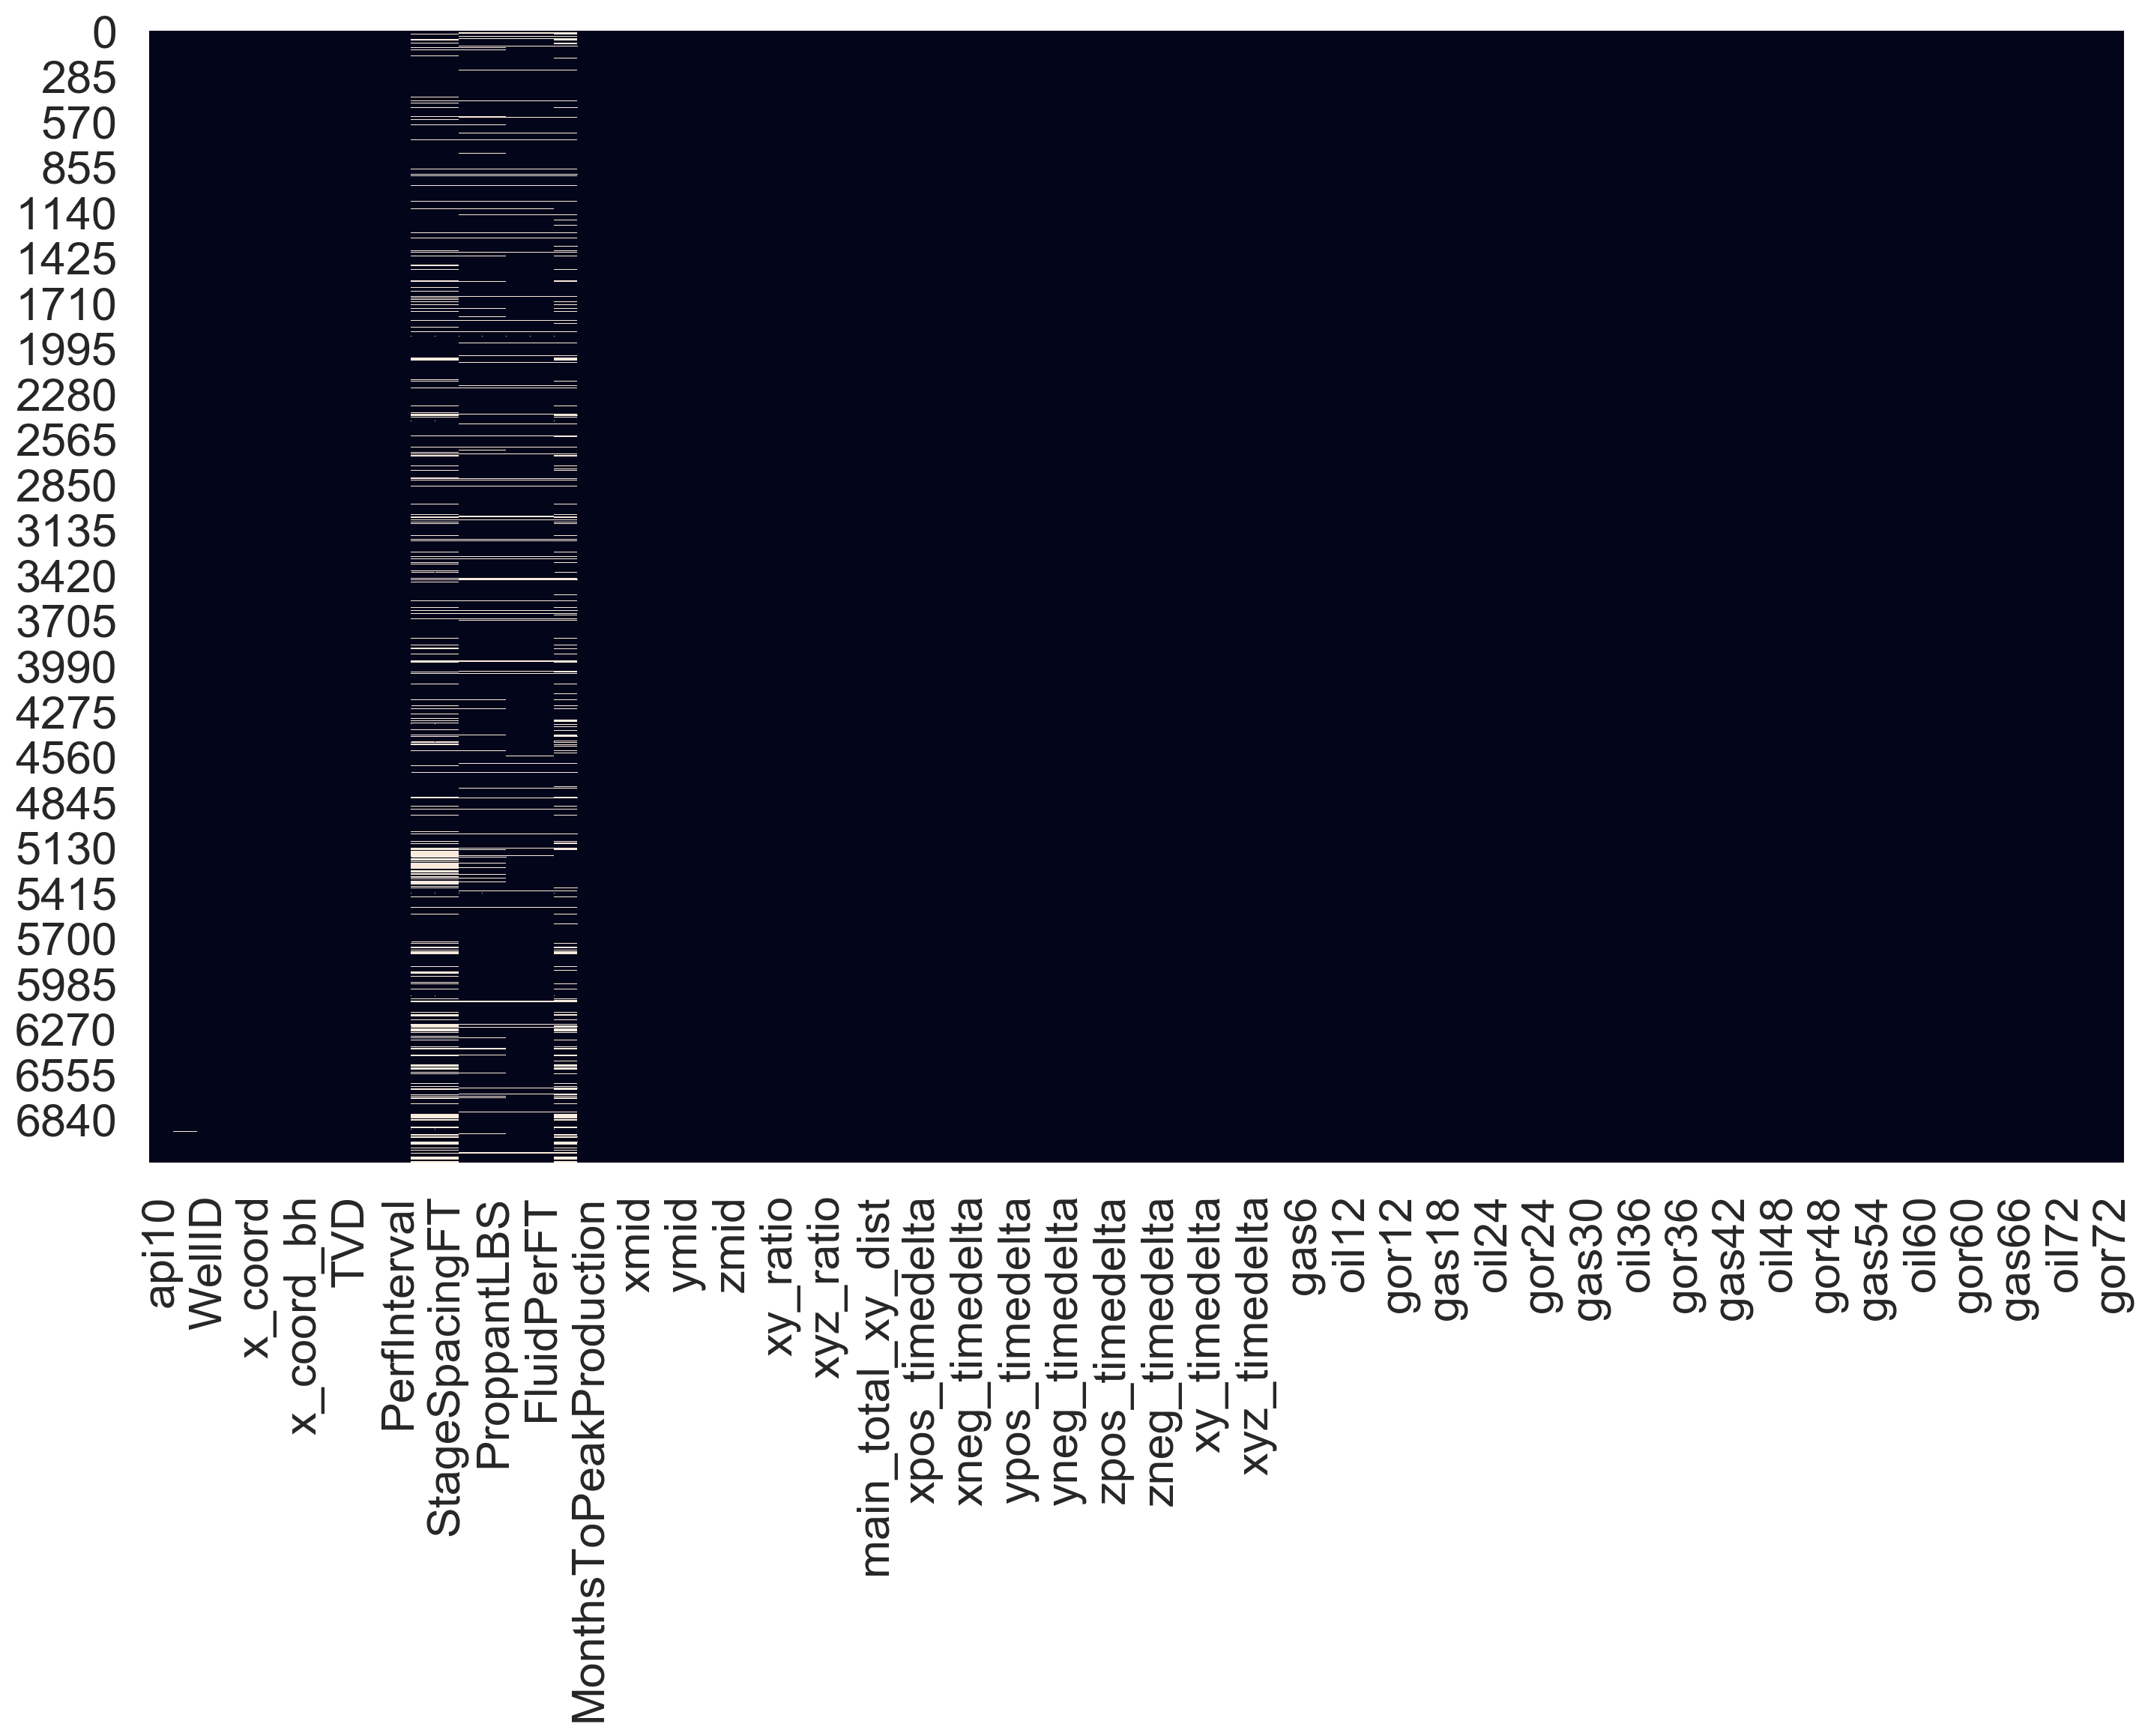

In [33]:
print(df.isna().sum())
plt.figure(figsize=(17, 10))
sns.heatmap(df.isnull(), cbar=False)

### Create dataframe for plotting histograms of features and diagnostic plots

In [34]:
df_pair = df.loc[:, ~df.columns.isin(['api10', 'WellID', 'CompletionID', '30', '60', '90',
                                      '120', '150', '180', '210', '240', '270', '300', '330'])].copy()
df_pair.loc[df_pair.StageSpacingFT > 500, 'StageSpacingFT'] = np.nan
df_pair.loc[df_pair.StageSpacingFT < 50, 'StageSpacingFT'] = np.nan
df_pair = df_pair[df_pair.ProppantPerFT > 500]
df_pair = df_pair[df_pair.ProppantPerFT <3000]
df_pair = df_pair[df_pair.FluidPerFT > 5]
df_pair = df_pair[df_pair.FluidPerFT < 60]
df_pair = df_pair.dropna()

count   4,410.000
mean    1,004.027
std       405.358
min       500.176
25%       772.796
50%       952.943
75%     1,095.183
max     2,969.204
Name: ProppantPerFT, dtype: float64


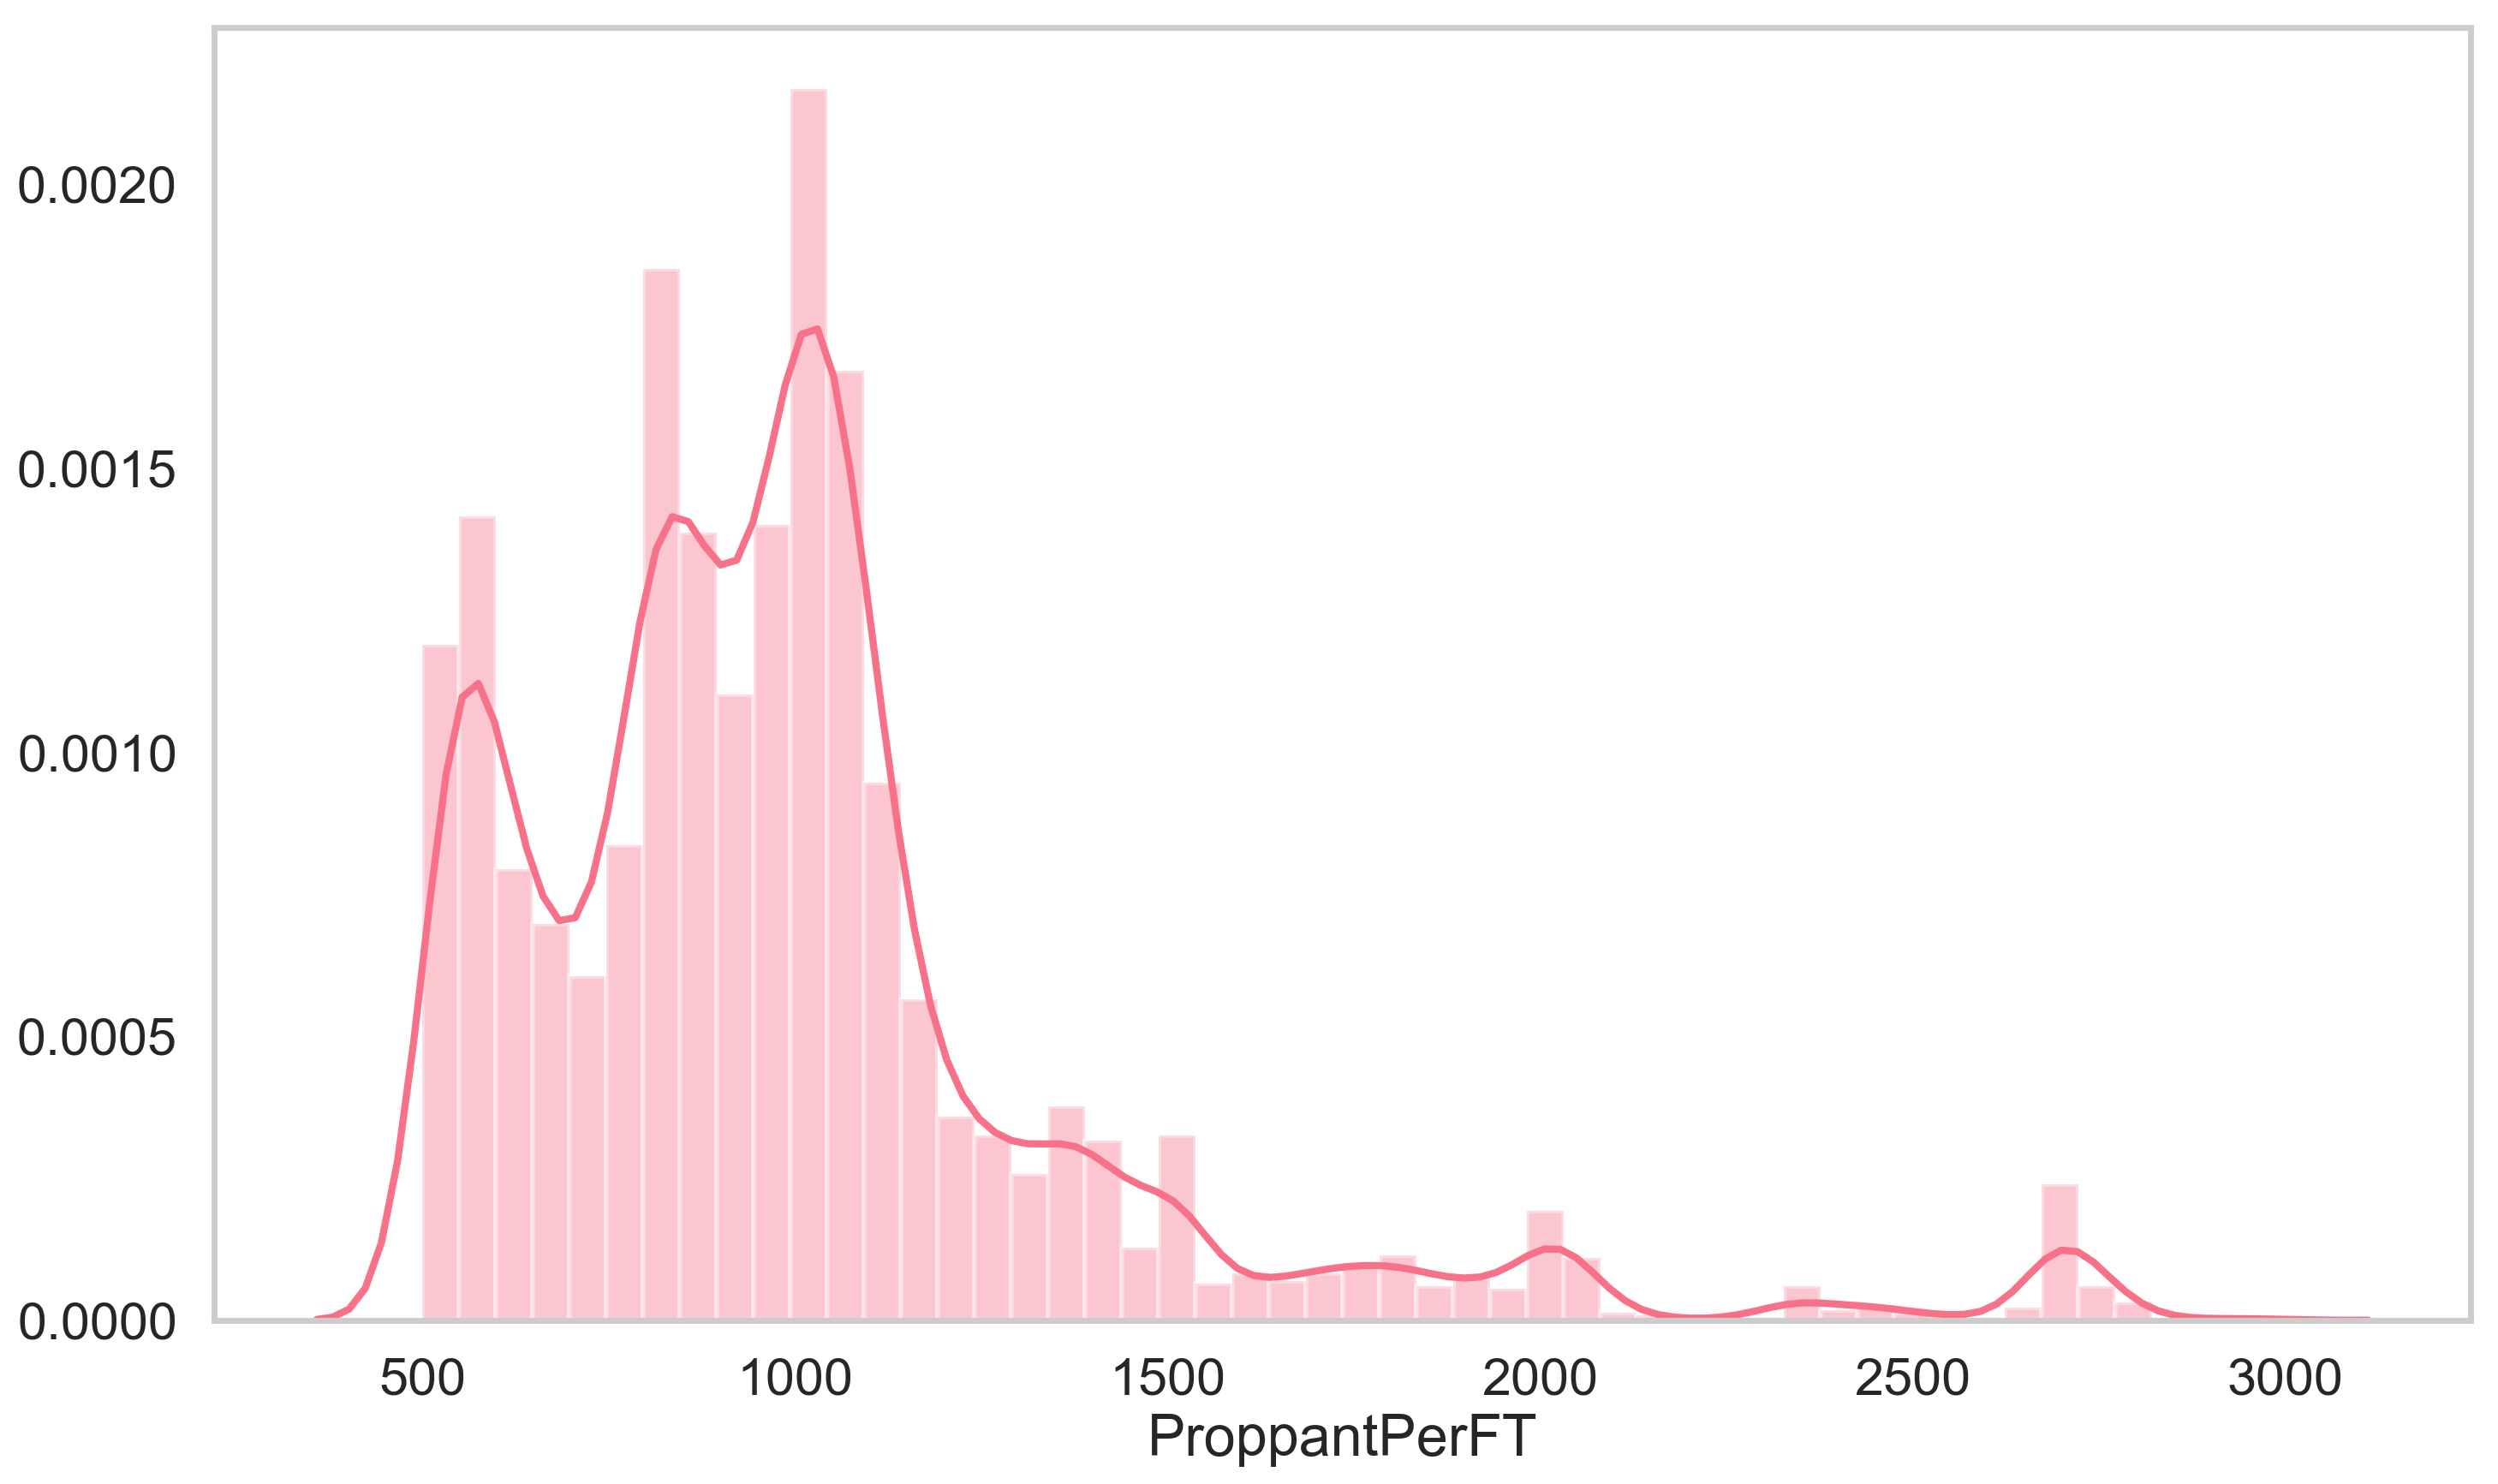

In [35]:
plt.figure(figsize=(17, 10))
sns.distplot(df_pair.ProppantPerFT)
print(df_pair.ProppantPerFT.describe())

count   4,410.000
mean       21.937
std         8.129
min         5.385
25%        16.865
50%        19.966
75%        26.115
max        59.837
Name: FluidPerFT, dtype: float64

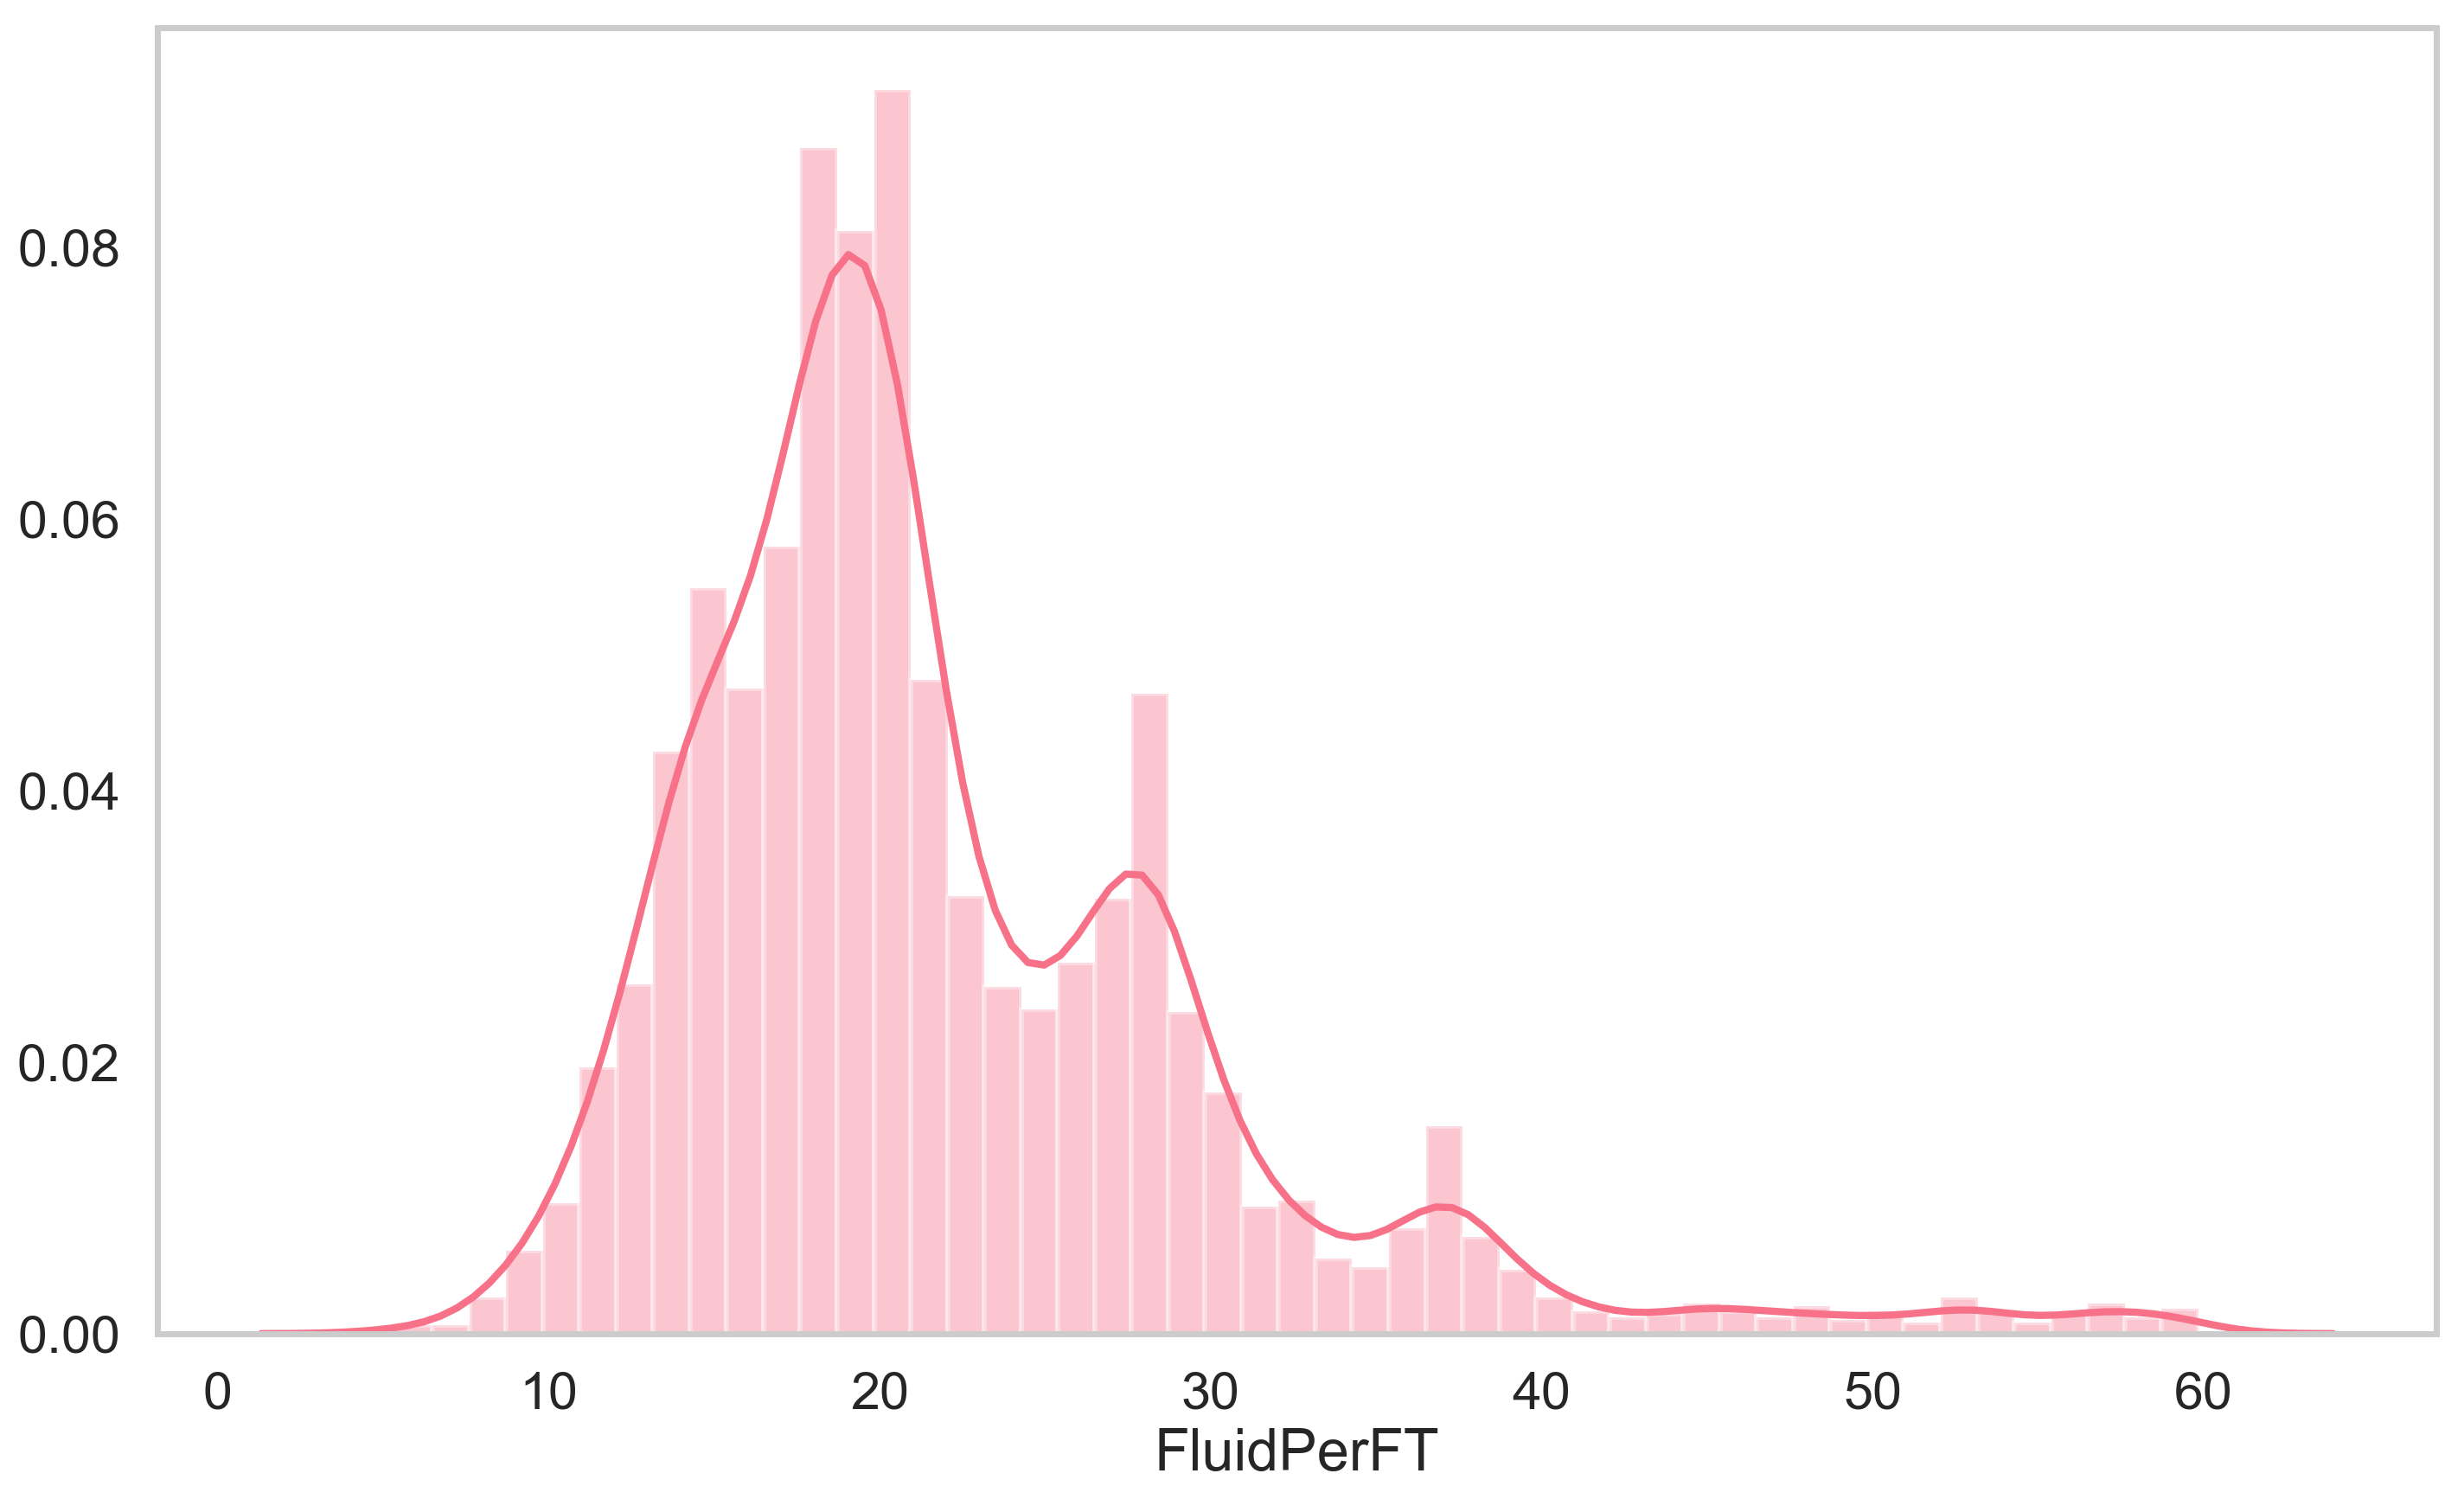

In [36]:
plt.figure(figsize=(17, 10))
sns.distplot(df_pair.FluidPerFT)
df_pair.FluidPerFT.describe()

count   4,410.000
mean       21.937
std         8.129
min         5.385
25%        16.865
50%        19.966
75%        26.115
max        59.837
Name: FluidPerFT, dtype: float64

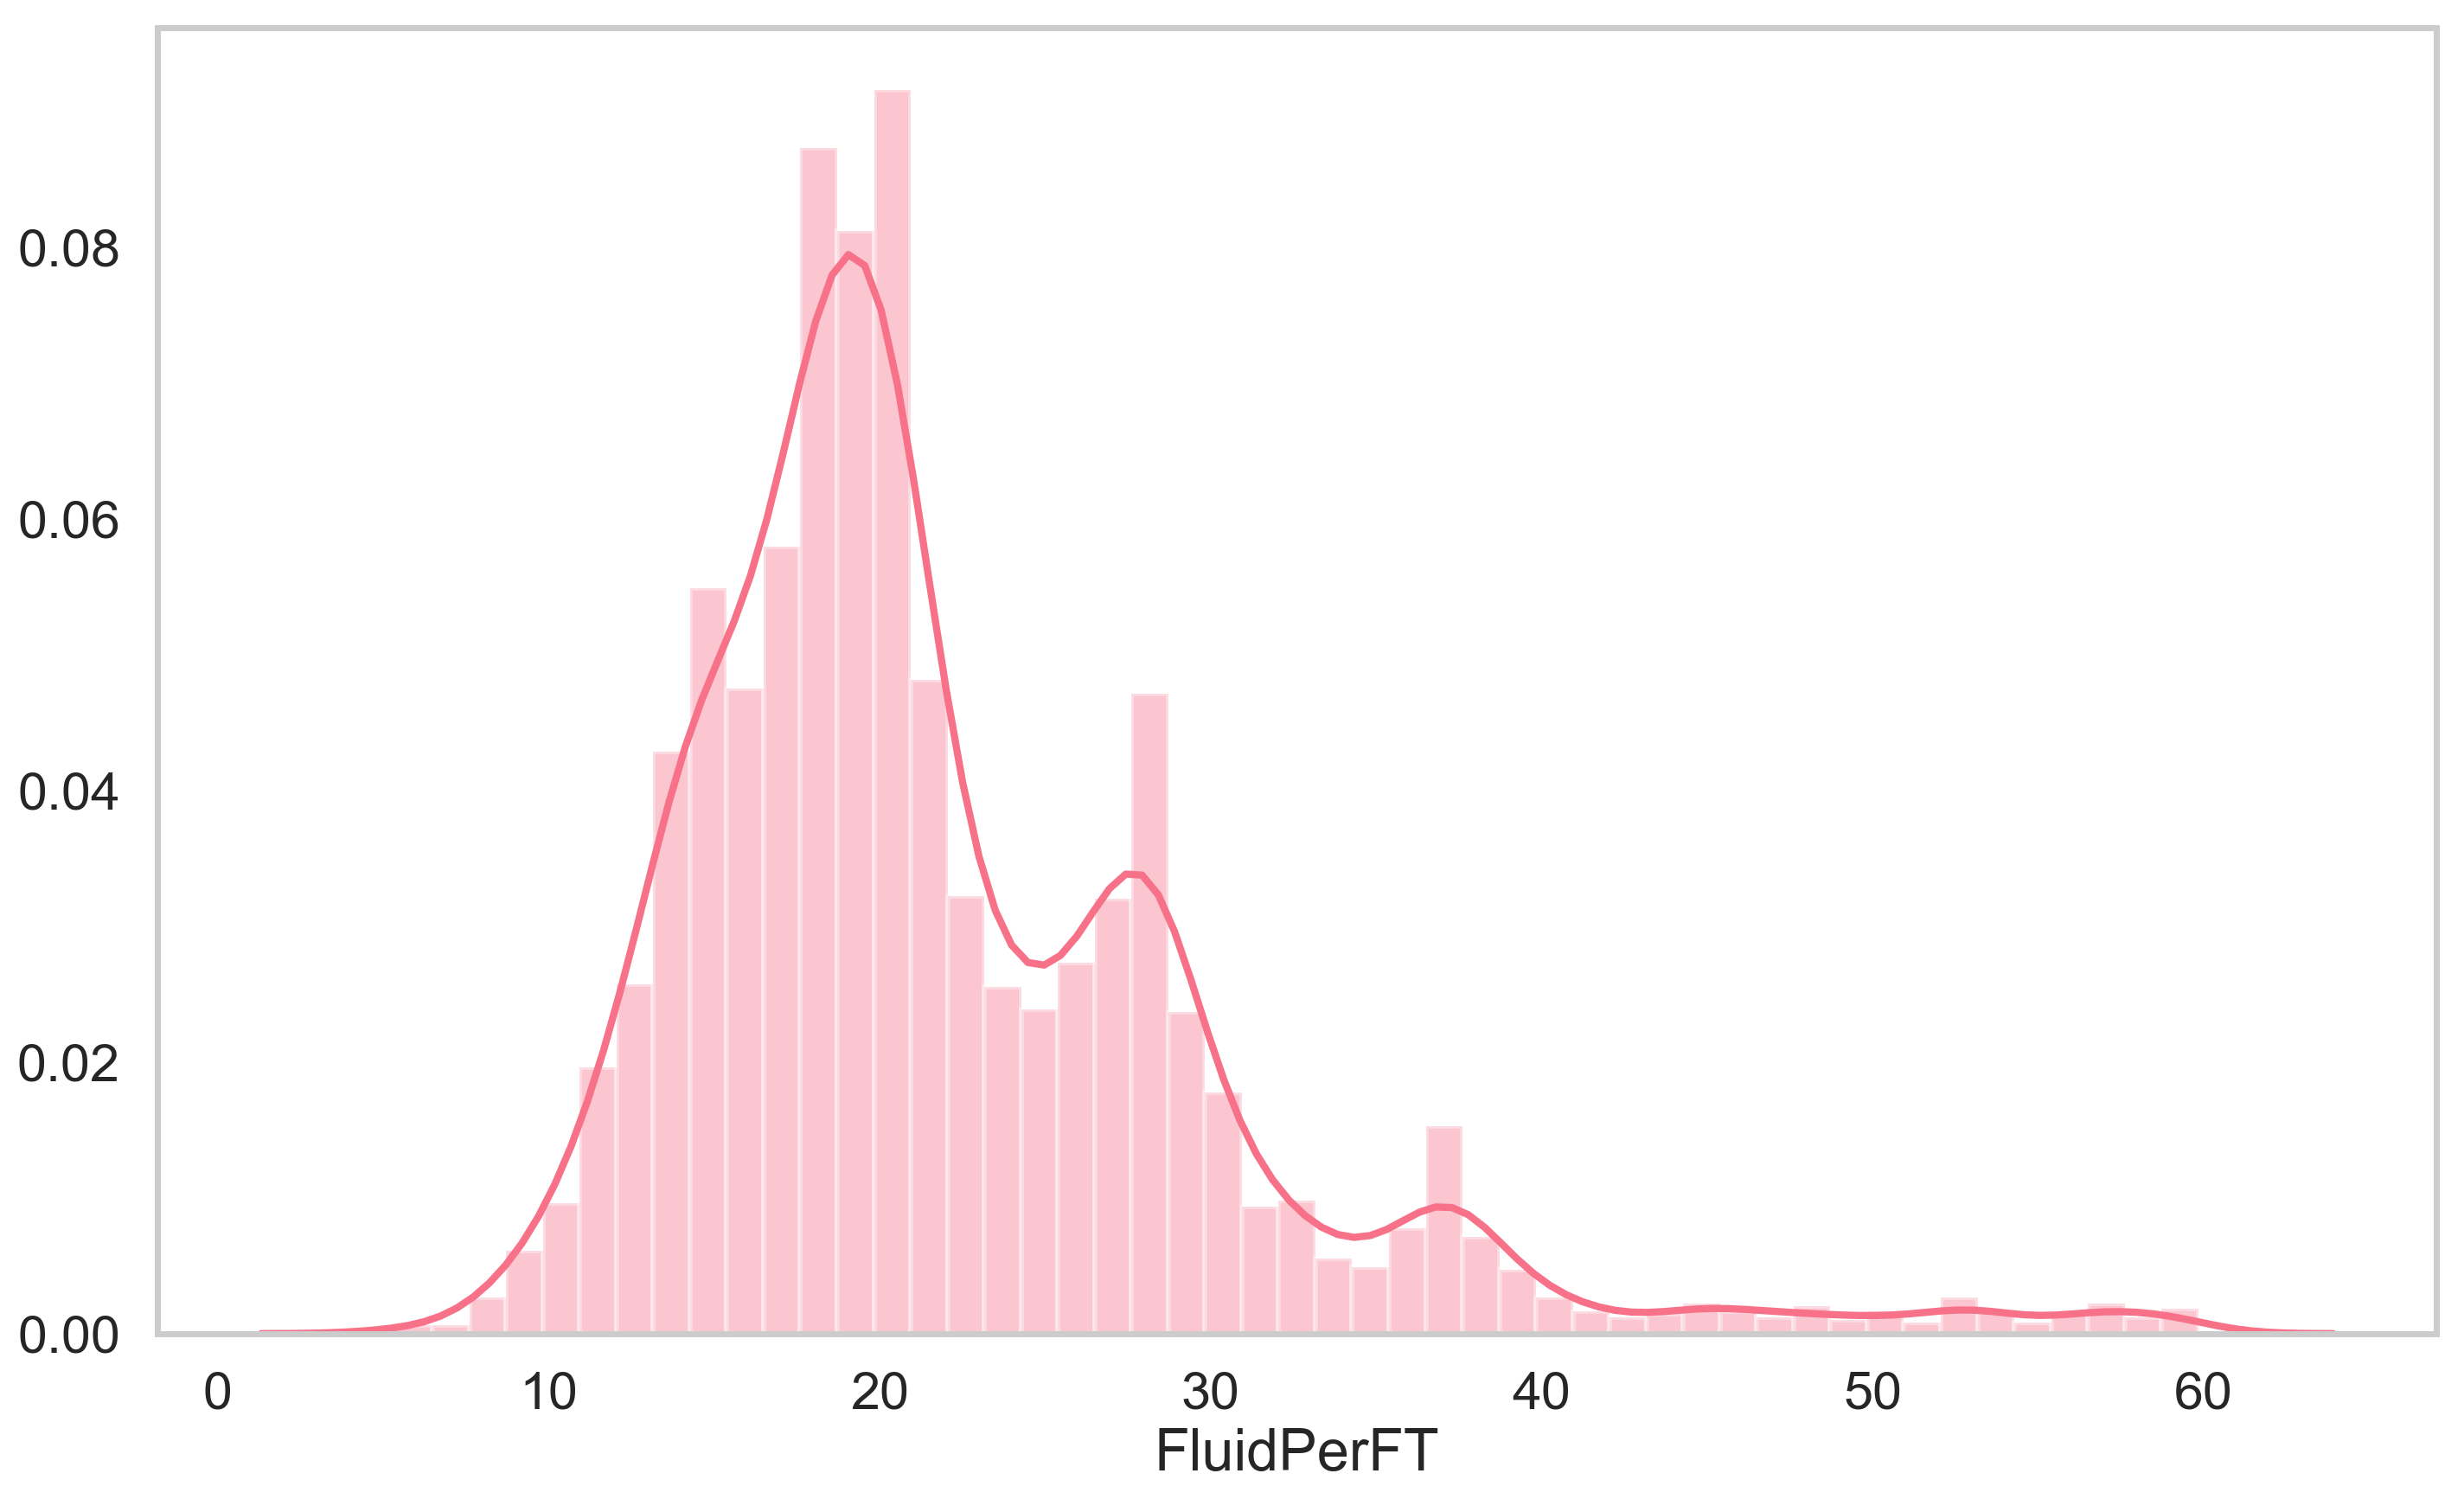

In [37]:
plt.figure(figsize=(17, 10))
sns.distplot(df_pair.FluidPerFT)
df_pair.FluidPerFT.describe()

count   4,410.000
mean       21.937
std         8.129
min         5.385
25%        16.865
50%        19.966
75%        26.115
max        59.837
Name: FluidPerFT, dtype: float64

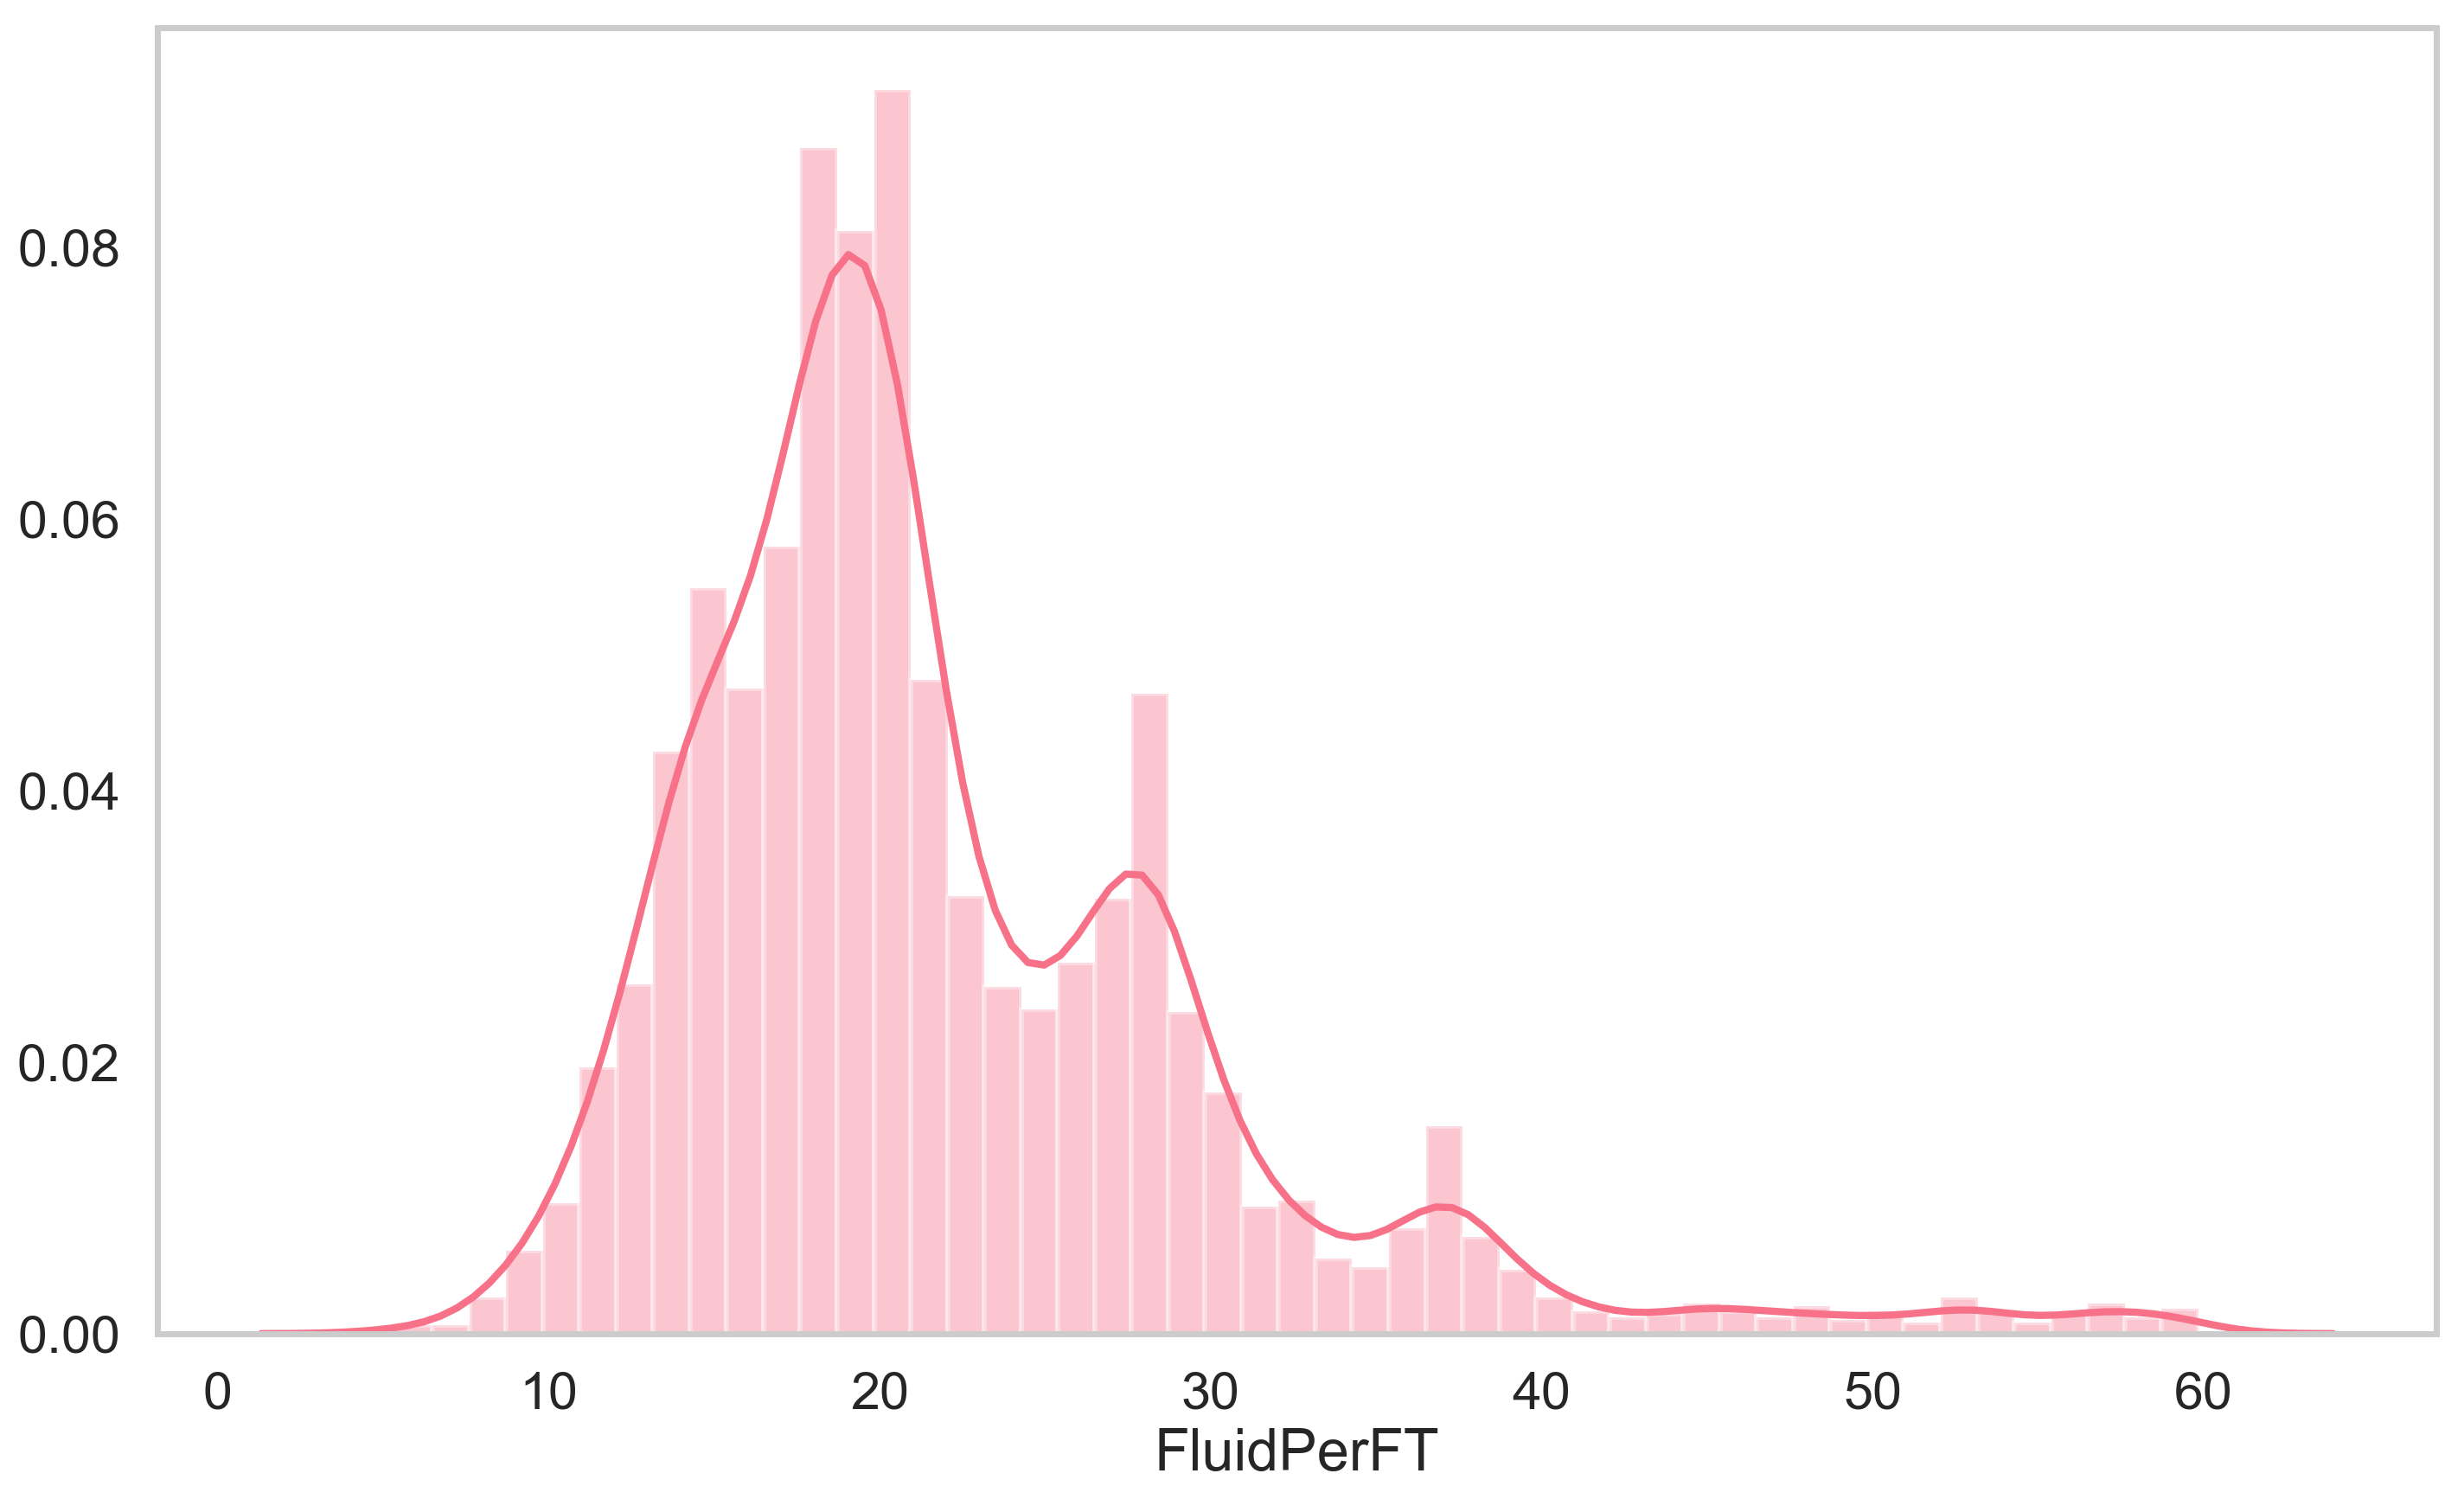

In [38]:
plt.figure(figsize=(17, 10))
sns.distplot(df_pair.FluidPerFT)
df_pair.FluidPerFT.describe()

In [39]:
df_pair.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 4 to 7101
Data columns (total 80 columns):
SubPlay                   4410 non-null object
x_coord                   4410 non-null float64
y_coord                   4410 non-null float64
x_coord_bh                4410 non-null float64
y_coord_bh                4410 non-null float64
TVD                       4410 non-null float64
MD                        4410 non-null float64
PerfInterval              4410 non-null float64
FracStages                4410 non-null float64
StageSpacingFT            4410 non-null float64
ProppantPerFT             4410 non-null float64
ProppantLBS               4410 non-null float64
FluidBBLS                 4410 non-null float64
FluidPerFT                4410 non-null float64
OilGravity                4410 non-null float64
MonthsToPeakProduction    4410 non-null float64
TotalProducingMonths      4410 non-null float64
xmid                      4410 non-null float64
xlen                      4410

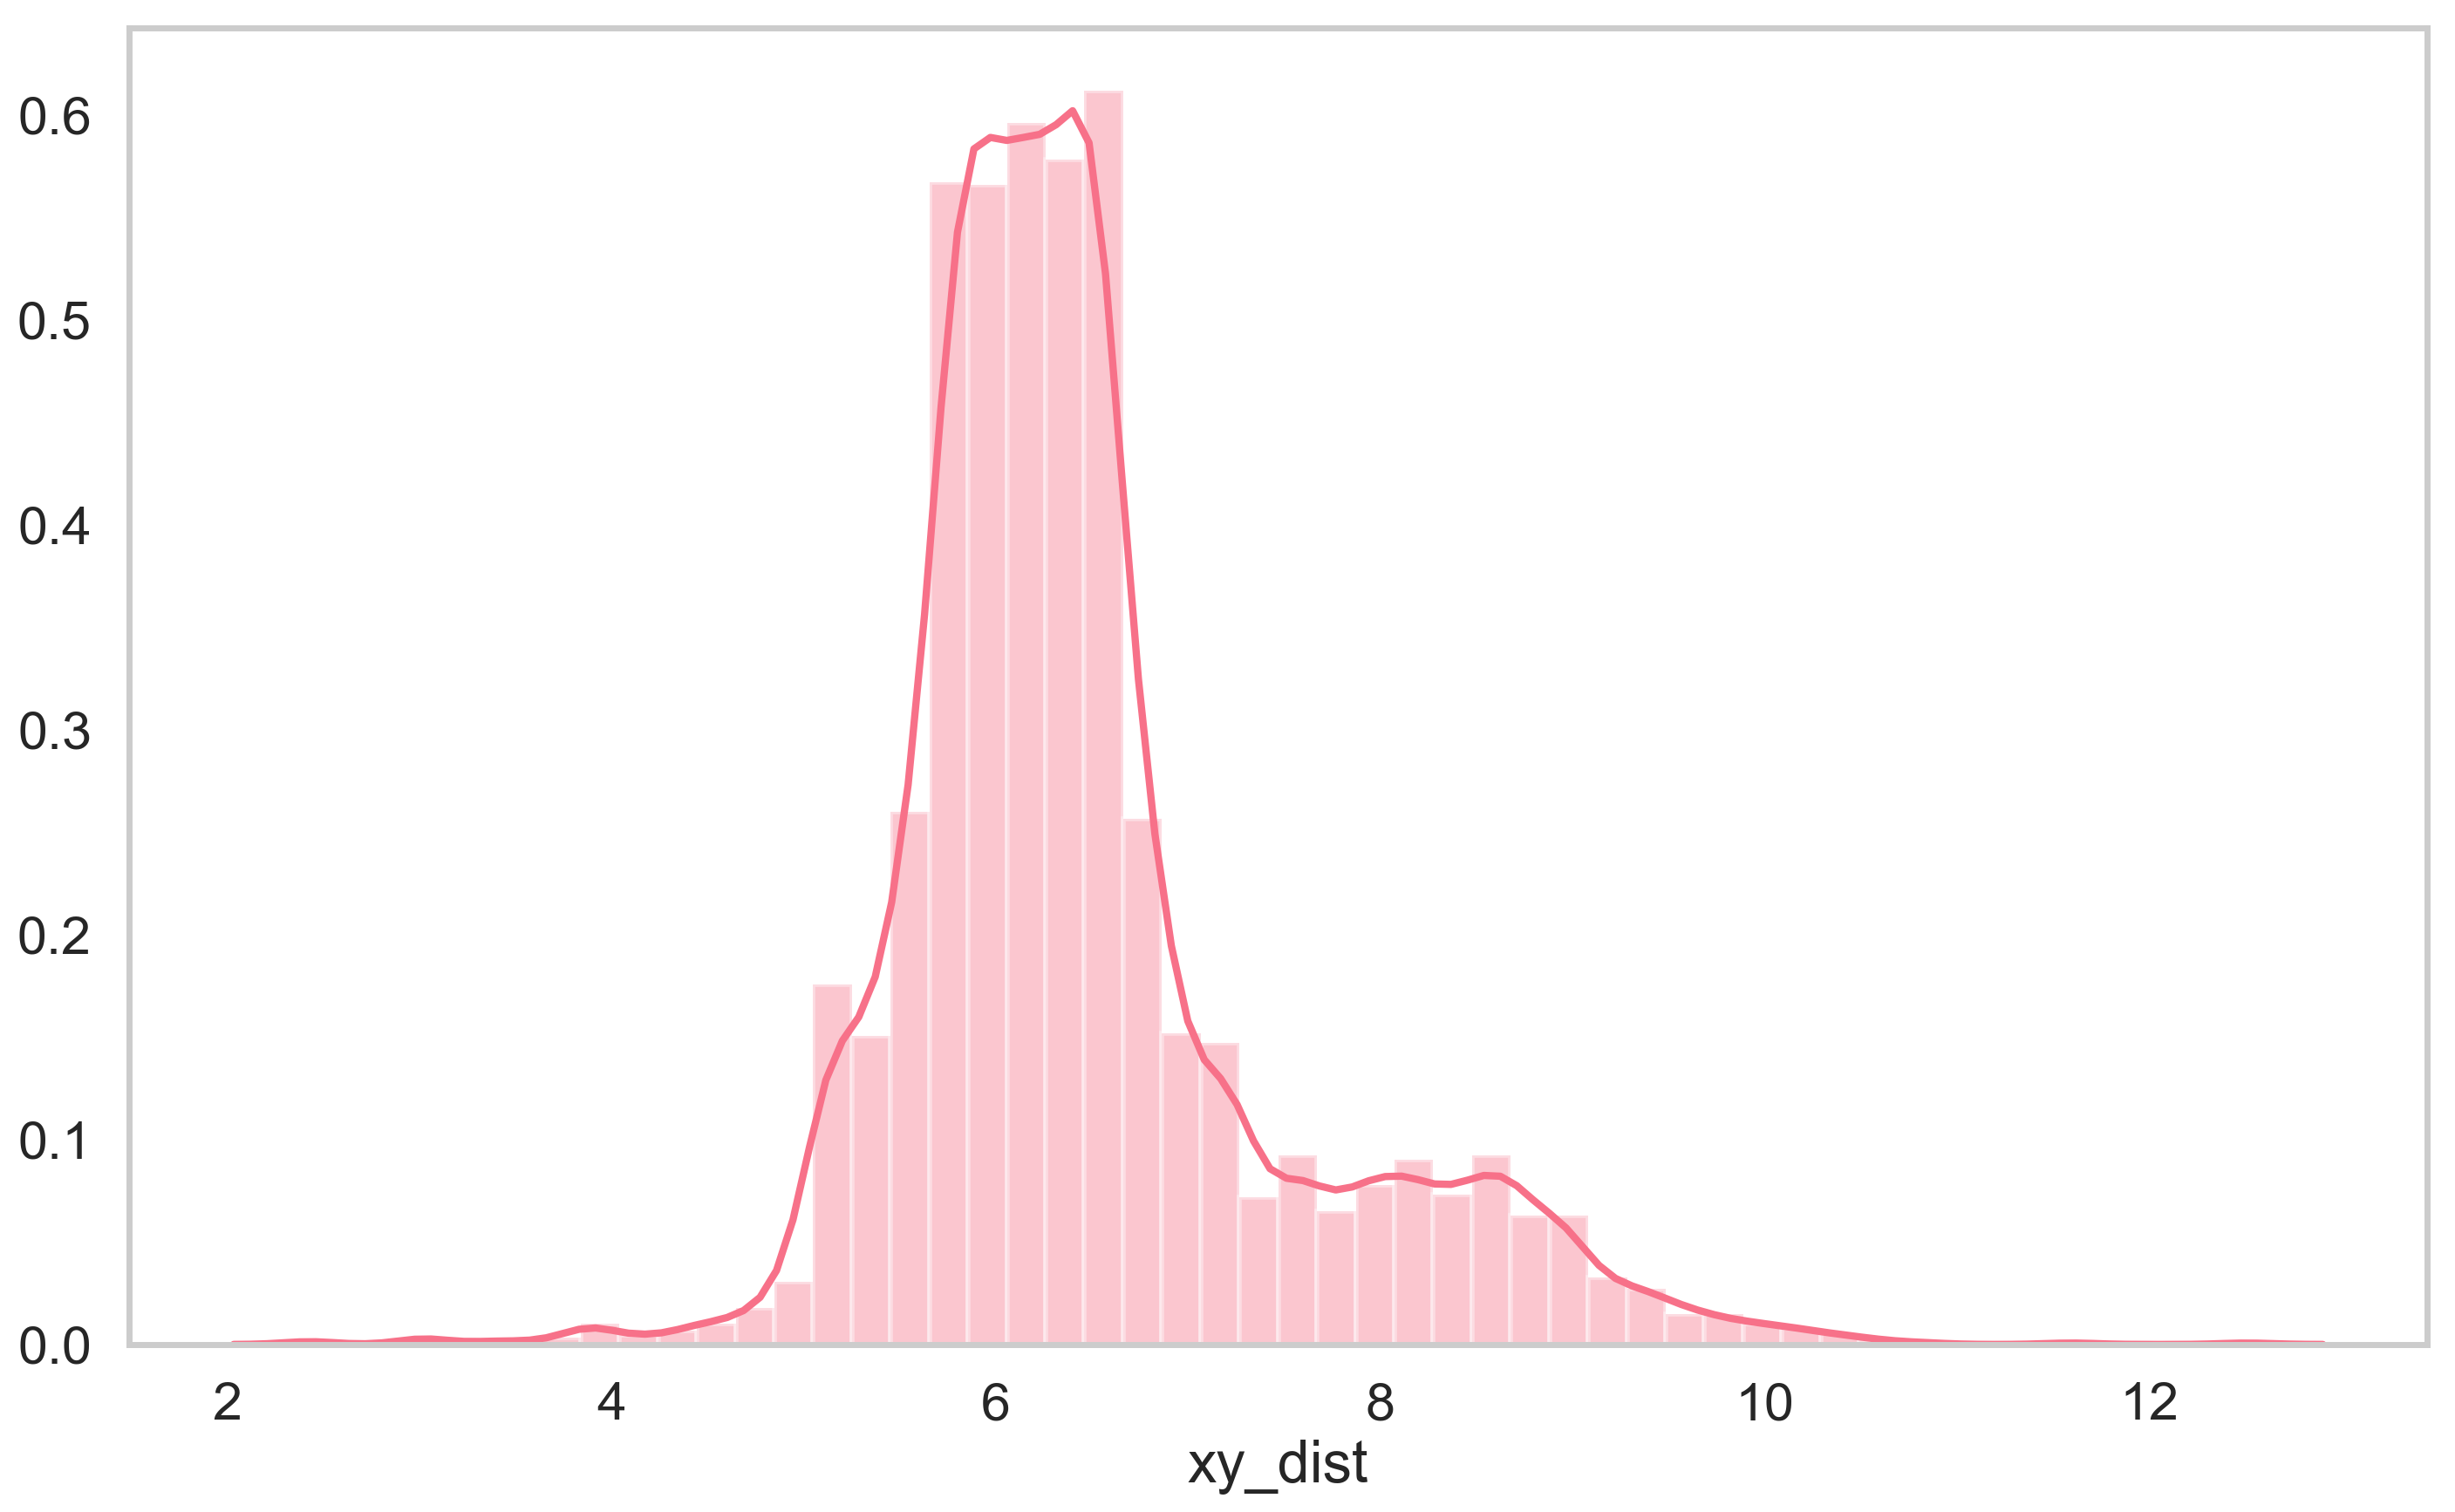

In [40]:
plt.figure(figsize=(17, 10))
sns.distplot(np.log1p(df_pair.xy_dist))

### Review stage spacing, set outliers to nan for imputing

count   4,410.000
mean      194.733
std        50.866
min        55.632
25%       158.486
50%       192.550
75%       213.042
max       488.600
Name: StageSpacingFT, dtype: float64

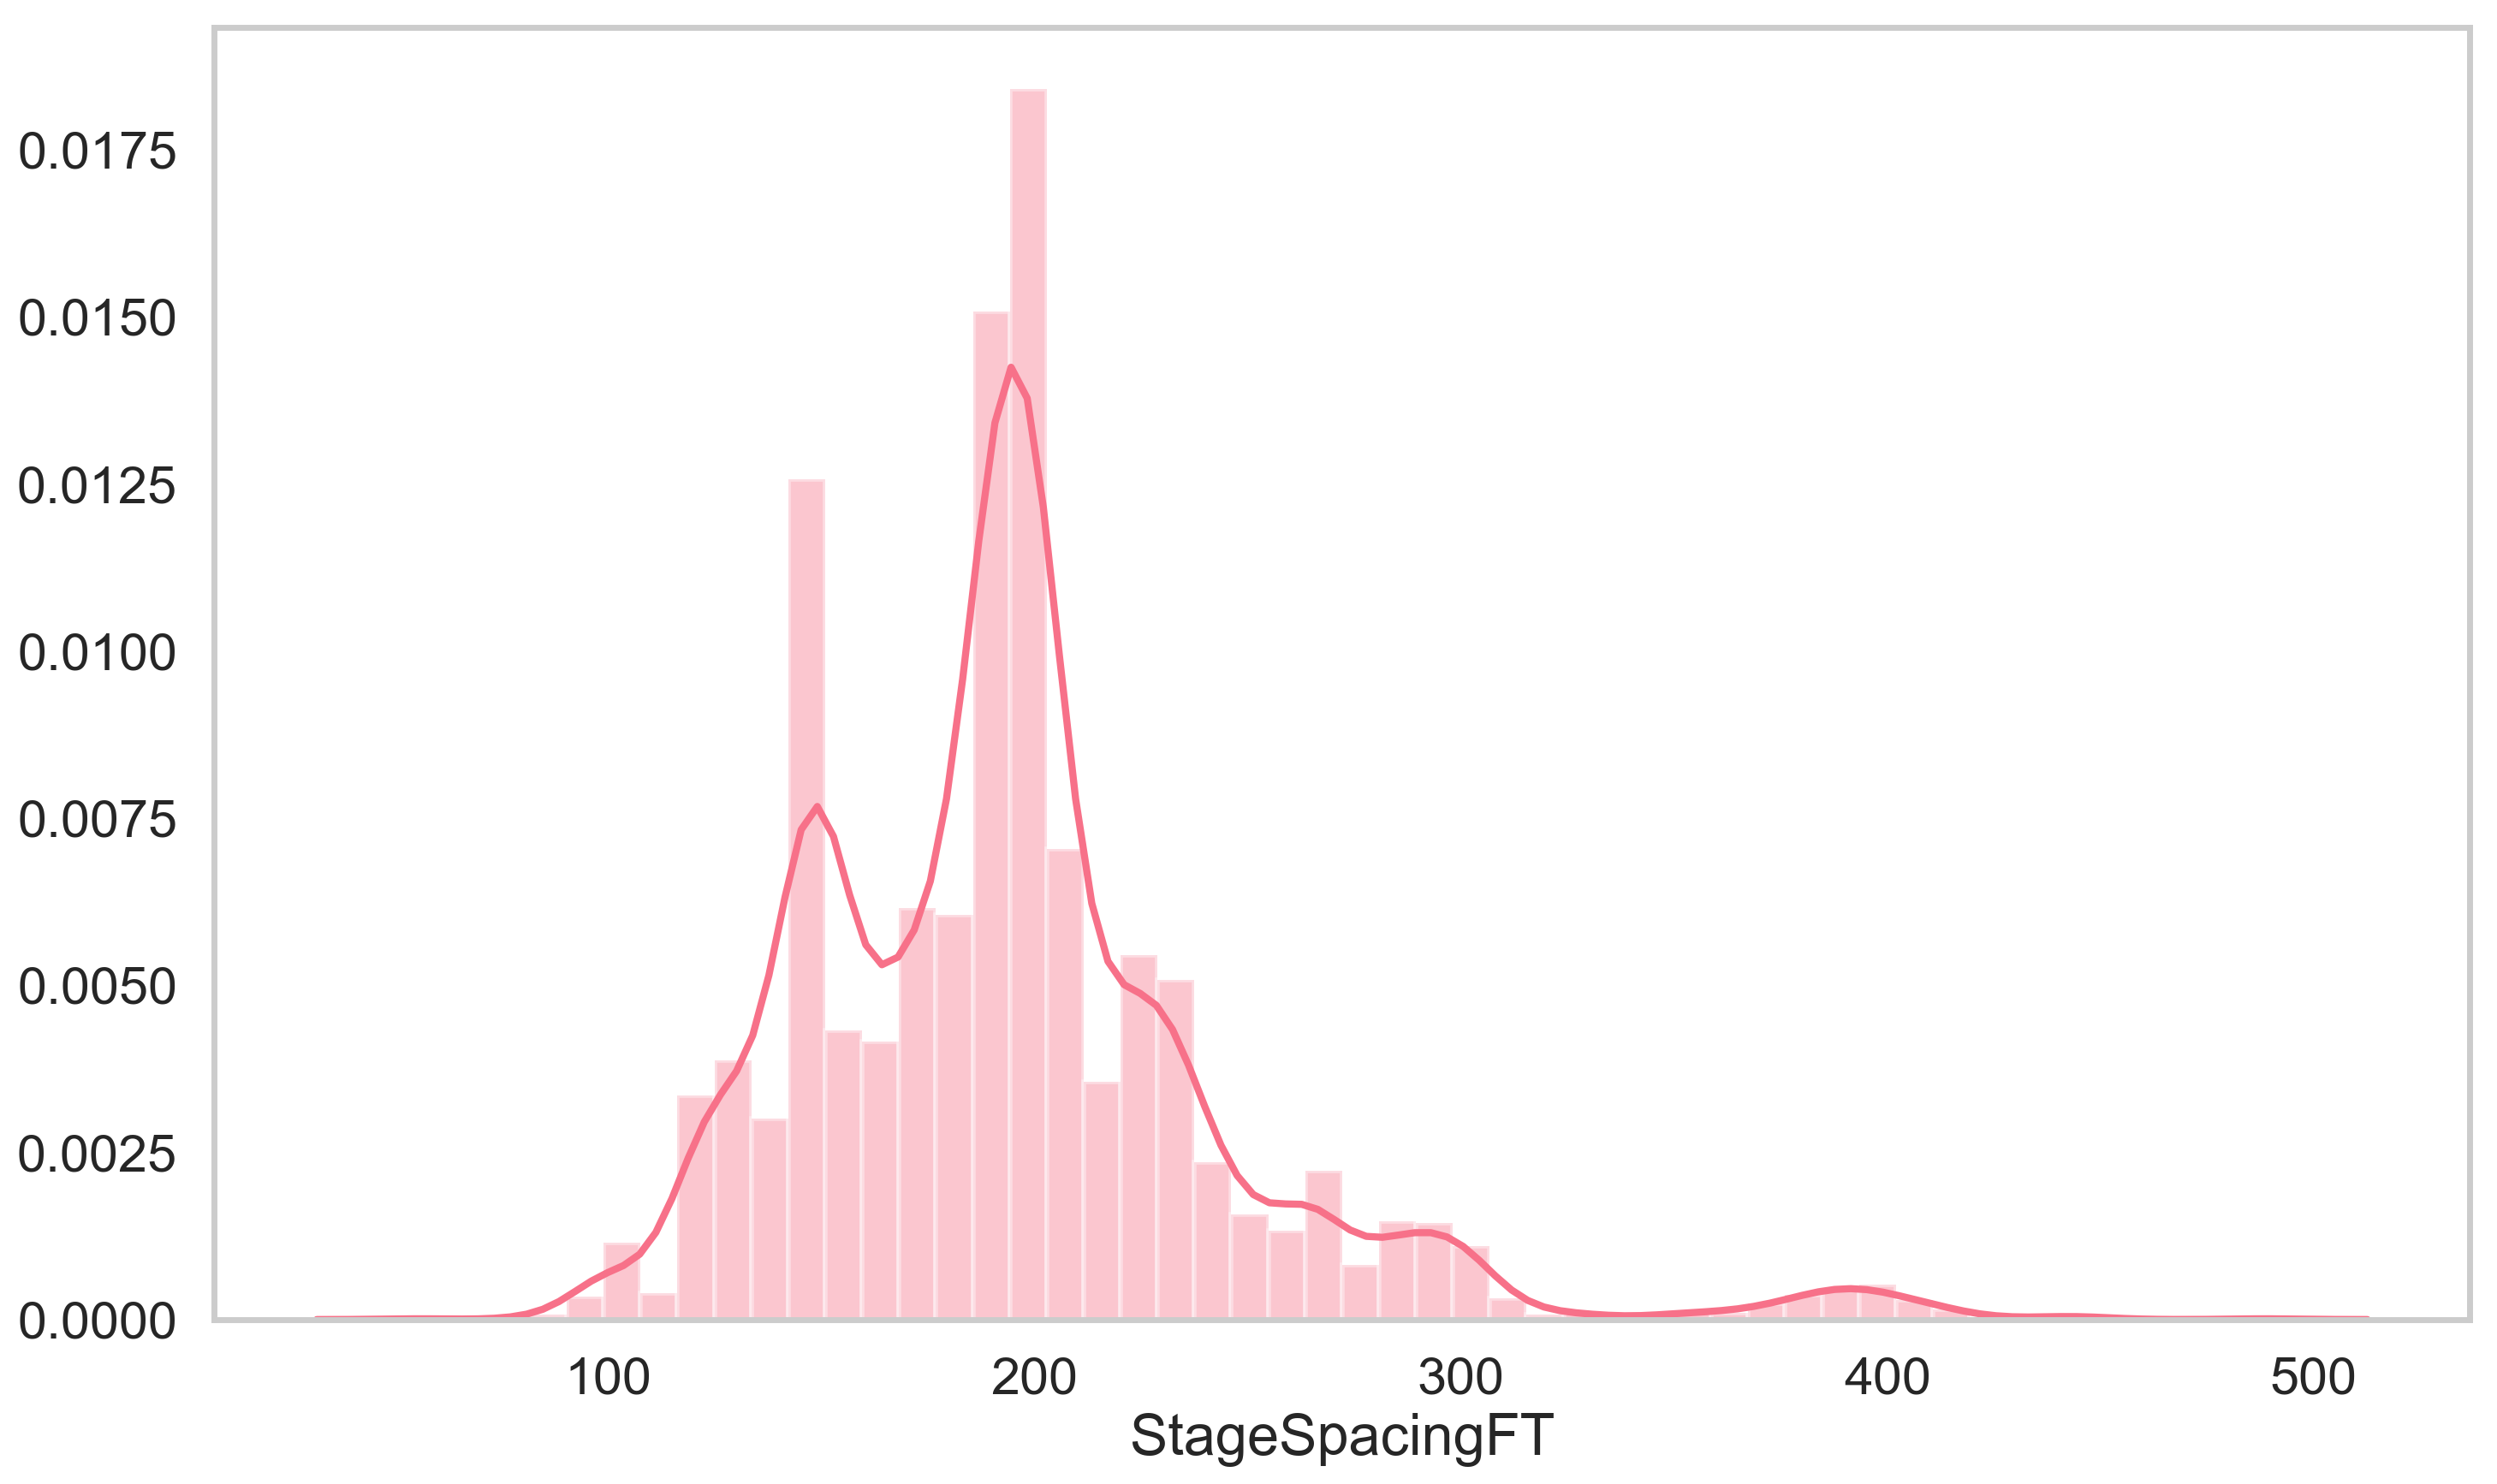

In [41]:
plt.figure(figsize=(17, 10))
sns.distplot(df_pair.StageSpacingFT)
df_pair.StageSpacingFT.describe()

In [42]:
df.loc[((df.StageSpacingFT > 500) | (df.StageSpacingFT < 25)), ['FracStages', 'StageSpacingFT']] = np.nan
df = df[df.ProppantPerFT > 500]
df = df[df.ProppantPerFT < 3000]
df = df[df.FluidPerFT > 5]
df = df[df.FluidPerFT < 100]
df.ProppantLBS = df.ProppantPerFT * df.PerfInterval
df.FluidBBLS = df.FluidPerFT * df.PerfInterval
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 7108
Data columns (total 83 columns):
api10                     5434 non-null object
SubPlay                   5434 non-null object
WellID                    5434 non-null float64
CompletionID              5434 non-null float64
x_coord                   5434 non-null float64
y_coord                   5434 non-null float64
x_coord_bh                5434 non-null float64
y_coord_bh                5434 non-null float64
TVD                       5434 non-null float64
MD                        5434 non-null float64
PerfInterval              5434 non-null float64
FracStages                4613 non-null float64
StageSpacingFT            4613 non-null float64
ProppantPerFT             5434 non-null float64
ProppantLBS               5434 non-null float64
FluidBBLS                 5434 non-null float64
FluidPerFT                5434 non-null float64
OilGravity                4738 non-null float64
MonthsToPeakProduction    5434 

### Impute missing frac fluid

In [43]:
X = df[~pd.isna(df.FluidPerFT)][['x_coord', 'y_coord',
                                 'x_coord_bh', 'y_coord_bh',
                                 'TVD', 'MD', 'PerfInterval',
                                 'ProppantLBS', 'ProppantPerFT',
                                 'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                 'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                 'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                 'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                 'MonthsToPeakProduction',
                                 'TotalProducingMonths', 'xpos_dist', 'xpos_timedelta',
                                 'xneg_dist', 'xneg_timedelta',
                                 'ypos_dist', 'ypos_timedelta',
                                 'yneg_dist', 'yneg_timedelta',
                                 'zpos_dist', 'zpos_timedelta',
                                 'zneg_dist', 'zneg_timedelta',
                                 'xy_dist', 'xy_timedelta',
                                 'xyz_dist', 'xyz_timedelta'
                                ]]
y = df[~pd.isna(df.FluidPerFT)]['FluidPerFT']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
missing_x = df.loc[pd.isna(df.FluidPerFT), ['x_coord', 'y_coord',
                                            'x_coord_bh', 'y_coord_bh',
                                            'TVD', 'MD', 'PerfInterval',
                                            'ProppantLBS', 'ProppantPerFT',
                                            'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                            'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                            'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                            'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                            'MonthsToPeakProduction',
                                            'TotalProducingMonths', 'xpos_dist', 'xpos_timedelta',
                                            'xneg_dist', 'xneg_timedelta',
                                            'ypos_dist', 'ypos_timedelta',
                                            'yneg_dist', 'yneg_timedelta',
                                            'zpos_dist', 'zpos_timedelta',
                                            'zneg_dist', 'zneg_timedelta',
                                            'xy_dist', 'xy_timedelta',
                                            'xyz_dist', 'xyz_timedelta'
                                            ]]
missing_x = missing_x.dropna()
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Missing x shape:', missing_x.shape)
if missing_x.shape[0] == 0:
    print('no x values to use for prediction')
else:
    try:
        gb_random = joblib.load('fluid.pkl')
    except:
        gb = xgb.XGBRegressor()
        gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
        gb_random.fit(X_train, y_train)
        joblib.dump(gb_random, 'fluid.pkl')
    print(f, o, 'Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
    print(f, o, 'Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
    print(gb_random.best_params_)
    if missing_x.shape[0] == 0:
        print('no missing values to impute.')
    else:
        imputed_y = np.transpose(gb_random.predict(missing_x))
        df.loc[missing_x.index, 'FluidPerFT'] = imputed_y

X shape: (5434, 51)
y shape: (5434,)
Missing x shape: (0, 51)
no x values to use for prediction


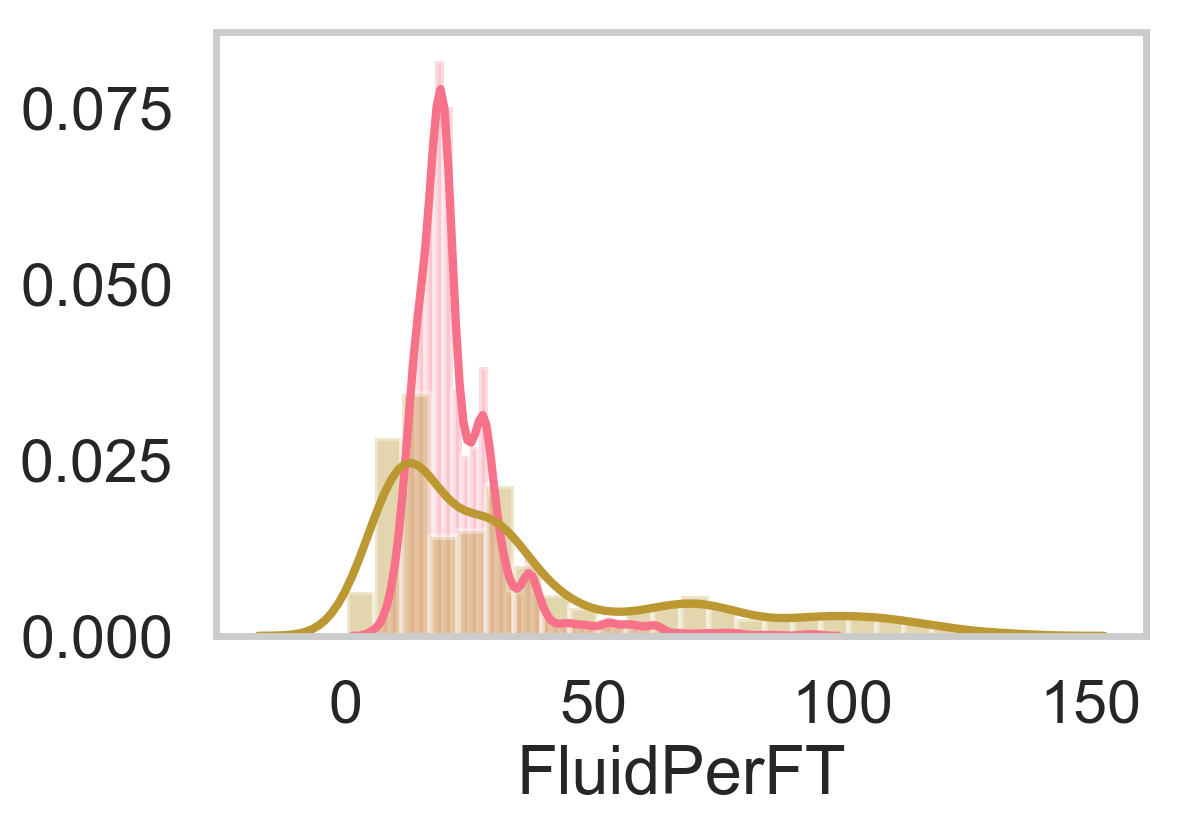

In [44]:
sns.distplot(y)
sns.distplot(imputed_y)

In [45]:
df.FluidBBLS = df.FluidPerFT * df.PerfInterval
df['ProppantConcentration'] = df.ProppantLBS / df.FluidBBLS
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 7108
Data columns (total 84 columns):
api10                     5434 non-null object
SubPlay                   5434 non-null object
WellID                    5434 non-null float64
CompletionID              5434 non-null float64
x_coord                   5434 non-null float64
y_coord                   5434 non-null float64
x_coord_bh                5434 non-null float64
y_coord_bh                5434 non-null float64
TVD                       5434 non-null float64
MD                        5434 non-null float64
PerfInterval              5434 non-null float64
FracStages                4613 non-null float64
StageSpacingFT            4613 non-null float64
ProppantPerFT             5434 non-null float64
ProppantLBS               5434 non-null float64
FluidBBLS                 5434 non-null float64
FluidPerFT                5434 non-null float64
OilGravity                4738 non-null float64
MonthsToPeakProduction    5434 

### Impute missing stage spacing

In [46]:
X = df[~pd.isna(df.StageSpacingFT)][['x_coord', 'y_coord',
                                 'x_coord_bh', 'y_coord_bh',
                                 'TVD', 'MD', 'PerfInterval',
                                 'ProppantLBS', 'ProppantPerFT',
                                 'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                 'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                 'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                 'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                 'MonthsToPeakProduction',
                                 'TotalProducingMonths', 'xpos_dist', 'xpos_timedelta',
                                 'xneg_dist', 'xneg_timedelta',
                                 'ypos_dist', 'ypos_timedelta',
                                 'yneg_dist', 'yneg_timedelta',
                                 'zpos_dist', 'zpos_timedelta',
                                 'zneg_dist', 'zneg_timedelta',
                                 'xy_dist', 'xy_timedelta',
                                 'xyz_dist', 'xyz_timedelta'
                                ]]
y = df[~pd.isna(df.StageSpacingFT)]['StageSpacingFT']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
missing_x = df.loc[pd.isna(df.StageSpacingFT), ['x_coord', 'y_coord',
                                            'x_coord_bh', 'y_coord_bh',
                                            'TVD', 'MD', 'PerfInterval',
                                            'ProppantLBS', 'ProppantPerFT',
                                            'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                            'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                            'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                            'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                            'MonthsToPeakProduction',
                                            'TotalProducingMonths', 'xpos_dist', 'xpos_timedelta',
                                            'xneg_dist', 'xneg_timedelta',
                                            'ypos_dist', 'ypos_timedelta',
                                            'yneg_dist', 'yneg_timedelta',
                                            'zpos_dist', 'zpos_timedelta',
                                            'zneg_dist', 'zneg_timedelta',
                                            'xy_dist', 'xy_timedelta',
                                            'xyz_dist', 'xyz_timedelta'
                                            ]]
missing_x = missing_x.dropna()
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Missing x shape:', missing_x.shape)
if missing_x.shape[0] == 0:
    print('no x values to use for prediction')
else:
    try:
        gb_random = joblib.load('stage_spacing.pkl')
    except:
        gb = xgb.XGBRegressor()
        gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
        gb_random.fit(X_train, y_train)
        joblib.dump(gb_random, 'stage_spacing.pkl')
    print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
    print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
    print(gb_random.best_params_)
    if missing_x.shape[0] == 0:
        print('no missing values to impute.')
    else:
        imputed_y = np.transpose(gb_random.predict(missing_x))
        df.loc[missing_x.index, 'StageSpacingFT'] = imputed_y

X shape: (4613, 51)
y shape: (4613,)
Missing x shape: (821, 51)
Training score: 0.85
Test score: 0.58
{'subsample': 0.7777777777777778, 'reg_lambda': 49.770235643321136, 'reg_alpha': 37.64935806792467, 'n_estimators': 2100, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.036282828282828285, 'gamma': 0.08111308307896868, 'colsample_bytree': 0.8611111111111112, 'colsample_bylevel': 0.9166666666666666}


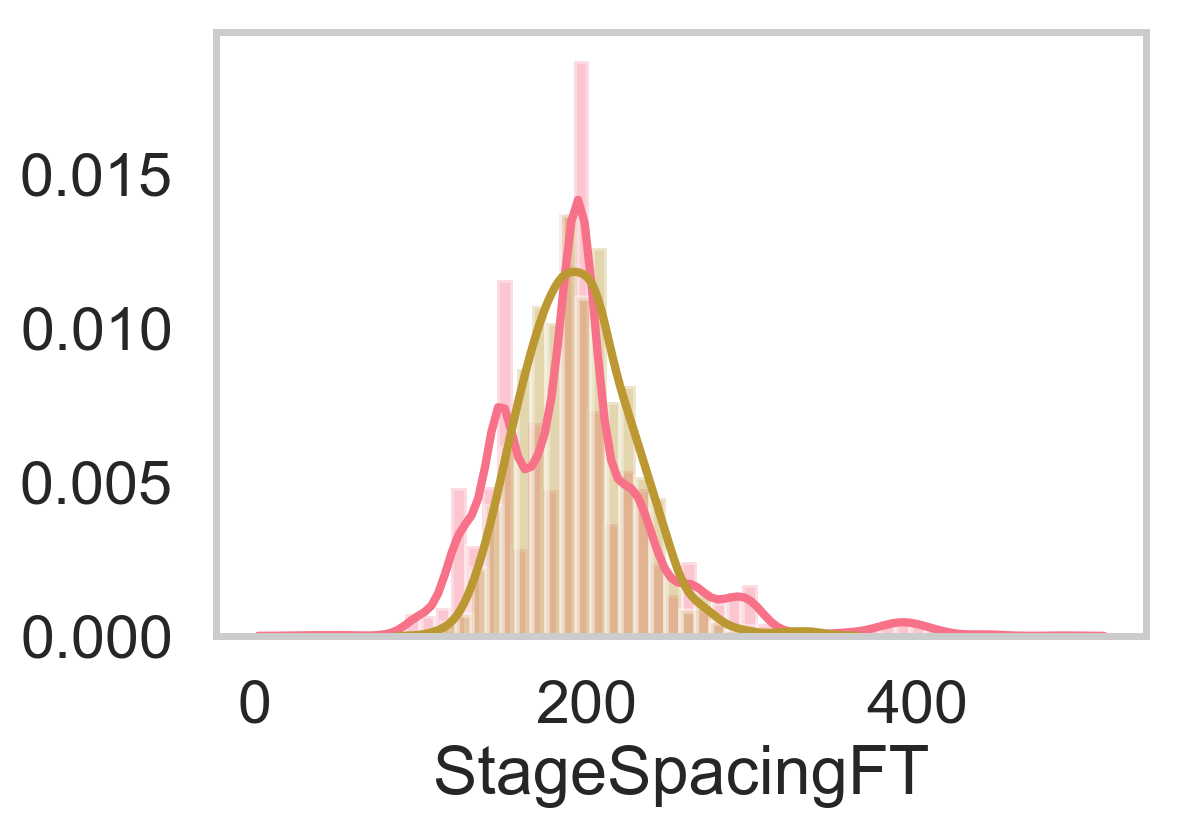

In [47]:
sns.distplot(y)
sns.distplot(imputed_y)

[<matplotlib.lines.Line2D at 0x1188bd240>]

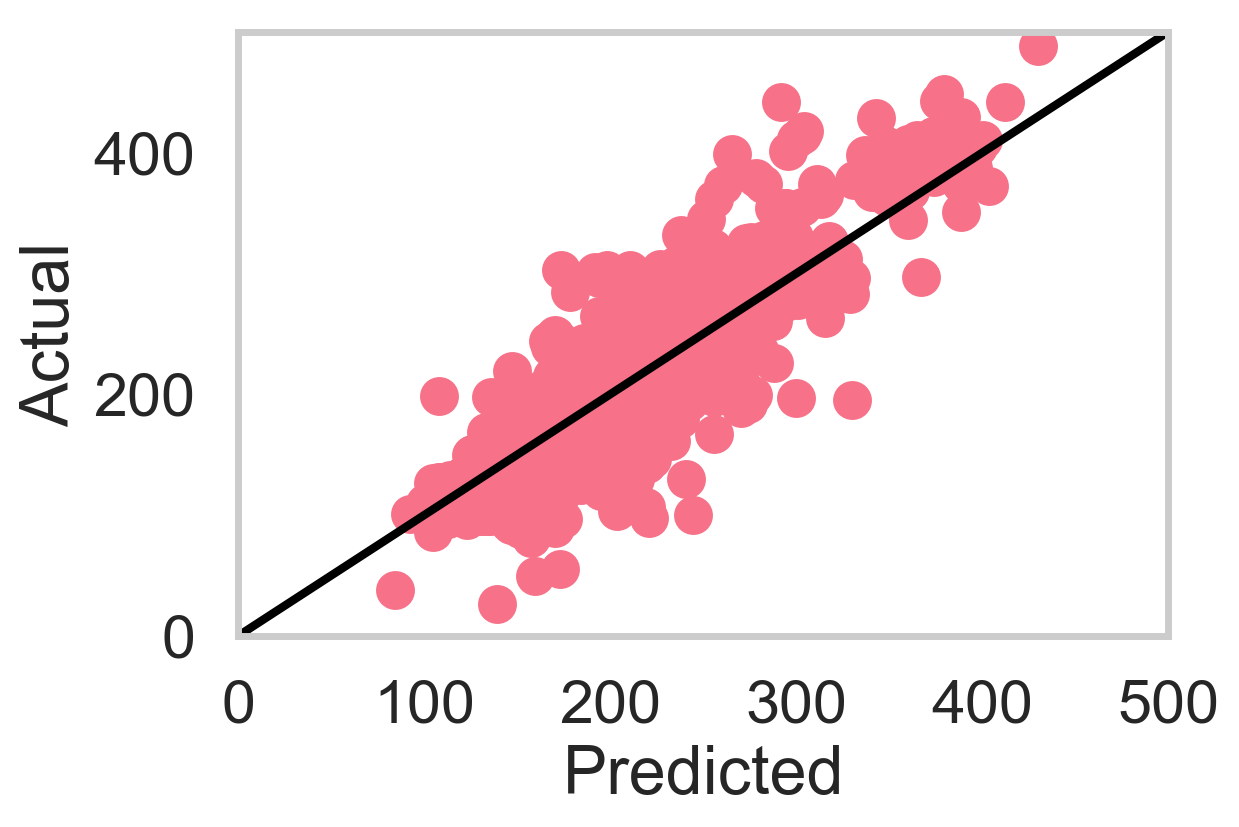

In [48]:
y_pred = gb_random.predict(X)
plt.scatter(y_pred, y)
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([0, 500], [0, 500], c='k')

In [49]:
df['FracStages'] = df['PerfInterval'] / df['StageSpacingFT']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 7108
Data columns (total 84 columns):
api10                     5434 non-null object
SubPlay                   5434 non-null object
WellID                    5434 non-null float64
CompletionID              5434 non-null float64
x_coord                   5434 non-null float64
y_coord                   5434 non-null float64
x_coord_bh                5434 non-null float64
y_coord_bh                5434 non-null float64
TVD                       5434 non-null float64
MD                        5434 non-null float64
PerfInterval              5434 non-null float64
FracStages                5434 non-null float64
StageSpacingFT            5434 non-null float64
ProppantPerFT             5434 non-null float64
ProppantLBS               5434 non-null float64
FluidBBLS                 5434 non-null float64
FluidPerFT                5434 non-null float64
OilGravity                4738 non-null float64
MonthsToPeakProduction    5434 

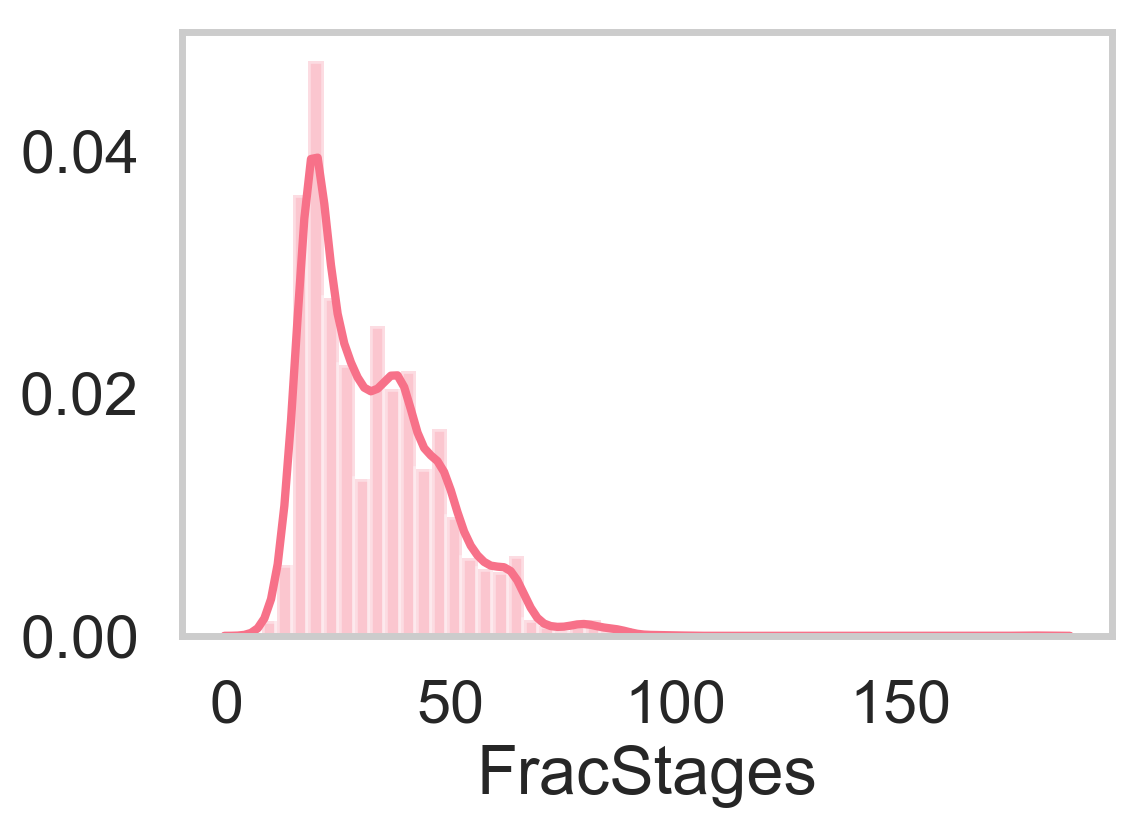

In [50]:
sns.distplot(df['FracStages'])

### Impute missing oil gravity

In [51]:
X = df[~pd.isna(df.OilGravity)][['x_coord', 'y_coord',
                                 'x_coord_bh', 'y_coord_bh',
                                 'TVD', 'MD',
                                 'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                 'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                 'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                 'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                 'MonthsToPeakProduction'
                                ]]
y = df[~pd.isna(df.OilGravity)]['OilGravity']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
missing_x = df.loc[pd.isna(df.OilGravity), ['x_coord', 'y_coord',
                                            'x_coord_bh', 'y_coord_bh',
                                            'TVD', 'MD',
                                            'oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42',
                                            'oil48', 'oil54', 'oil60', 'oil66', 'oil72',
                                            'gor6', 'gor12', 'gor18', 'gor24', 'gor30', 'gor36', 'gor42',
                                            'gor48', 'gor54', 'gor60', 'gor66', 'gor72',
                                            'MonthsToPeakProduction',
                                           ]]
missing_x = missing_x.dropna()
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Missing x shape:', missing_x.shape)
if missing_x.shape[0] == 0:
    print('no x values to use for prediction')
else:
    try:
        gb_random = joblib.load('oil_grav.pkl')
    except:
        gb = xgb.XGBRegressor()
        gb_random = RandomizedSearchCV(estimator=gb,
                                       param_distributions=gb_grid,
                                       n_iter=50,
                                       cv=5,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                  )
        gb_random.fit(X_train, y_train)
        joblib.dump(gb_random, 'oil_grav.pkl')
    print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
    print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
    print(gb_random.best_params_)
    if missing_x.shape[0] == 0:
        print('no missing values to impute.')
    else:
        imputed_y = np.transpose(gb_random.predict(missing_x))
        df.loc[missing_x.index, 'OilGravity'] = imputed_y

X shape: (4738, 31)
y shape: (4738,)
Missing x shape: (696, 31)
Training score: 0.81
Test score: 0.70
{'subsample': 0.7777777777777778, 'reg_lambda': 49.770235643321136, 'reg_alpha': 37.64935806792467, 'n_estimators': 2100, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.036282828282828285, 'gamma': 0.08111308307896868, 'colsample_bytree': 0.8611111111111112, 'colsample_bylevel': 0.9166666666666666}


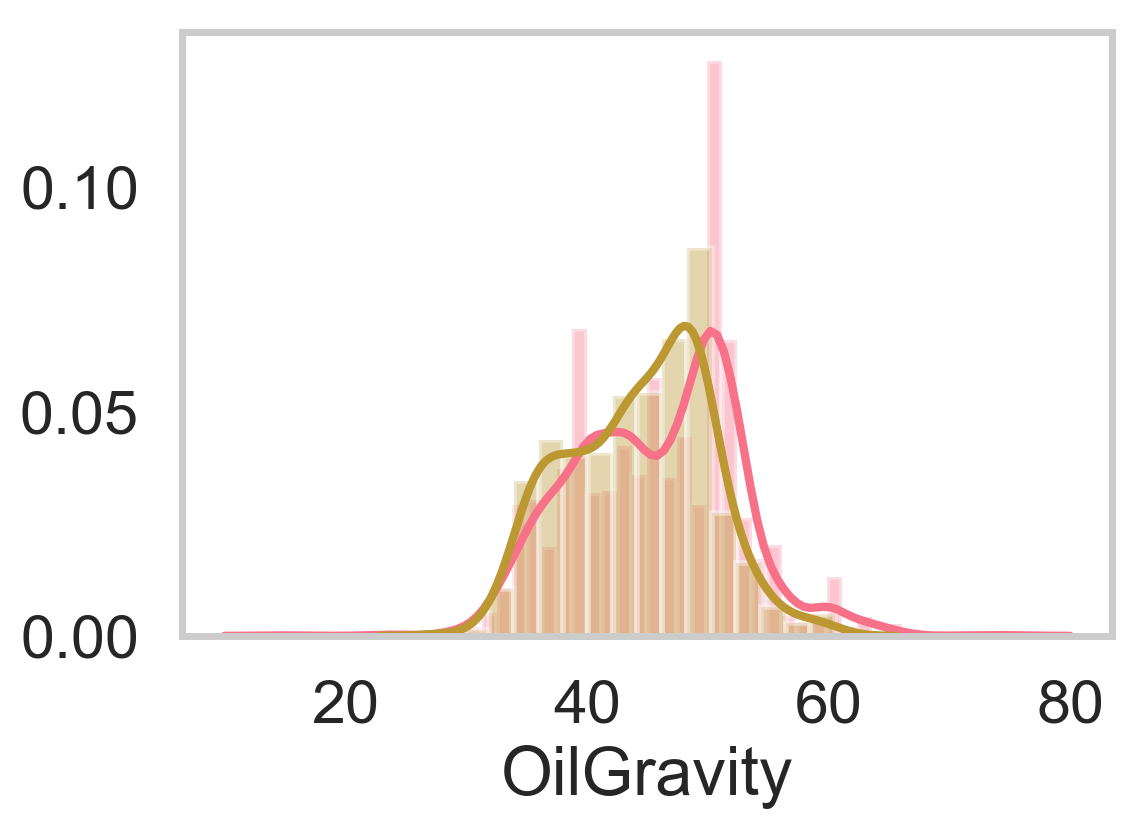

In [52]:
sns.distplot(y)
sns.distplot(imputed_y)

[<matplotlib.lines.Line2D at 0x117ffd080>]

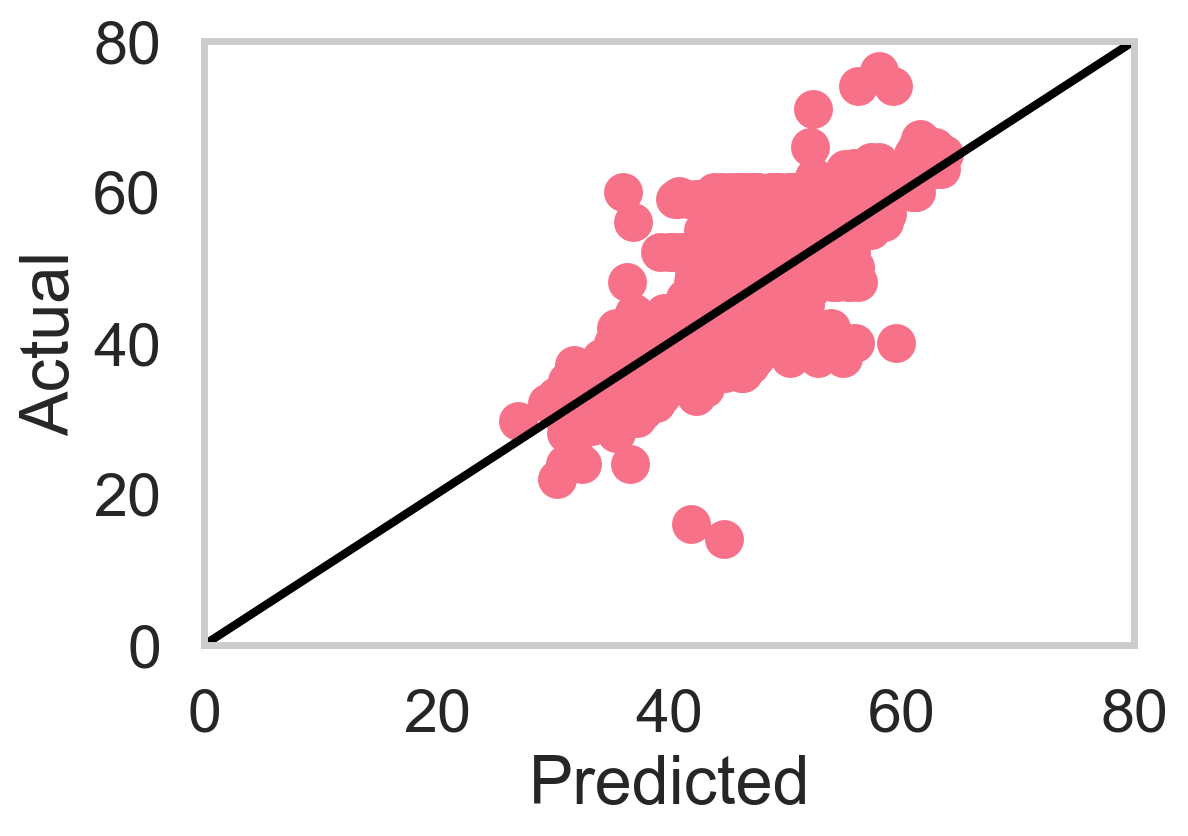

In [53]:
y_pred = gb_random.predict(X)
plt.scatter(y_pred, y)
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([0, 80], [0, 80], c='k')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 7108
Data columns (total 84 columns):
api10                     5434 non-null object
SubPlay                   5434 non-null object
WellID                    5434 non-null float64
CompletionID              5434 non-null float64
x_coord                   5434 non-null float64
y_coord                   5434 non-null float64
x_coord_bh                5434 non-null float64
y_coord_bh                5434 non-null float64
TVD                       5434 non-null float64
MD                        5434 non-null float64
PerfInterval              5434 non-null float64
FracStages                5434 non-null float64
StageSpacingFT            5434 non-null float64
ProppantPerFT             5434 non-null float64
ProppantLBS               5434 non-null float64
FluidBBLS                 5434 non-null float64
FluidPerFT                5434 non-null float64
OilGravity                5434 non-null float64
MonthsToPeakProduction    5434 

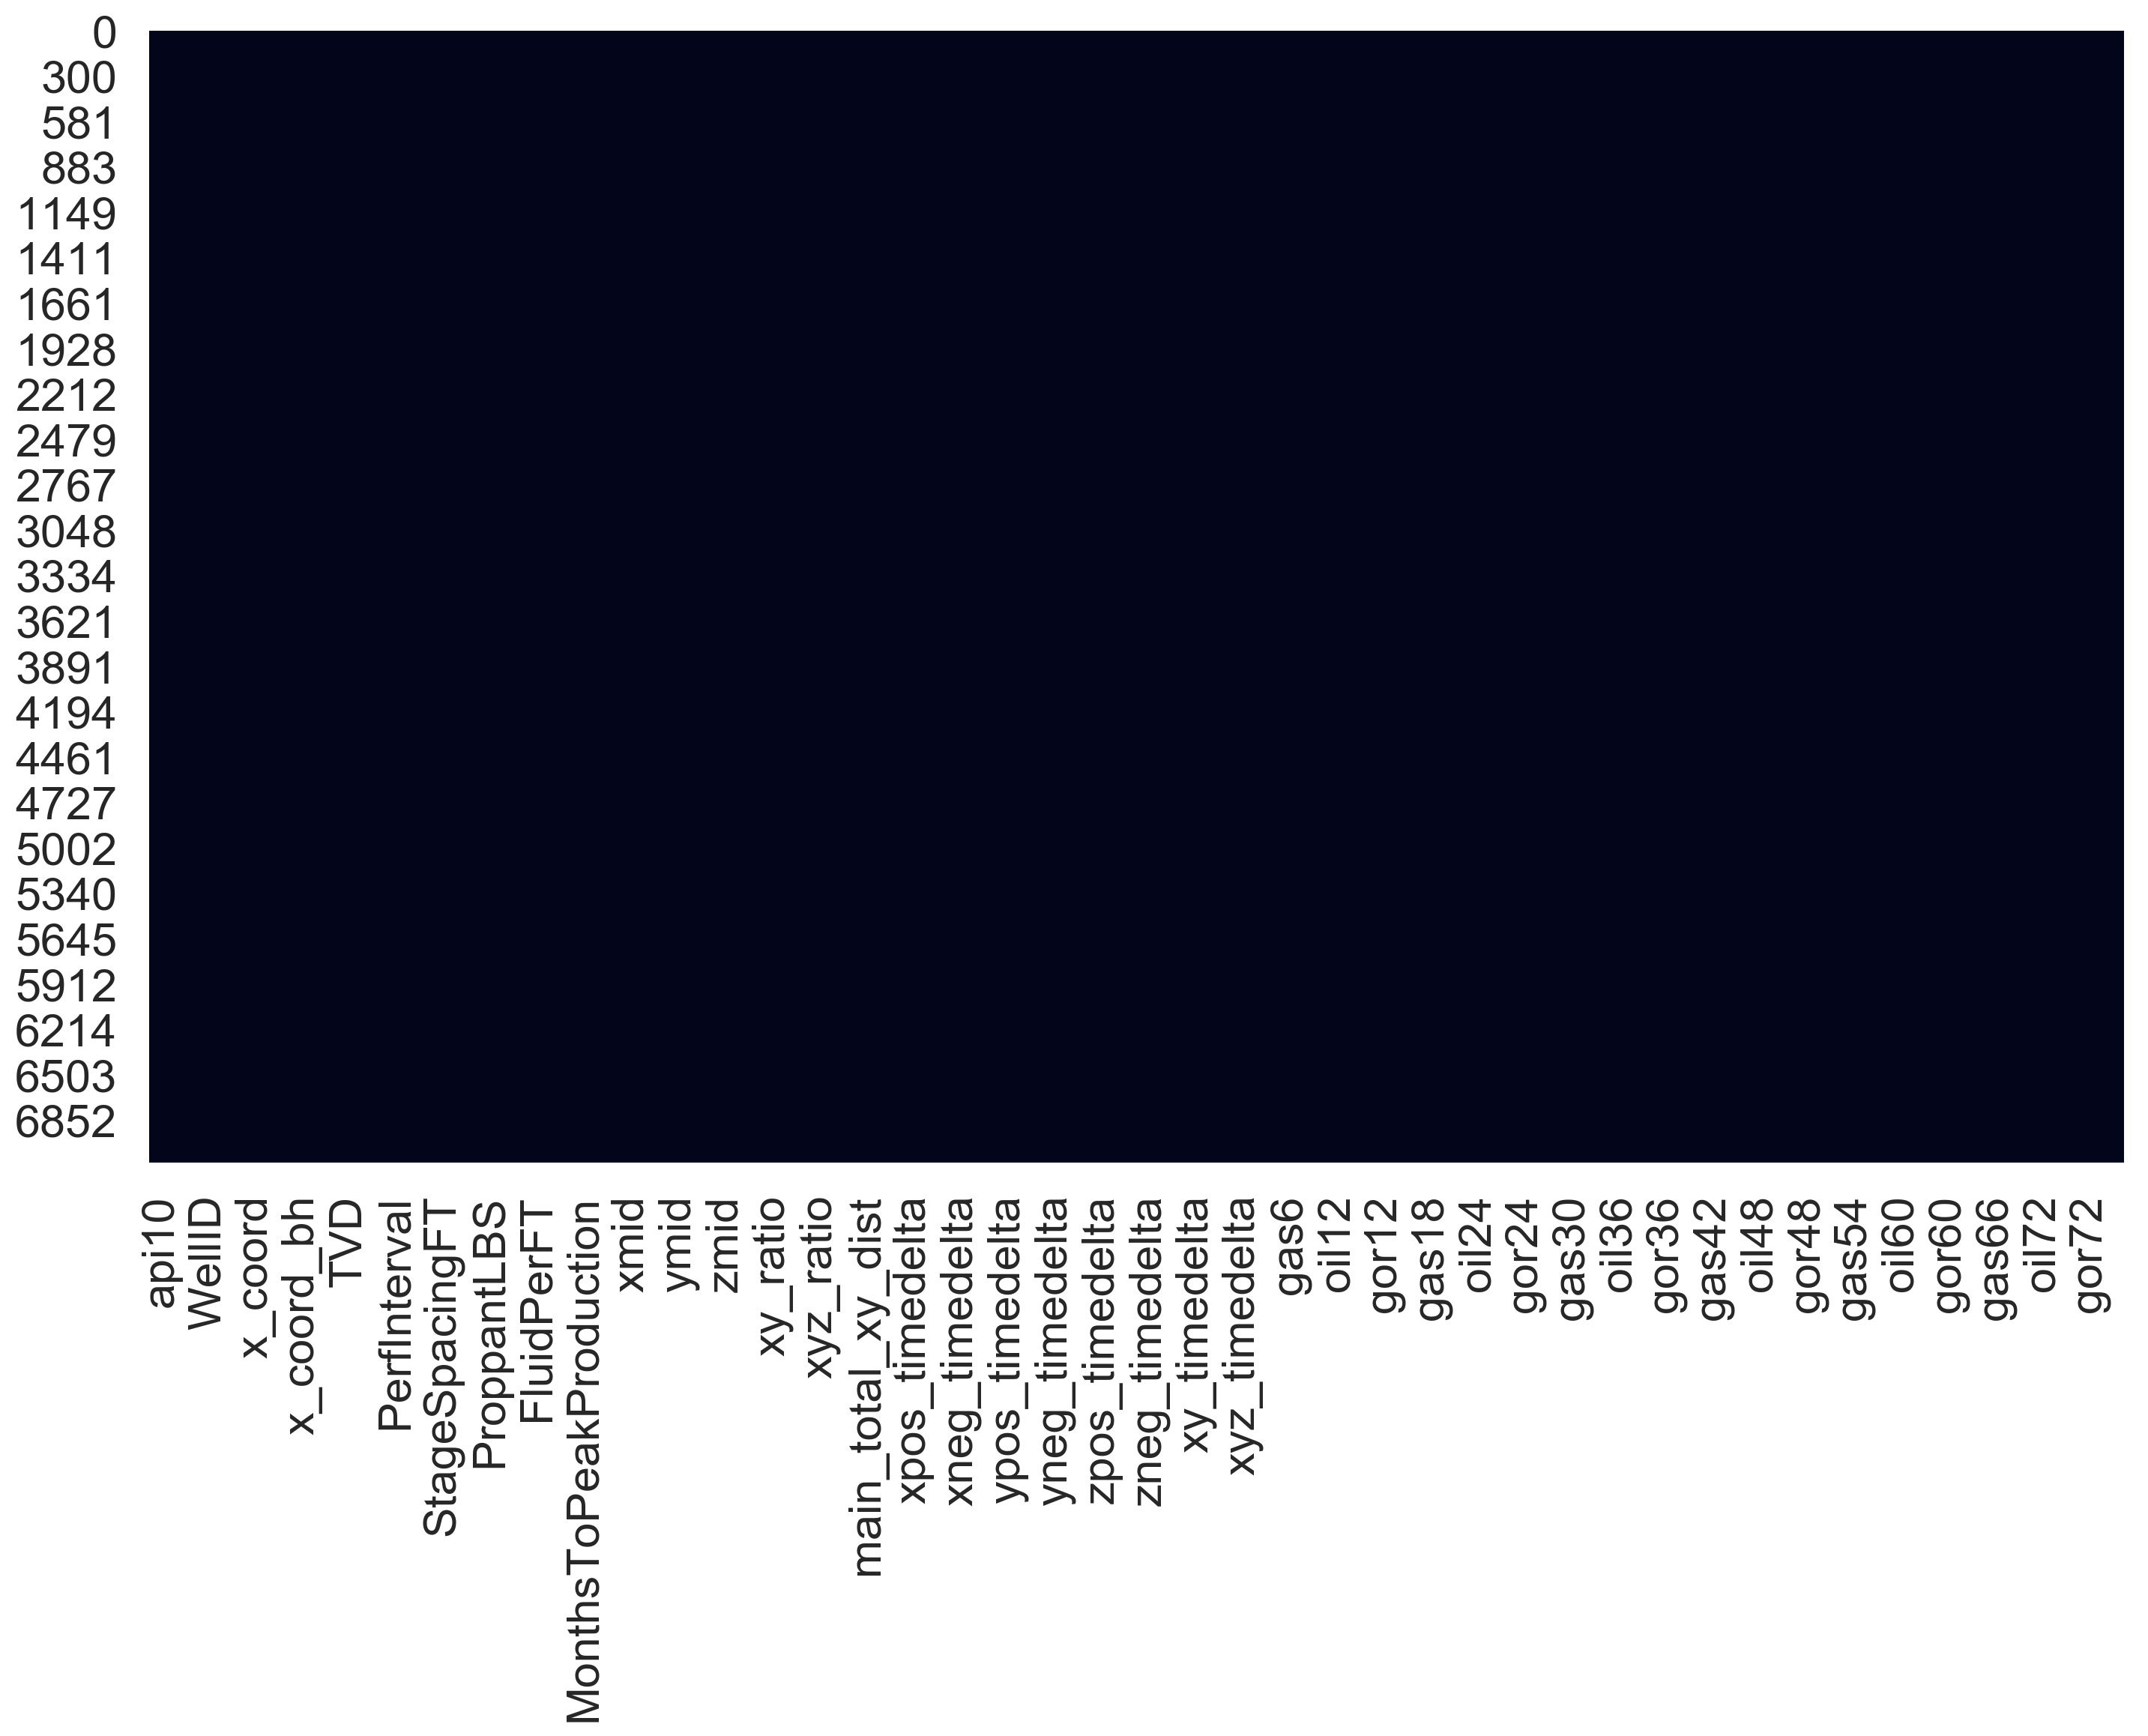

In [54]:
print(df.info())
plt.figure(figsize=(17, 10))
sns.heatmap(df.isnull(), cbar=False)

count   5,434.000
mean       17.043
std         7.309
min         0.657
25%        12.120
50%        15.915
75%        20.810
max        66.241
Name: oil36PerFT, dtype: float64

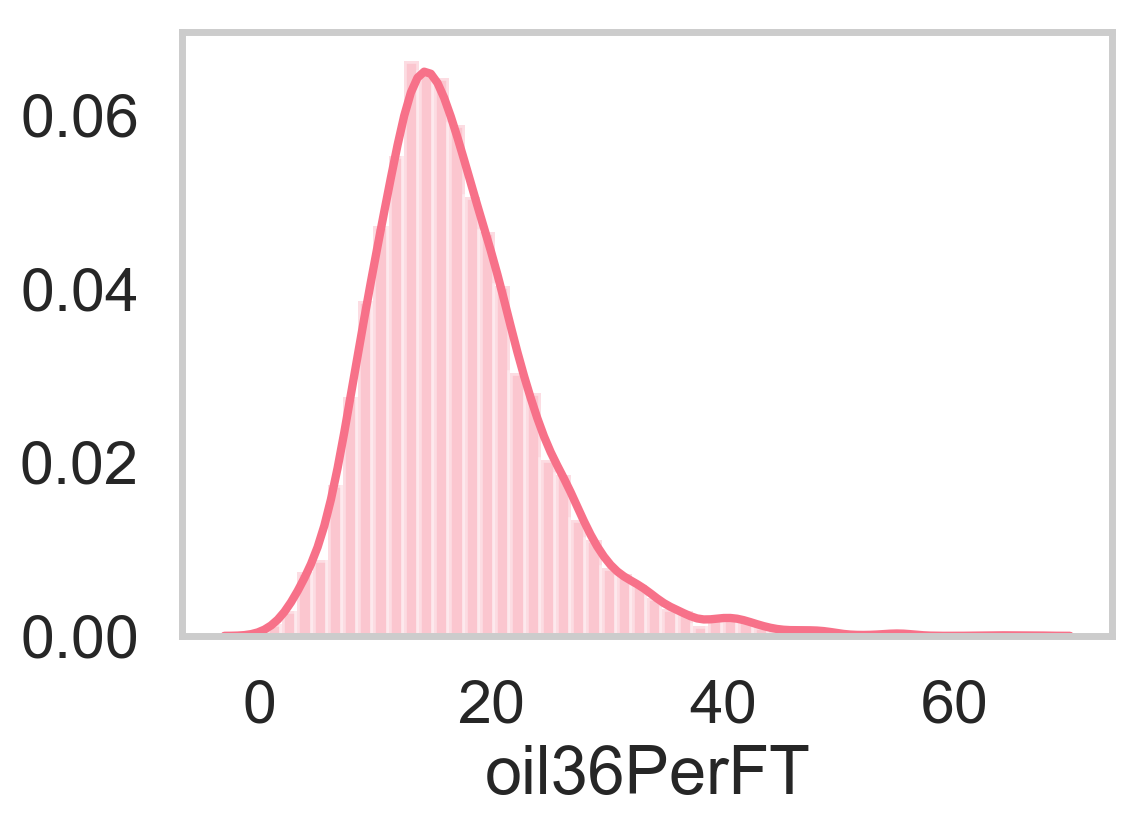

In [55]:
df['oil36PerFT'] = df['oil36']/df['PerfInterval']
sns.distplot(df['oil36PerFT'])
df['oil36PerFT'].describe()

In [56]:
for f in spacing_features:
     df.loc[:, f] = np.log1p(abs(df.loc[:, f].copy()))
df.loc[:, 'main_total_xy_dist'] = np.log1p(df.loc[:, 'main_total_xy_dist'].copy())

In [57]:
test = df[(df.FluidPerFT <= 50.)].copy()

In [58]:
test = test[test.xy_dist <= 2500.].copy()

In [59]:
test = test[test.FracStages <= 175.].copy()

In [60]:
test = test[test.StageSpacingFT <= 300.].copy()

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5113 entries, 0 to 7108
Data columns (total 85 columns):
api10                     5113 non-null object
SubPlay                   5113 non-null object
WellID                    5113 non-null float64
CompletionID              5113 non-null float64
x_coord                   5113 non-null float64
y_coord                   5113 non-null float64
x_coord_bh                5113 non-null float64
y_coord_bh                5113 non-null float64
TVD                       5113 non-null float64
MD                        5113 non-null float64
PerfInterval              5113 non-null float64
FracStages                5113 non-null float64
StageSpacingFT            5113 non-null float64
ProppantPerFT             5113 non-null float64
ProppantLBS               5113 non-null float64
FluidBBLS                 5113 non-null float64
FluidPerFT                5113 non-null float64
OilGravity                5113 non-null float64
MonthsToPeakProduction    5113 

### XGBoost model - predict 36 month cumulative oil

In [62]:
X = test[['x_coord', 'y_coord', 'x_coord_bh', 'y_coord_bh',
        'TVD', 'MD', 'PerfInterval', 'FracStages', 'StageSpacingFT',
        'ProppantLBS', 'ProppantPerFT', 'FluidBBLS', 'FluidPerFT',
        'ProppantConcentration', 'xmid', 'xlen', 'ymid', 'ylen',
        'zmid', 'zlen', 'xy_ratio', 'z_ratio', 'xyz_ratio',
        'ns_orientation', 'main_total_xy_dist', 'xpos_dist', 
        'xpos_timedelta', 'xneg_dist', 'xneg_timedelta', 'ypos_dist',
        'ypos_timedelta', 'zneg_dist', 'zneg_timedelta', 'xy_dist',
        'xy_timedelta', 'xyz_dist', 'xyz_timedelta', 'zpos_dist', 'zpos_timedelta',
        'OilGravity', 'MonthsToPeakProduction', 'TotalProducingMonths', 'gor6', 'gor12', 'gor24', 'gor36'
       ]]
y = test['oil36']
names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)
try:
    gb_random = joblib.load('oil36_gb.pkl')
    print('using existing model')
except:
    print('building model')
    gb = xgb.XGBRegressor(verbosity=True,
                          random_state=42,
                          objective='reg:linear',
                          n_estimators=1700,
                          learning_rate=0.0514040404040404,
                          gamma=0.25353644939701114,
                          max_depth=4,
                          min_child_weight=1,
                          subsample=0.9444444444444444,
                          colsample_bytree=0.5277777777777778,
                          colsample_bylevel=0.6111111111111112,
                          reg_lambda=0.49770235643321115,
                          reg_alpha=0.6579332246575682
                         )
    gb_random = RandomizedSearchCV(estimator=gb,
                                   param_distributions=gb_grid,
                                   n_iter=100,
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1
                                  )
    param_grid = {
                  'n_estimators': [1700],
                  'learning_rate': [0.0514040404040404],
                  'gamma': [0.25353644939701114],
                  'max_depth': [4],
                  'min_child_weight': [1],
                  'subsample': [0.9444444444444444],
                  'colsample_bytree': [0.5277777777777778],
                  'colsample_bylevel': [0.6111111111111112],
                  'reg_lambda': [0.49770235643321115],
                  'reg_alpha': [0.6579332246575682],
                  'reg_alpha': np.logspace(-2, 7, 10),
                  'reg_lambda': np.logspace(-2, 7, 10)
                 }
    gb_random = GridSearchCV(estimator=gb,
                             param_grid=param_grid,
                             cv=5,
                             verbose=1,
                             n_jobs=-1
                            )
    eval_set  = [(X_train, y_train), (X_test, y_test)]
    gb_random.fit(X_train, y_train, early_stopping_rounds=80, eval_metric='rmse', eval_set=eval_set)
    joblib.dump(gb_random, 'oil36_gb.pkl')
print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))

using existing model
Training score: 0.97
Test score: 0.77


In [63]:
print(gb_random.best_params_)
print('Training score:', '{:,.2f}'.format(gb_random.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random.score(X_test, y_test)))
coefs = gb_random.best_estimator_.feature_importances_
indices = np.argsort(coefs)[::-1]
names = [names[i] for i in indices]
df_importance = pd.DataFrame({'feature': names, 'importance': coefs})
df_importance.sort_values(by=['importance'], inplace=True, ascending=False)
print(df_importance)

{'colsample_bylevel': 0.6111111111111112, 'colsample_bytree': 0.5277777777777778, 'gamma': 0.25353644939701114, 'learning_rate': 0.0514040404040404, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 1700, 'reg_alpha': 100000.0, 'reg_lambda': 0.01, 'subsample': 0.9444444444444444}
Training score: 0.97
Test score: 0.77
                   feature  importance
38               zpos_dist       0.033
43          xneg_timedelta       0.030
42           xyz_timedelta       0.030
16                    xmid       0.029
5                    gor24       0.029
44  MonthsToPeakProduction       0.029
24                    zlen       0.028
18               FluidBBLS       0.028
12            PerfInterval       0.028
10          zneg_timedelta       0.027
32                    xlen       0.027
3                     ymid       0.026
6       main_total_xy_dist       0.026
45          ns_orientation       0.025
13                   gor36       0.025
1                    gor12       0.025
14   Proppant

Text(0,0.5,'actual')

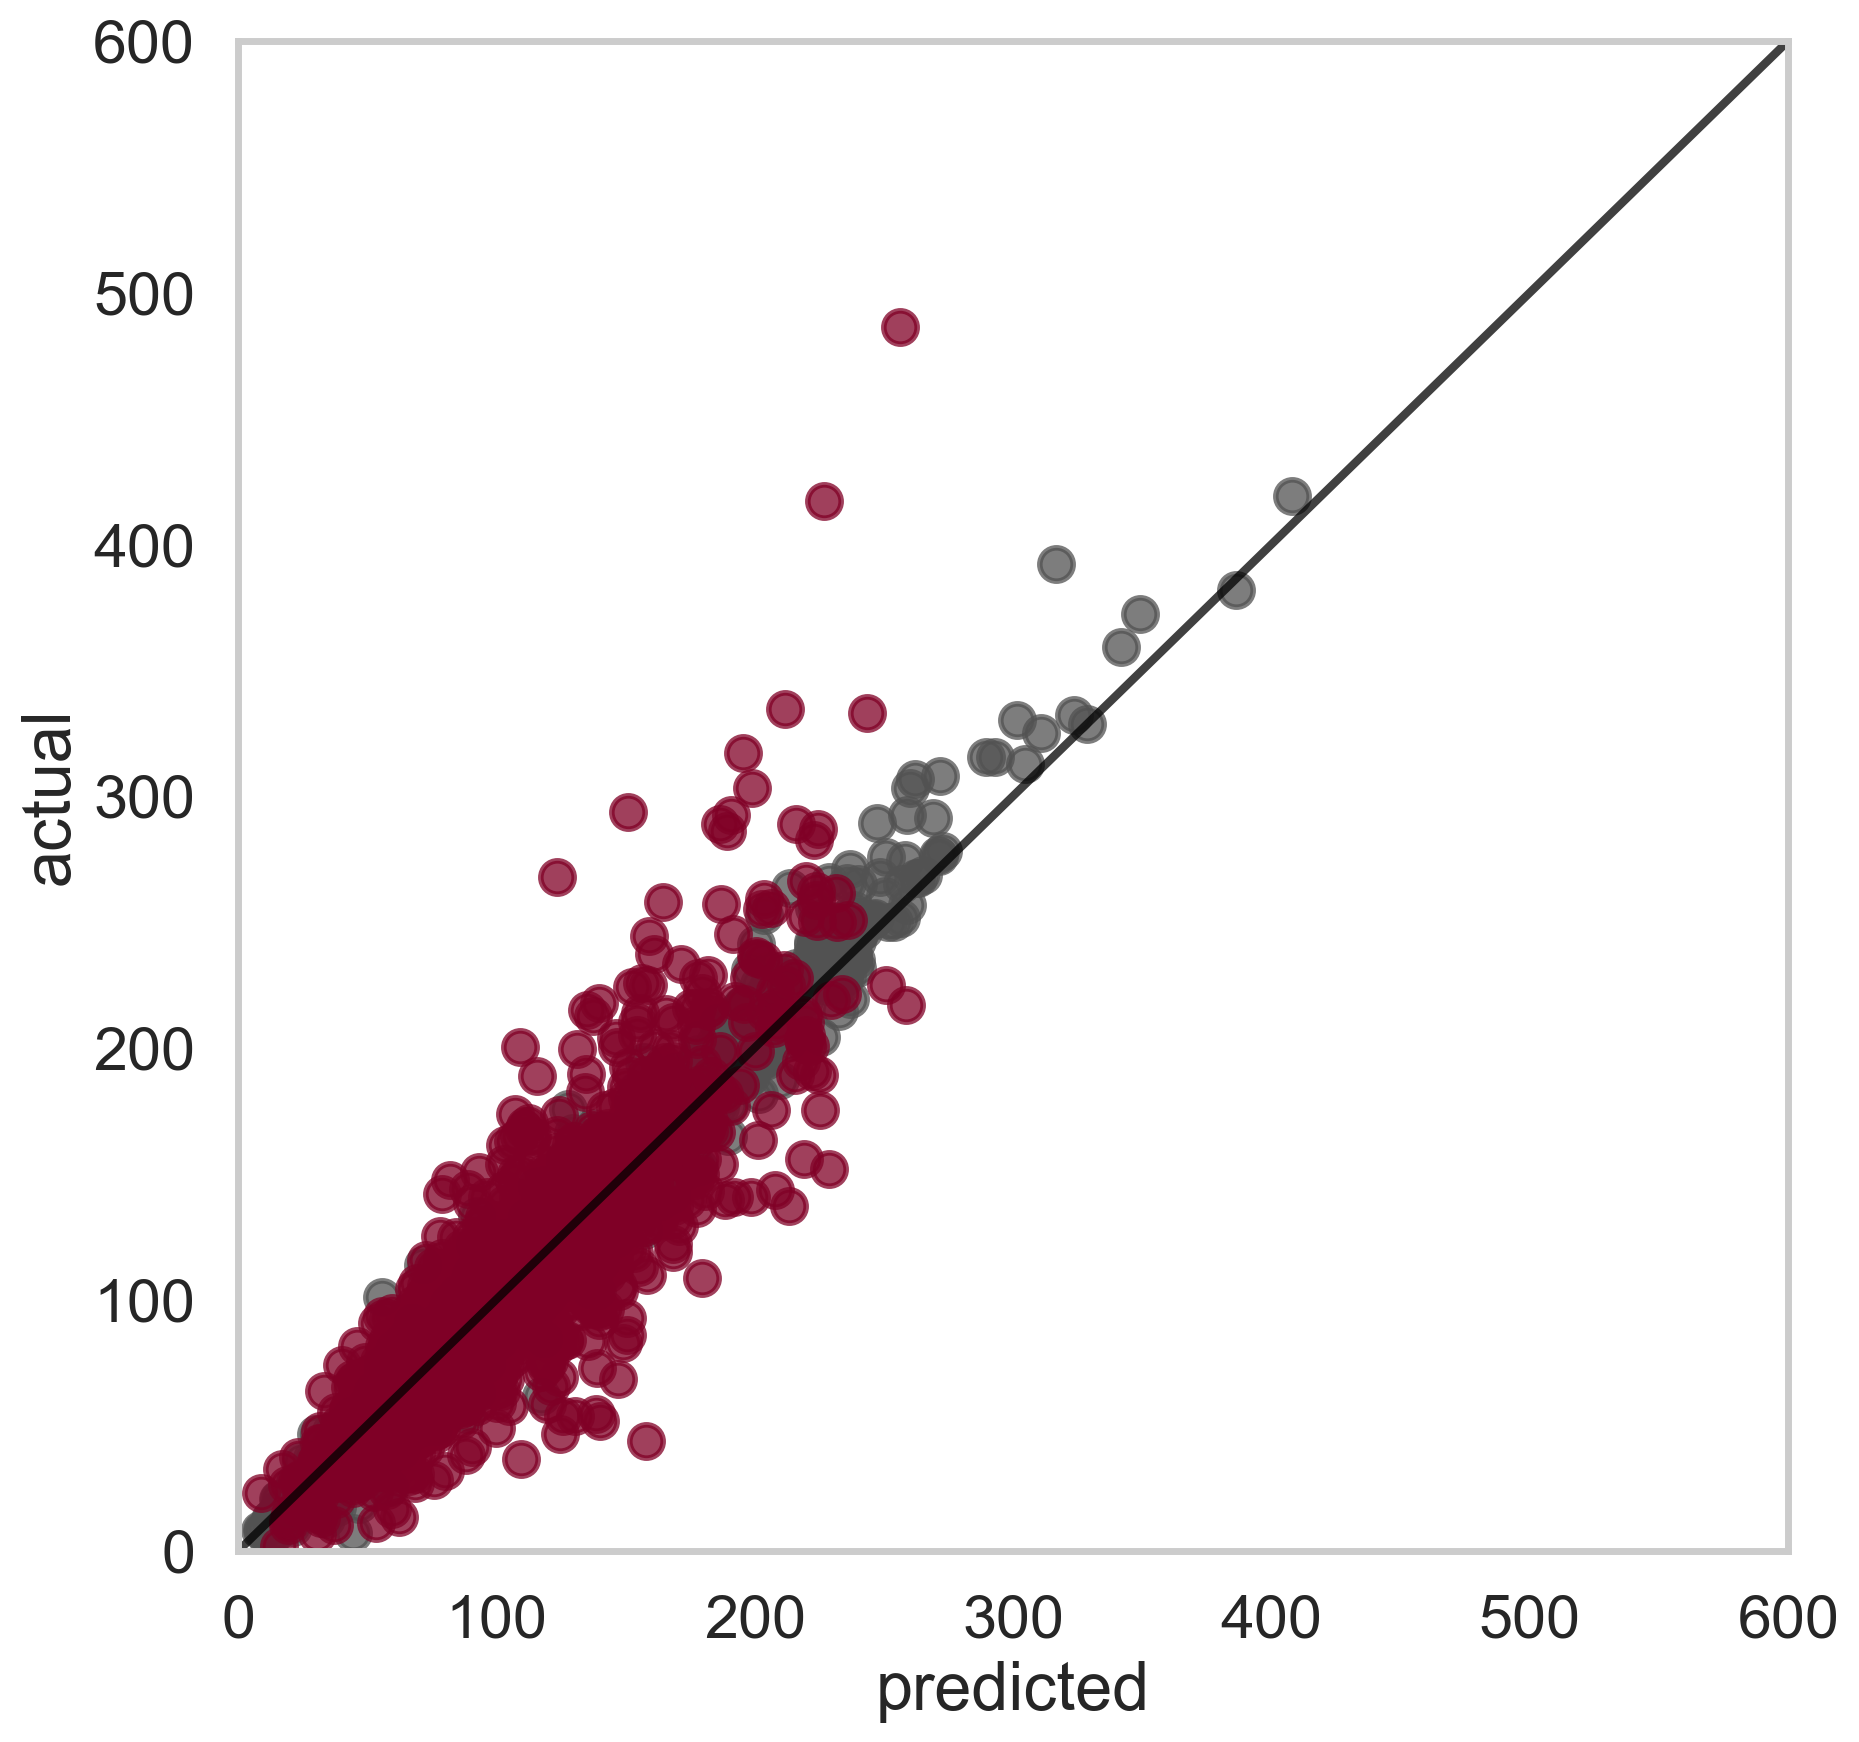

In [64]:
y_pred_train = gb_random.predict(X_train)
y_pred_test = gb_random.predict(X_test)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(x=y_pred_train/1000, y=y_train/1000, c='#525252', alpha=0.75)
plt.scatter(x=y_pred_test/1000, y=y_test/1000, c='#800026', alpha=0.75)
ax.plot([0, 600], [0, 600], c='k', alpha=0.75)
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.xlabel('predicted')
plt.ylabel('actual')

### Multi target

In [ ]:
all_prod = df_sql_fcst.loc[df_sql_fcst.api10.isin(df.api10.unique()), :]
first36mo = all_prod[all_prod.TimeOnProd < 37]
first36mo = first36mo.pivot(index='api10', columns='TimeOnProd', values='oilBBL')
first36mo.reset_index(inplace=True)
df = df.merge(first36mo, left_on='api10', right_on='api10')

In [ ]:
df.to_csv('dj_data_out.csv')

In [ ]:
df.api10.unique()[:5]

In [ ]:
X = df[['x_coord', 'y_coord', 'x_coord_bh', 'y_coord_bh',
        'TVD', 'MD', 'PerfInterval', 'FracStages', 'StageSpacingFT',
        'ProppantLBS', 'ProppantPerFT', 'FluidBBLS', 'FluidPerFT',
        'ProppantConcentration', 'xmid', 'xlen', 'ymid', 'ylen',
        'zmid', 'zlen', 'xy_ratio', 'z_ratio', 'xyz_ratio',
        'ns_orientation', 'main_total_xy_dist', 'xpos_dist', 
        'xpos_timedelta', 'xneg_dist', 'xneg_timedelta', 'ypos_dist',
        'ypos_timedelta', 'zneg_dist', 'zneg_timedelta', 'xy_dist',
        'xy_timedelta', 'xyz_dist', 'xyz_timedelta', 'zpos_dist', 'zpos_timedelta',
        'OilGravity', 'MonthsToPeakProduction', 'TotalProducingMonths', 'gor6', 'gor12', 'gor24', 'gor36'
       ]]
# y = df[['oil6', 'oil12', 'oil18', 'oil24', 'oil30', 'oil36', 'oil42', 'oil48', 'oil54', 'oil60', 'oil66', 'oil72']]
y = df[np.arange(1, 37)]
names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)
try:
    gb_random_multi = joblib.load('oil36_gb_multi.pkl')
    print('using existing model')
except:
    print('building model')
    gb = xgb.XGBRegressor(verbosity=True,
                          random_state=42,
                          objective='reg:linear',
                          n_estimators=1700,
                          learning_rate=0.0514040404040404,
                          gamma=0.25353644939701114,
                          max_depth=4,
                          min_child_weight=1,
                          subsample=0.9444444444444444,
                          colsample_bytree=0.5277777777777778,
                          colsample_bylevel=0.6111111111111112,
                          reg_lambda=0.49770235643321115,
                          reg_alpha=0.6579332246575682
                         )
    multi_gb = MultiOutputRegressor(gb)
    gb_random_multi = RandomizedSearchCV(estimator=multi_gb,
                                         param_distributions=gb_grid_multi,
                                         n_iter=100,
                                         cv=5,
                                         verbose=1,
                                         n_jobs=-1
                                        )
    param_grid = {
                  'n_estimators': [1700],
                  'learning_rate': [0.0514040404040404],
                  'gamma': [0.25353644939701114],
                  'max_depth': [4],
                  'min_child_weight': [1],
                  'subsample': [0.9444444444444444],
                  'colsample_bytree': [0.5277777777777778],
                  'colsample_bylevel': [0.6111111111111112],
                  'reg_lambda': [0.49770235643321115],
                  'reg_alpha': [0.6579332246575682],
                  'reg_alpha': np.logspace(-2, 7, 10),
                  'reg_lambda': np.logspace(-2, 7, 10)
                 }
#     gb_random_multi = GridSearchCV(estimator=multi_gb,
#                                    param_grid=param_grid,
#                                    cv=5,
#                                    verbose=1,
#                                    n_jobs=-1
#                                   )
#     eval_set  = [(X_train, y_train), (X_test, y_test)]
#     gb_random_multi.fit(X_train, y_train, early_stopping_rounds=80, eval_metric='rmse', eval_set=eval_set)
    gb_random_multi.fit(X_train, y_train)
    joblib.dump(gb_random_multi, 'oil36_gb_multi.pkl')
print('Training score:', '{:,.2f}'.format(gb_random_multi.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random_multi.score(X_test, y_test)))

In [ ]:
print('Training score:', '{:,.2f}'.format(gb_random_multi.score(X_train, y_train)))
print('Test score:', '{:,.2f}'.format(gb_random_multi.score(X_test, y_test)))
y_pred_train = gb_random_multi.predict(X_train)
y_pred_test = gb_random_multi.predict(X_test)

In [ ]:
test = df.filter(regex='oil')

In [ ]:
y_pred = gb_random_multi.predict(X)

In [ ]:
y_pred_pct = np.percentile(y_pred, [10, 50, 90], axis=0)
y_pred_pct

In [ ]:
y_pred_p10 = np.array([y_pred_test[:, o].quantile(0.1) for o in range(y_pred_test.shape[1])])

In [ ]:
y_pred_p90 = np.array([y_pred_test[:, o].quantile(0.9) for o in range(y_pred_test.shape[1])])

In [ ]:
y_pct = np.percentile(y, [10, 50, 90], axis=0)
y_pct

In [ ]:
test.transpose().mean(axis=1)

In [ ]:
x = np.arange(1, 37)
plt.plot(x, y_pct[0], c='r', alpha=0.25)
plt.plot(x, y_pct[1], c='r', alpha=0.75)
plt.plot(x, y_pct[2], c='r', alpha=0.25)
plt.plot(x, y_pred_pct[0], c='b', alpha=0.25)
plt.plot(x, y_pred_pct[1], c='b', alpha=0.75)
plt.plot(x, y_pred_pct[2], c='b', alpha=0.25)

In [ ]:
df_resids = df.copy()
df_resids['resids'] = abs(y - gb_random.predict(X))
df_resids.sort_values(by=['resids'], ascending=True, inplace=True)
df_resids.reset_index(inplace=True)

In [ ]:
df_resids = df_resids.iloc[100:]

In [ ]:
fitted = gb_random.predict(X)
resids = y - fitted
plt.scatter(resids, fitted)

In [65]:
lat_long = df_sql_well.loc[:, ['api10', 'Latitude', 'Longitude']].copy()

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5113 entries, 0 to 7108
Data columns (total 46 columns):
x_coord                   5113 non-null float64
y_coord                   5113 non-null float64
x_coord_bh                5113 non-null float64
y_coord_bh                5113 non-null float64
TVD                       5113 non-null float64
MD                        5113 non-null float64
PerfInterval              5113 non-null float64
FracStages                5113 non-null float64
StageSpacingFT            5113 non-null float64
ProppantLBS               5113 non-null float64
ProppantPerFT             5113 non-null float64
FluidBBLS                 5113 non-null float64
FluidPerFT                5113 non-null float64
ProppantConcentration     5113 non-null float64
xmid                      5113 non-null float64
xlen                      5113 non-null float64
ymid                      5113 non-null float64
ylen                      5113 non-null float64
zmid                      511

In [67]:
X2 = df.merge(lat_long, left_on='api10', right_on='api10')

In [68]:
X2 = X2[['x_coord', 'y_coord', 'x_coord_bh', 'y_coord_bh',
        'TVD', 'MD', 'PerfInterval', 'FracStages', 'StageSpacingFT',
        'ProppantLBS', 'ProppantPerFT', 'FluidBBLS', 'FluidPerFT',
        'ProppantConcentration', 'xmid', 'xlen', 'ymid', 'ylen',
        'zmid', 'zlen', 'xy_ratio', 'z_ratio', 'xyz_ratio',
        'ns_orientation', 'main_total_xy_dist', 'xpos_dist', 
        'xpos_timedelta', 'xneg_dist', 'xneg_timedelta', 'ypos_dist',
        'ypos_timedelta', 'zneg_dist', 'zneg_timedelta', 'xy_dist',
        'xy_timedelta', 'xyz_dist', 'xyz_timedelta', 'zpos_dist', 'zpos_timedelta',
        'OilGravity', 'MonthsToPeakProduction', 'TotalProducingMonths', 'gor6', 'gor12', 'gor24', 'gor36', 'Latitude', 'Longitude', 'SubPlay', 'oil36'
       ]]

In [69]:
X2['oilperft'] = X2['oil36'] / X2['PerfInterval']*1000

(-105.12091655953628,
 -103.6584454404637,
 39.485833598942456,
 42.16798640105755)

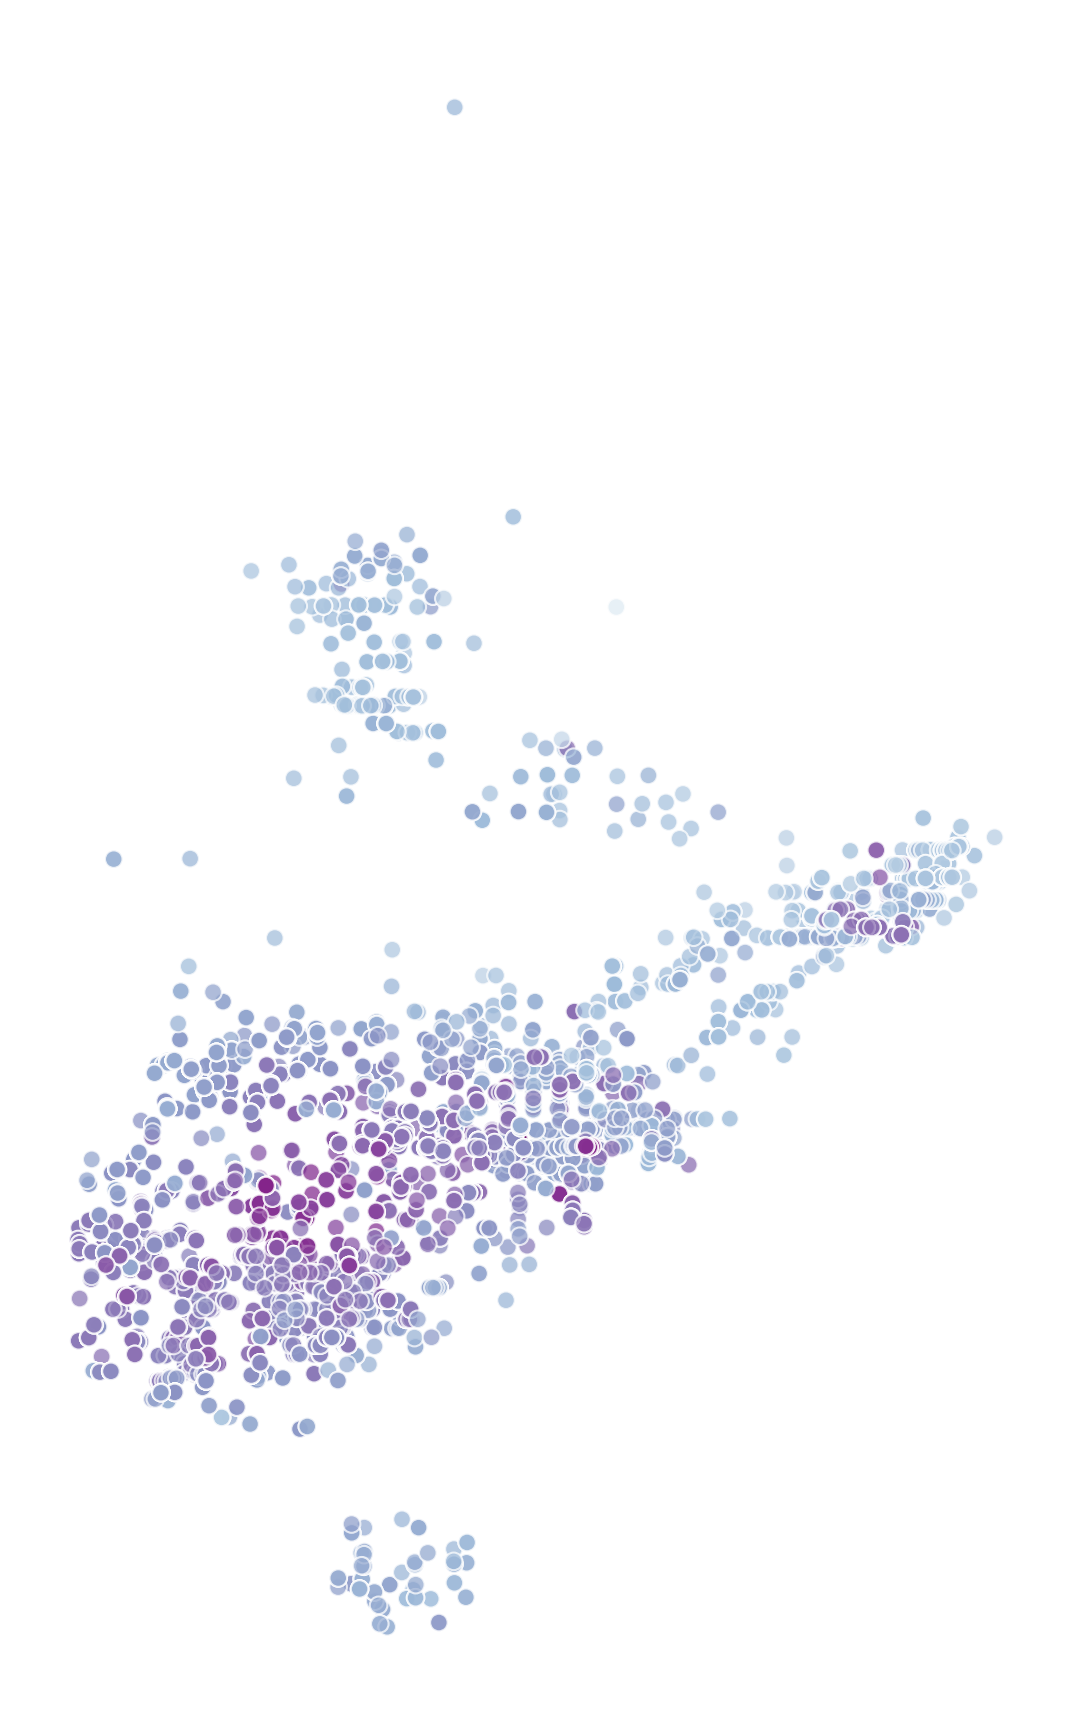

In [70]:
plt.figure(figsize=(7,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='OilGravity', data=X2, palette='BuPu', s=40, alpha=0.75, legend=False)
plt.tight_layout()
fig = plt.gca()
fig.axes.get_xaxis().set_ticks([])
fig.axes.get_yaxis().set_ticks([])
plt.xlabel('')
plt.ylabel('')
fig.patch.set_visible(False)
plt.axis('off')

In [71]:
shap.initjs()

In [72]:
explainer = shap.TreeExplainer(gb_random.best_estimator_)
shap_values = explainer.shap_values(X)

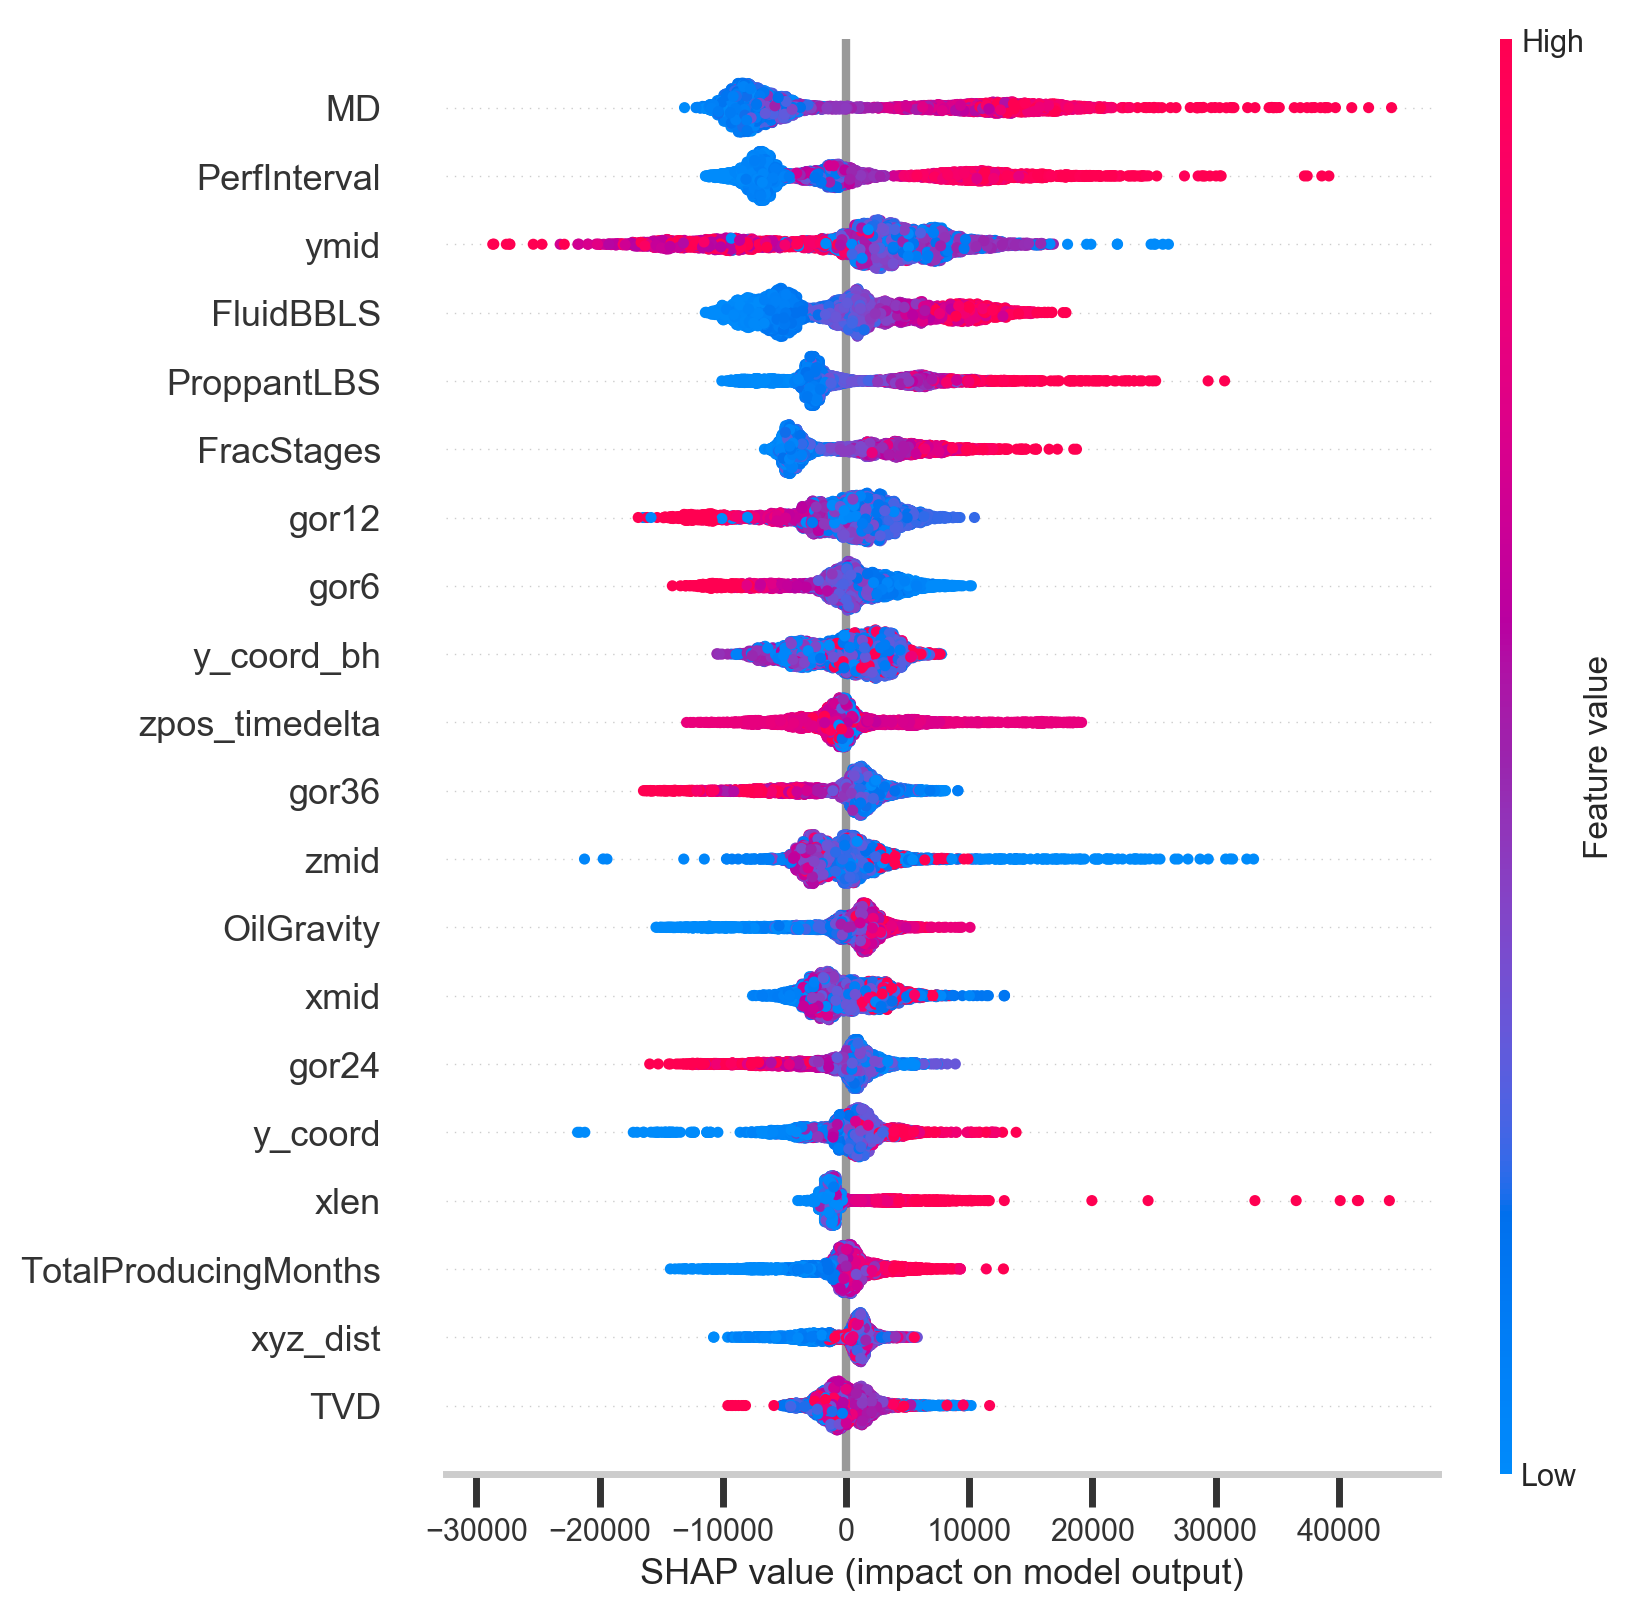

In [183]:
shap.summary_plot(shap_values, X, max_display=20)
plt.tight_layout()

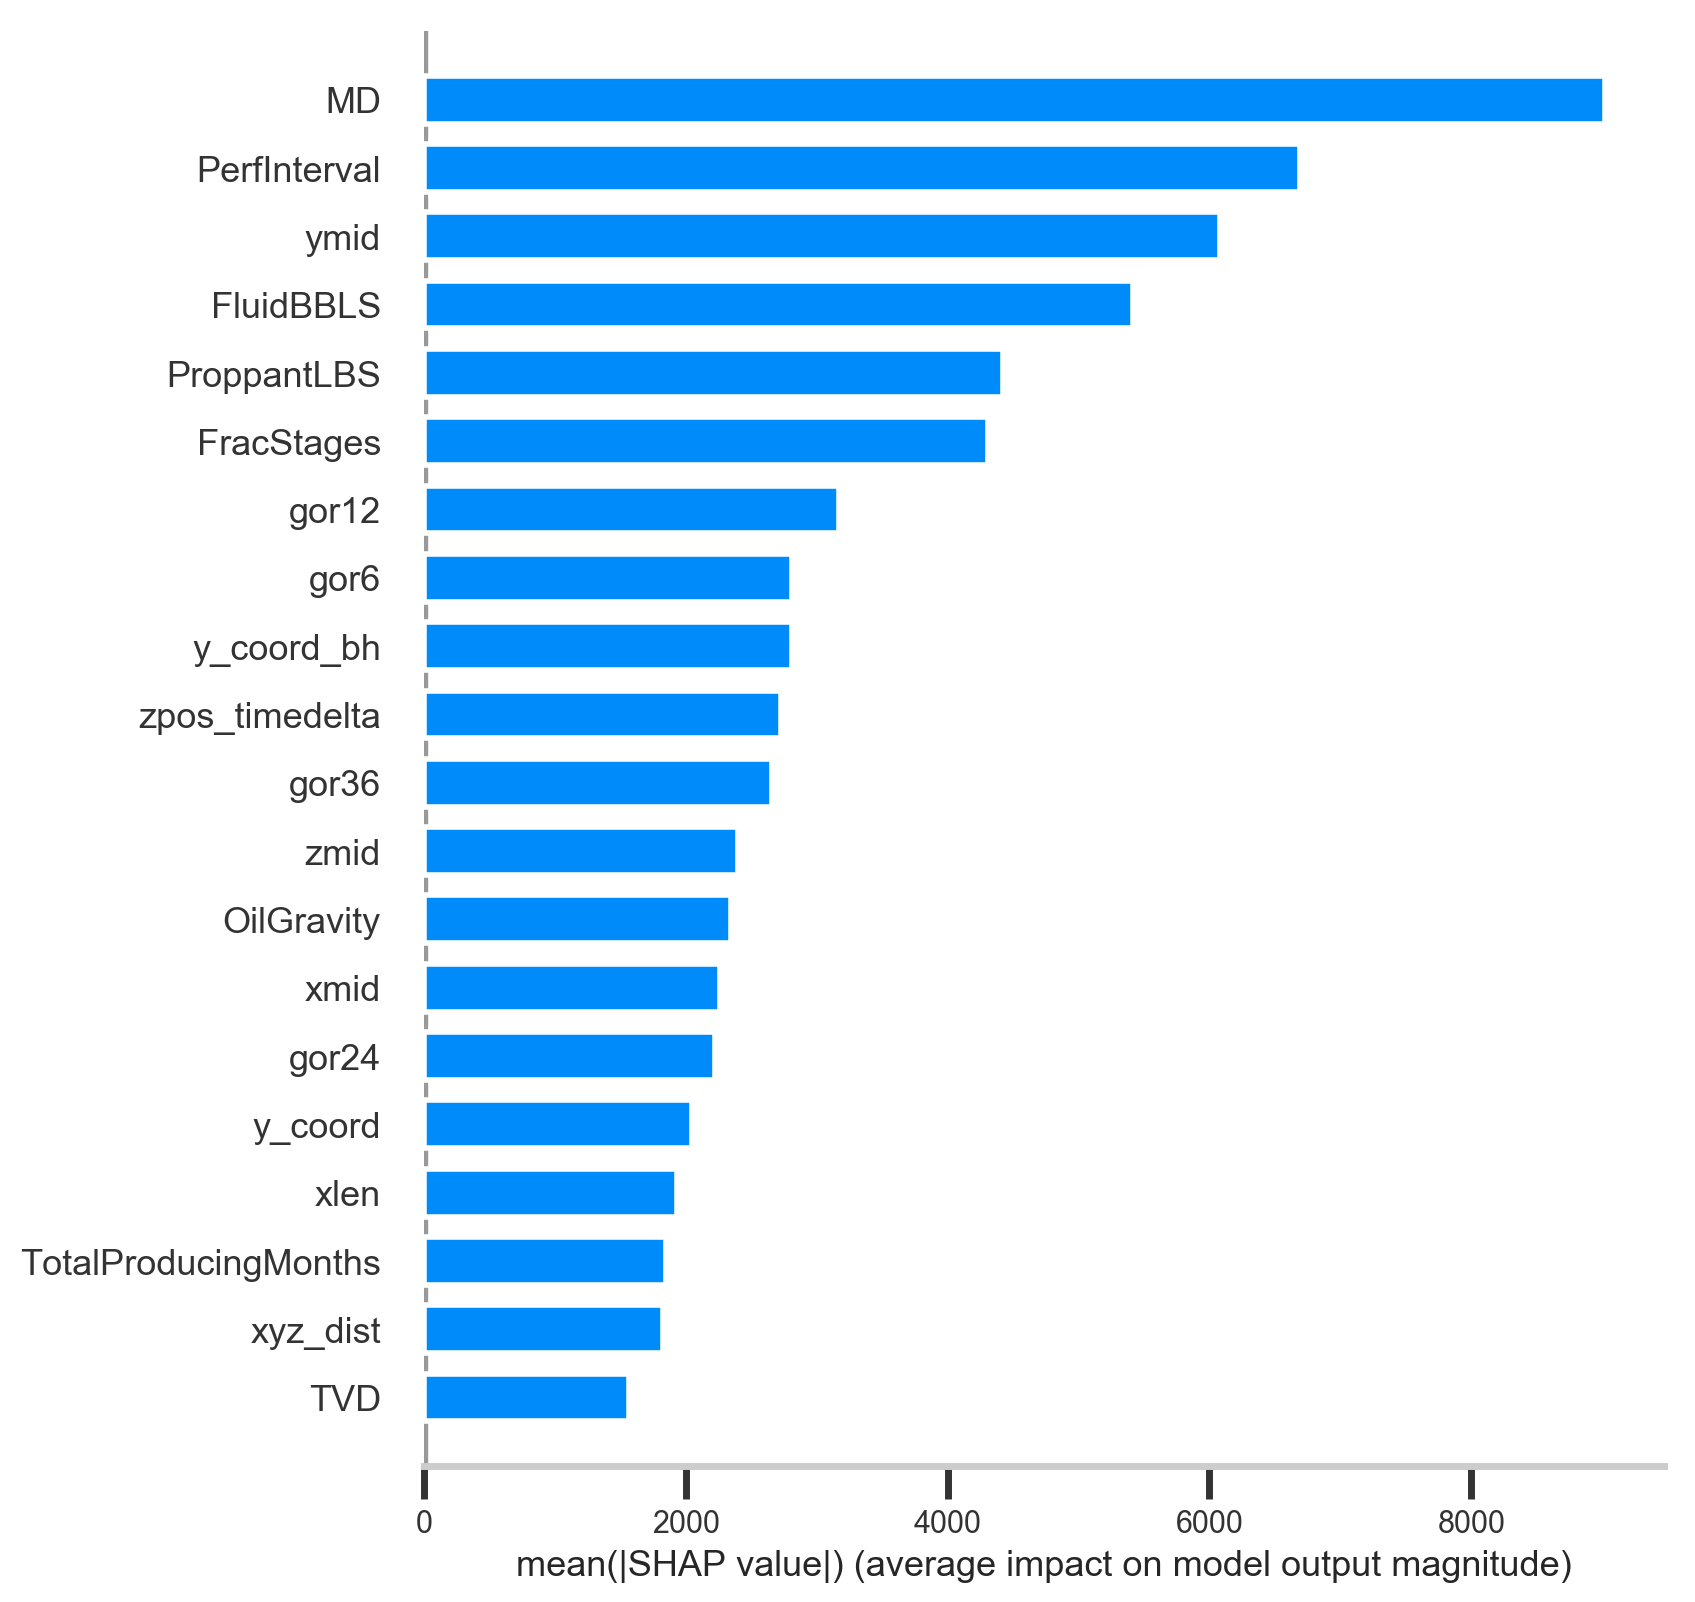

In [84]:
shap.summary_plot(shap_values, X, plot_type='bar')

In [80]:
category_dict = {
    'x_coord': 'geo',
    'y_coord': 'geo',
    'x_coord_bh': 'geo',
    'y_coord_bh': 'geo',
    'TVD': 'geo',
    'MD': 'ops',
    'PerfInterval': 'ops',
    'FracStages': 'ops',
    'StageSpacingFT': 'ops',
    'ProppantLBS': 'ops',
    'ProppantPerFT': 'ops',
    'FluidBBLS': 'ops',
    'FluidPerFT': 'ops',
    'ProppantConcentration': 'ops',
    'xmid': 'geo',
    'xlen': 'ops',
    'ymid': 'geo',
    'ylen': 'ops',
    'zmid': 'geo',
    'zlen': 'ops',
    'xy_ratio': 'ops',
    'z_ratio': 'ops',
    'xyz_ratio': 'ops',
    'ns_orientation': 'ops',
    'main_total_xy_dist': 'spacing',
    'xpos_dist': 'spacing',
    'xpos_timedelta': 'spacing',
    'xneg_dist': 'spacing',
    'xneg_timedelta': 'spacing',
    'ypos_dist': 'spacing',
    'ypos_timedelta': 'spacing',
    'zneg_dist': 'spacing',
    'zneg_timedelta': 'spacing',
    'xy_dist': 'spacing',
    'xy_timedelta': 'spacing',
    'xyz_dist': 'spacing',
    'xyz_timedelta': 'spacing',
    'zpos_dist': 'spacing',
    'zpos_timedelta': 'spacing',
    'zneg_dist': 'spacing',
    'zneg_timedelta': 'spacing',
    'OilGravity': 'reservoir',
    'MonthsToPeakProduction': 'ops',
    'TotalProducingMonths': 'ops',
    'gor6': 'reservoir',
    'gor12': 'reservoir',
    'gor24': 'reservoir',
    'gor36': 'reservoir'
}

In [86]:
shap_dict = {}
for idx, c in enumerate(X.columns):
    shap_dict[c] = np.absolute(shap_values[:, idx]).mean()

In [88]:
cat_shap_dict = {}
for k in category_dict.keys():
    if category_dict[k] in cat_shap_dict.keys():
        cat_shap_dict[category_dict[k]] += shap_dict[k]
    else:
        cat_shap_dict[category_dict[k]] = shap_dict[k]

In [92]:
total = sum(cat_shap_dict.values())
for k in cat_shap_dict:
    cat_shap_dict[k] /= total

In [99]:
cat_shap_dict

{'geo': 0.21630422461915141,
 'ops': 0.46077319886435897,
 'reservoir': 0.14337095127006494,
 'spacing': 0.1795516252464247}

[None, None, None, None, None, None, None, None]

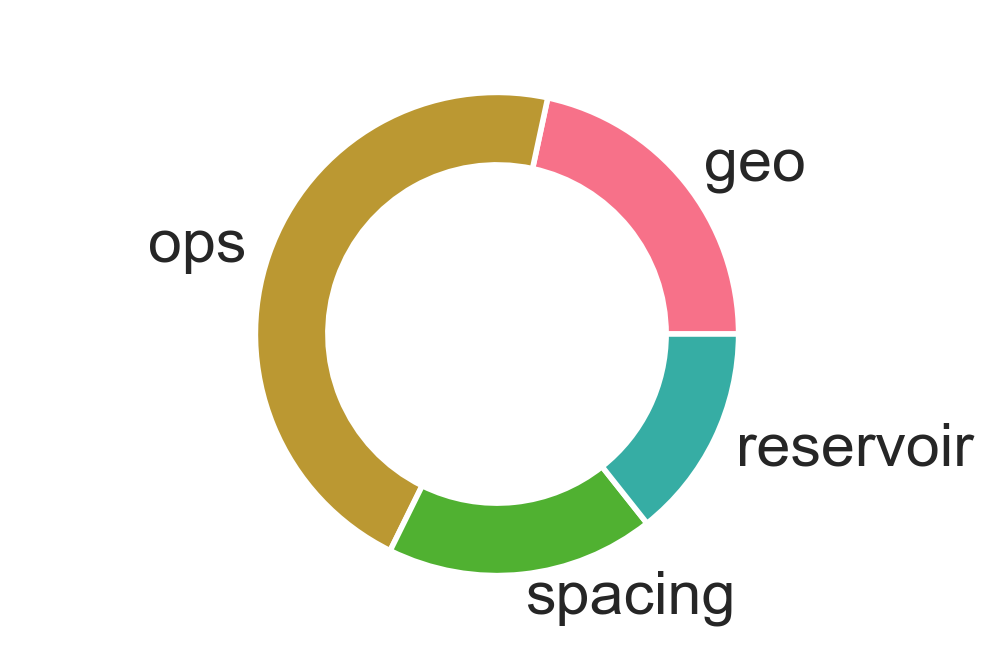

In [98]:
fig, ax = plt.subplots()
ax.axis('equal')
width = 0.3
pie, _ = ax.pie(cat_shap_dict.values(), radius=1, labels=cat_shap_dict.keys())
# pie, _ = ax.pie(cat_shap_dict.values(), radius=1)
plt.setp(pie, width=width, edgecolor='white')

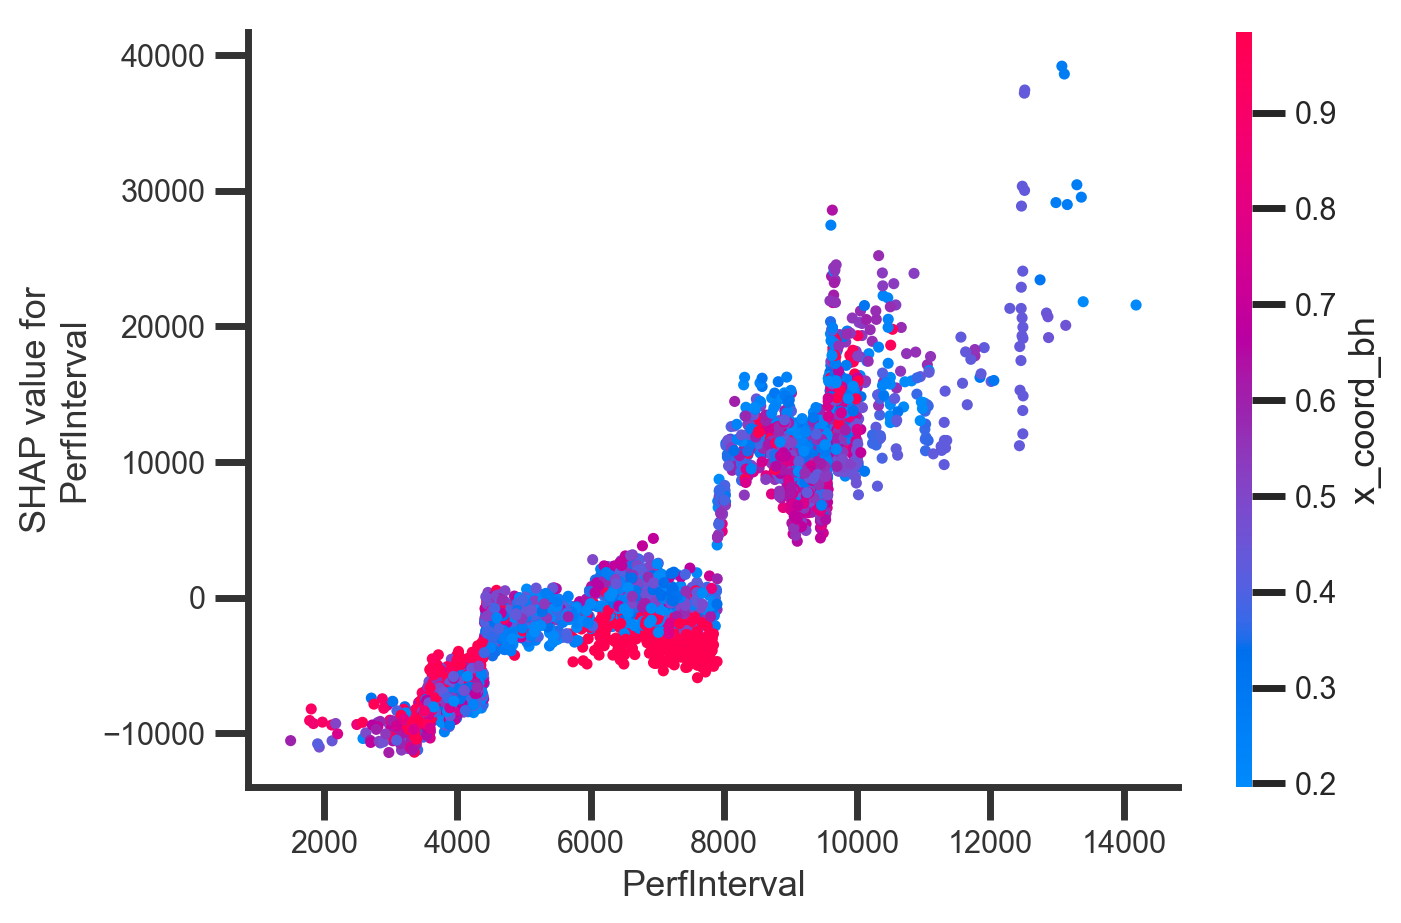

In [184]:
shap.dependence_plot('PerfInterval', shap_values, X)
plt.tight_layout()

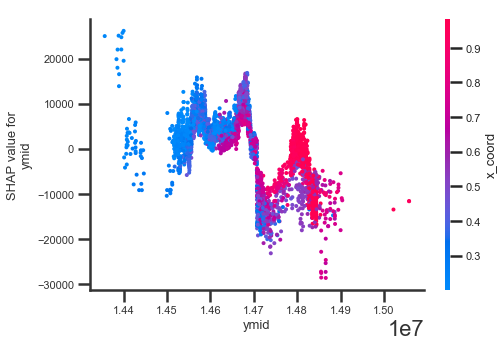

In [104]:
shap.dependence_plot('ymid', shap_values, X)

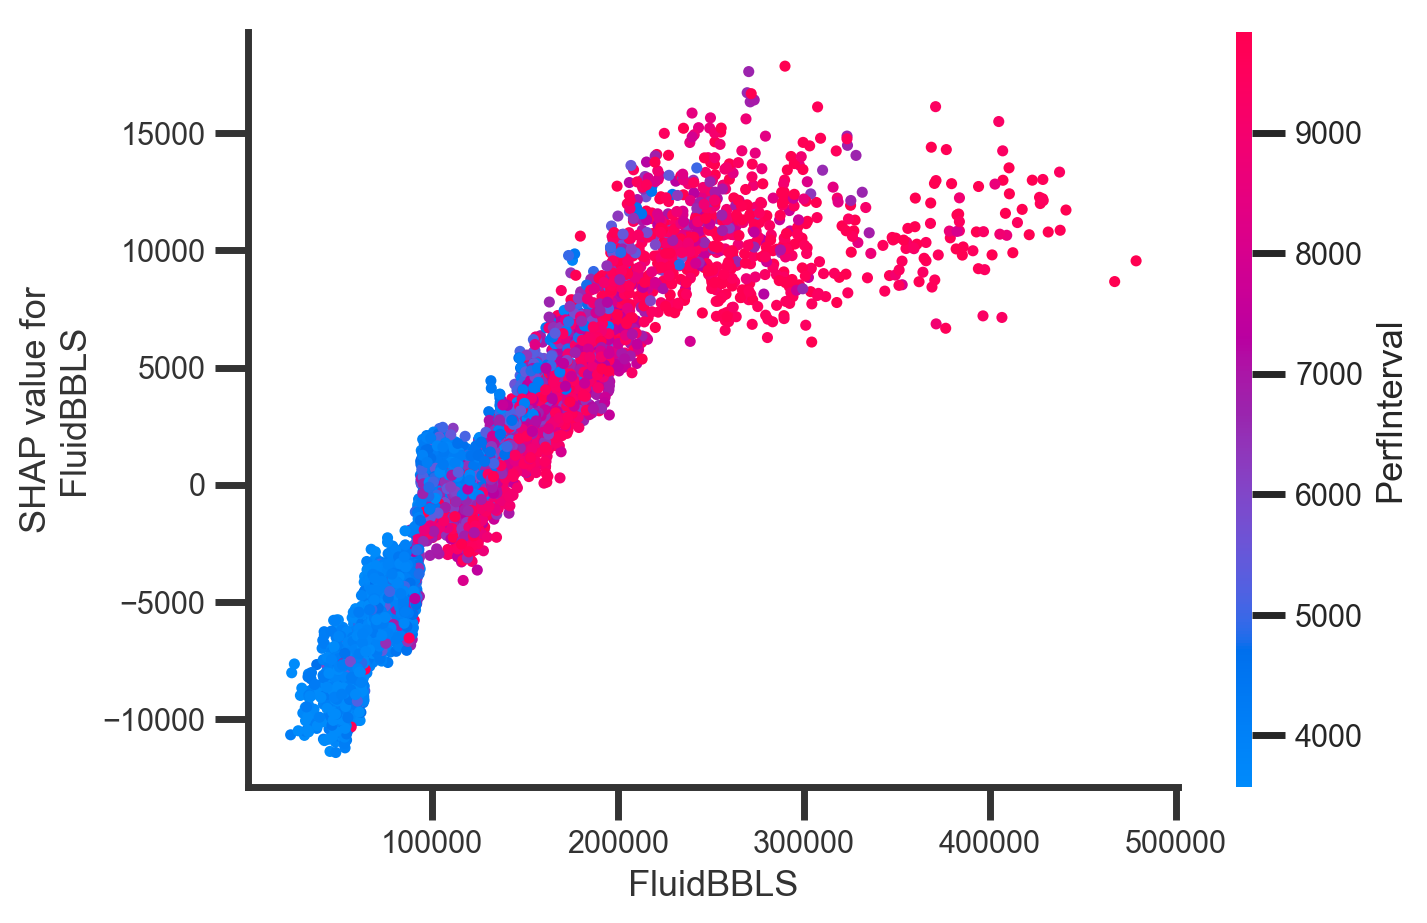

In [185]:
shap.dependence_plot('FluidBBLS', shap_values, X, interaction_index='PerfInterval')

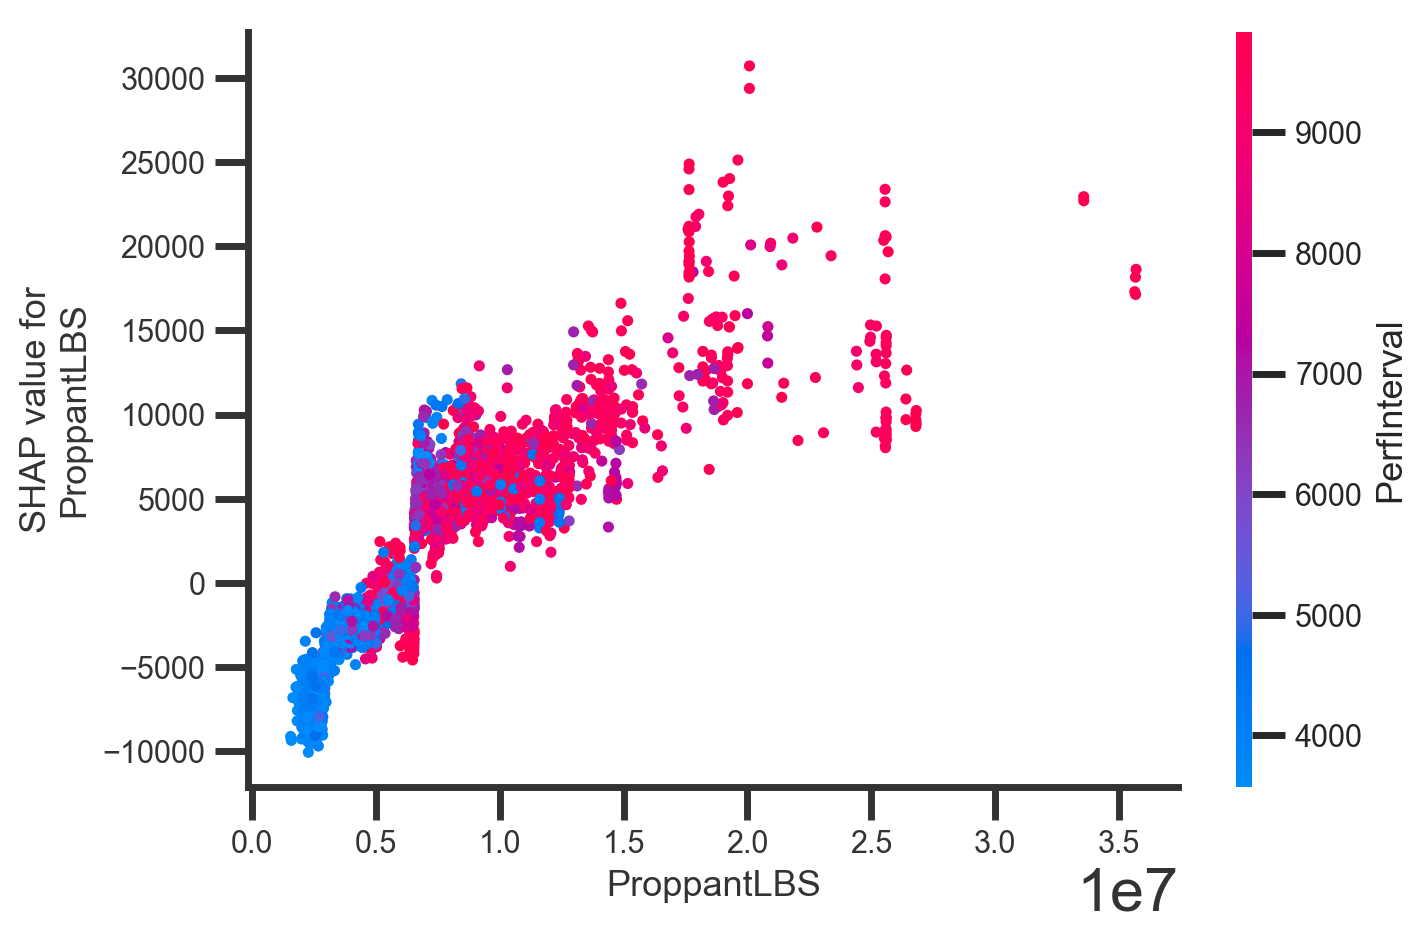

In [186]:
shap.dependence_plot('ProppantLBS', shap_values, X, interaction_index='PerfInterval')

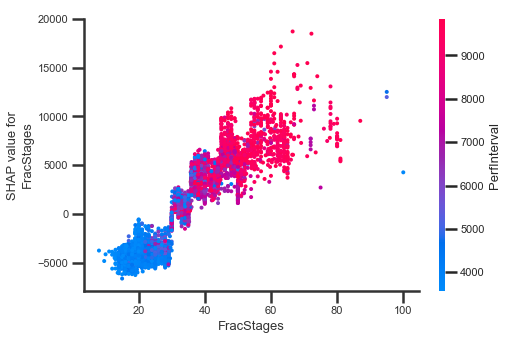

In [107]:
shap.dependence_plot('FracStages', shap_values, X, interaction_index='PerfInterval')

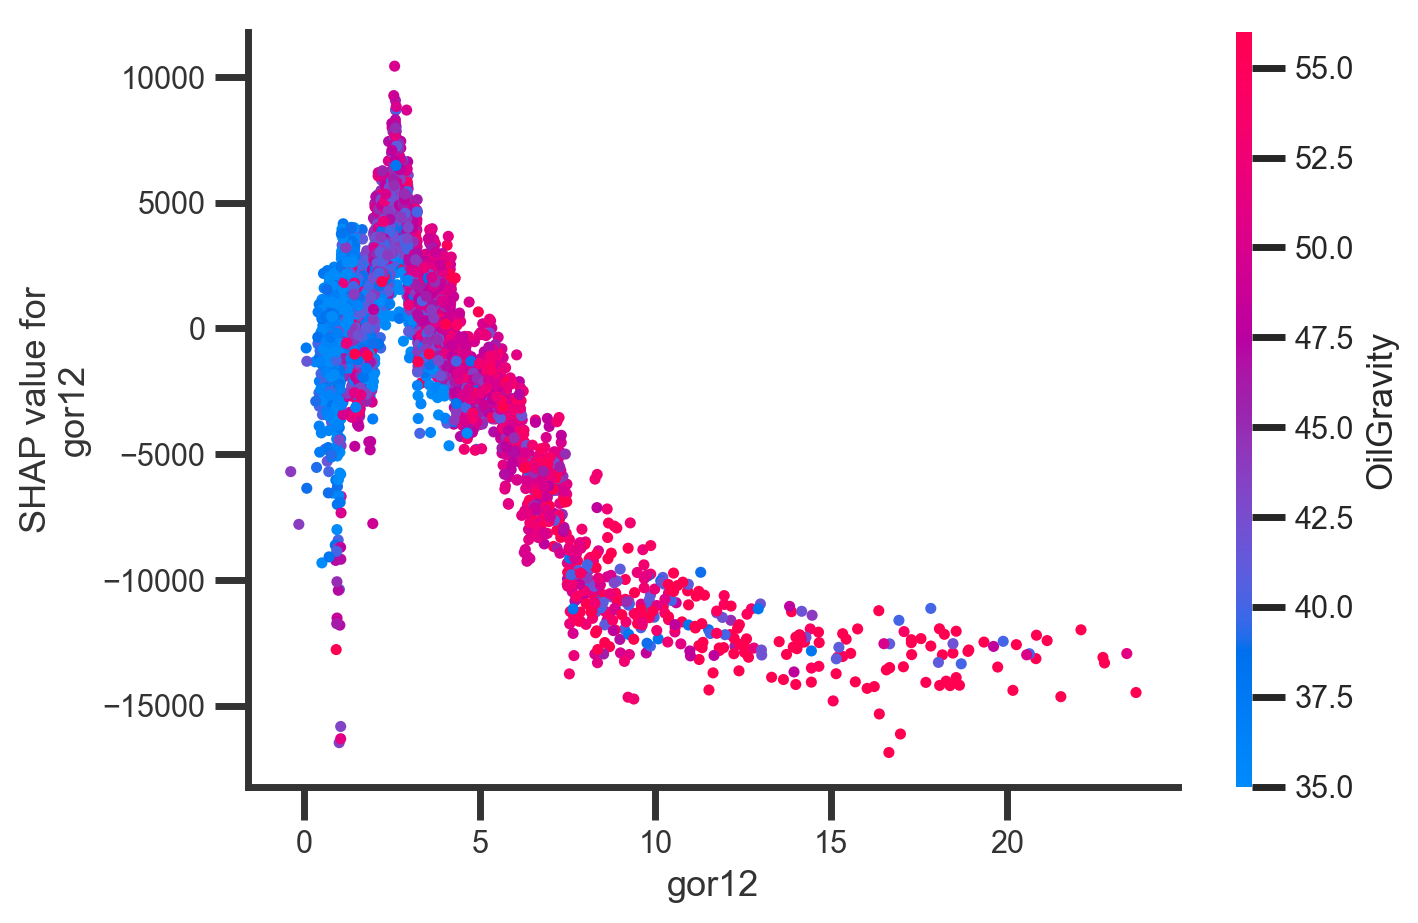

In [191]:
shap.dependence_plot('gor12', shap_values, X, interaction_index='OilGravity')

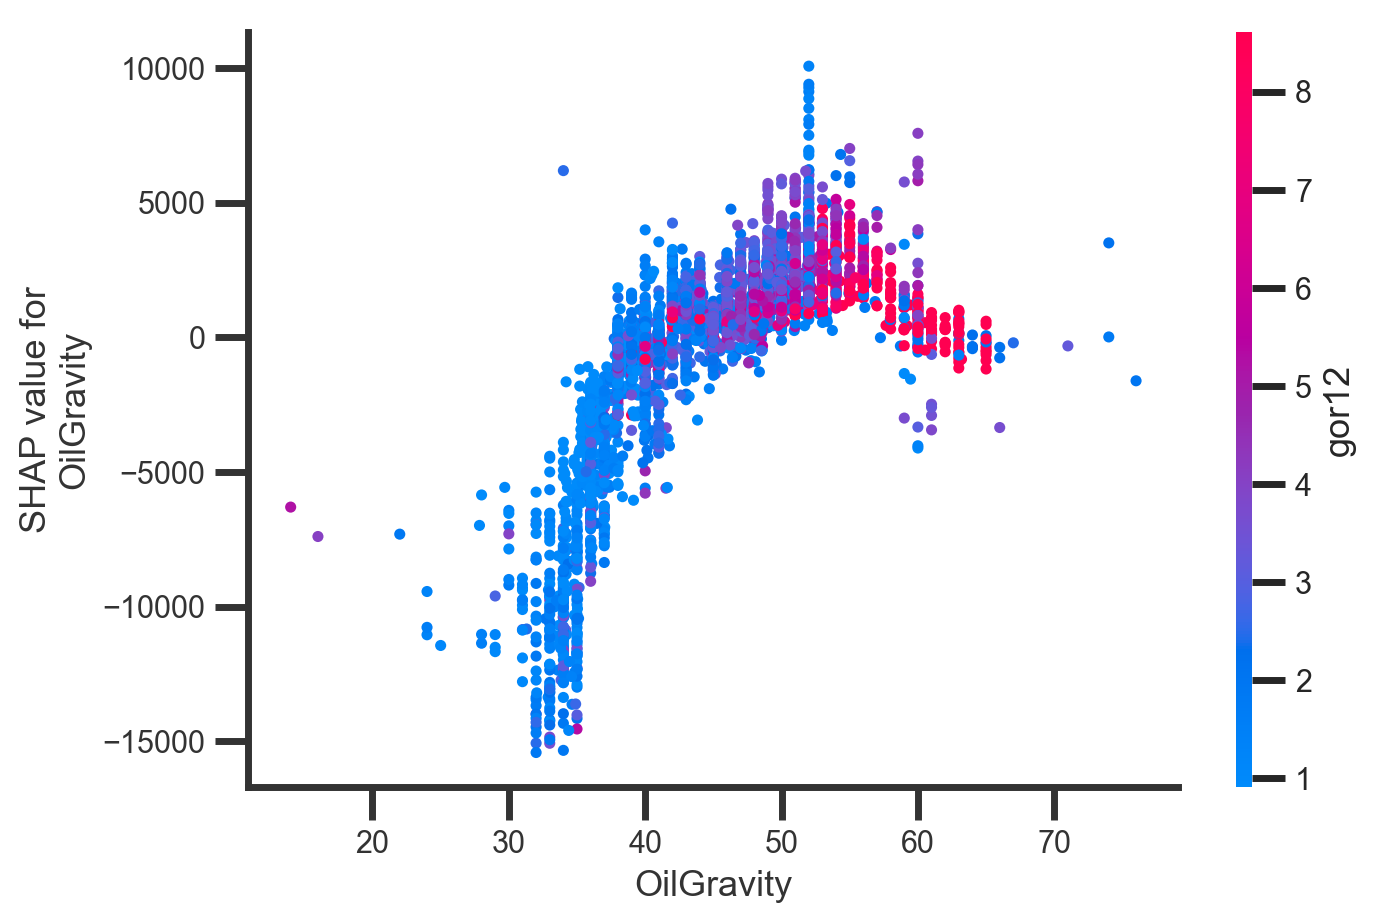

In [189]:
shap.dependence_plot('OilGravity', shap_values, X, interaction_index='gor12')

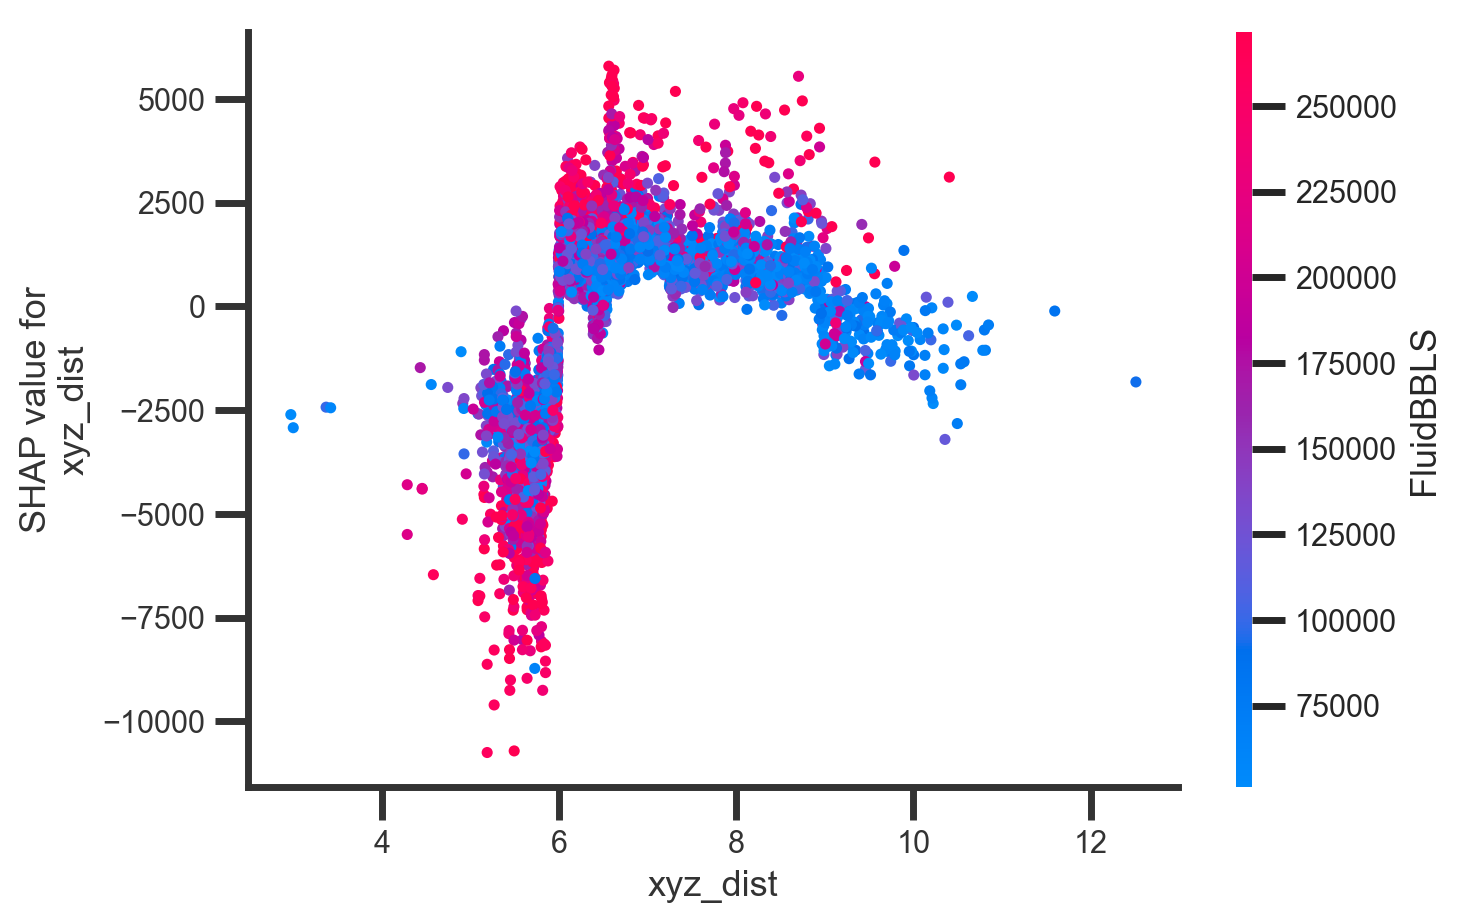

In [192]:
shap.dependence_plot('xyz_dist', shap_values, X)

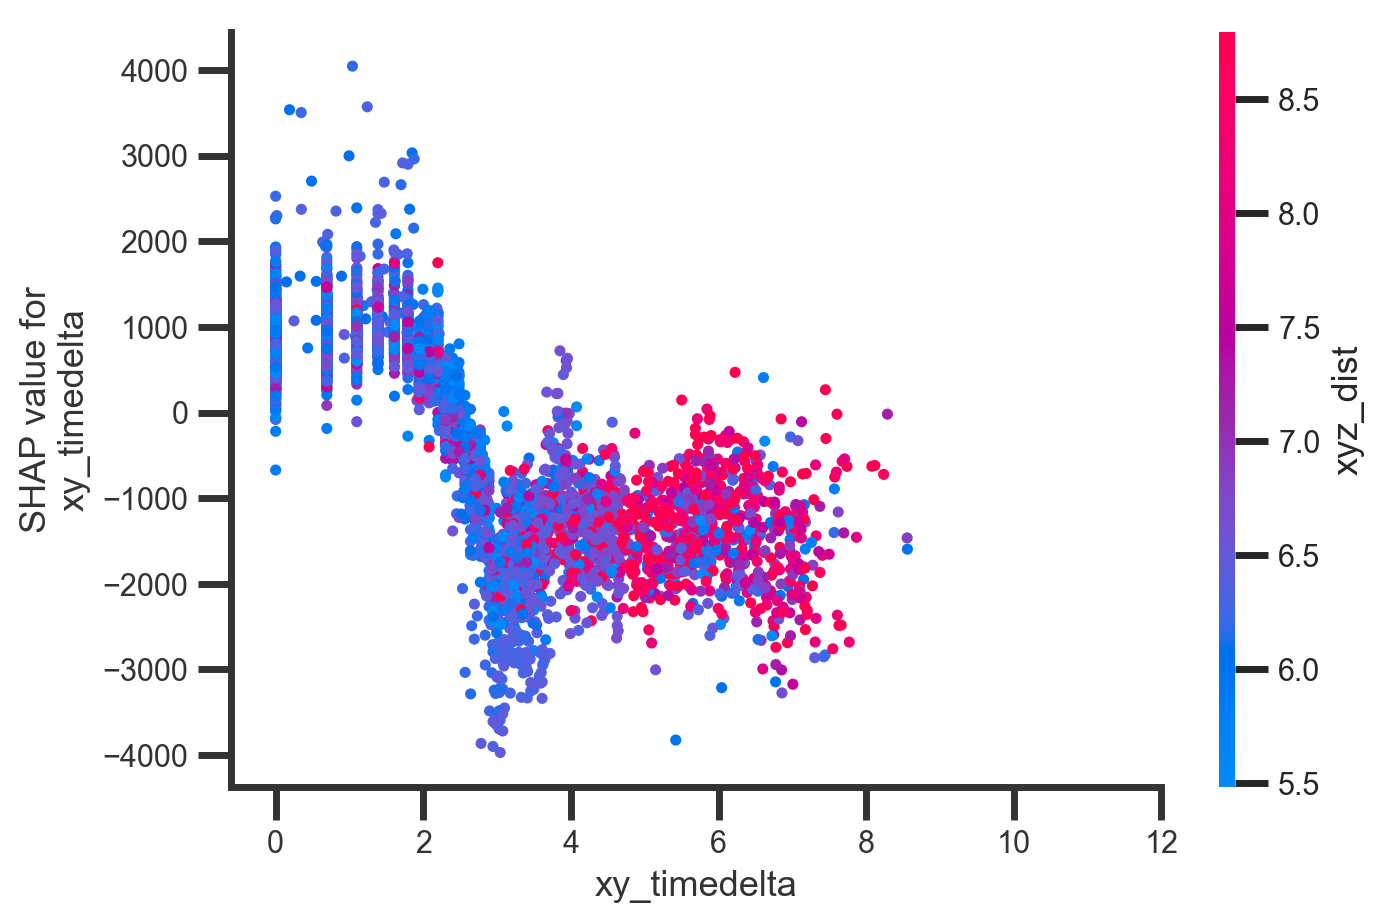

In [193]:
shap.dependence_plot('xy_timedelta', shap_values, X, xmin=0, xmax=12, interaction_index='xyz_dist')

In [ ]:
df_latlon = df_sql_well.copy()
df_latlon = df_latlon.loc[:, ['api10', 'Latitude', 'Longitude']]
df_latlon.info()

In [ ]:
df_map = df.merge(df_latlon, left_on='api10', right_on='api10')

In [ ]:
plt.figure(figsize=(15, 20))
sns.scatterplot(x='Longitude', y='Latitude', hue='gor36', size='oil36', data=df_map)